In [1]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')
from covid_model_deaths.compare_moving_average import CompareAveragingModelDeaths
model_1_path = '/ihme/covid-19/deaths/prod/2020_04_20_Europe/euro_data.csv'
model_2_path = '/ihme/covid-19/deaths/prod/2020_04_19_Europe/euro_data.csv'
model_3_path = '/ihme/covid-19/deaths/prod/2020_04_17_Europe/euro_data.csv'

In [7]:
INDEX_COLUMNS = ['location_id', 'location', 'date', 'observed']
DRAW_COLUMNS = [f'draw_{i}' for i in range(1000)]


def load_data(data_path: str, location_ids = None) -> pd.DataFrame:
    """Load data and convert time to pandas time stamp."""
    data = pd.read_csv(data_path)
    data['date'] = pd.to_datetime(data['date'])
    if location_ids is not None:
        data = data[data.location_id.isin(location_ids)]
    return data


def get_latest_data_date(today_data: pd.DataFrame) -> pd.Series:
    """Get the most recent date for which we have data by location.

    Parameters
    ----------
    today_data
        Today's model draws.

    Returns
    -------
        A series indexed by location id whose values are the last day for
        which we have data.

    """
    latest_date = today_data[today_data['observed']].groupby('location_id')['date'].max()
    return latest_date


def get_daily_predicted(data: pd.DataFrame, latest_data_date: pd.Series) -> pd.DataFrame:
    """Get the subset of predicted data corresponding to the latest data date."""
    data = data.set_index('location_id')
    # Broadcast latest data date over the location index.
    min_date = latest_data_date.loc[data.index]
    # Get the current data data for the dataset so that we can compute the
    # predicted daily deaths on the first predicted date.
    to_average = data['date'] >= min_date
    data = (data
            .loc[to_average]
            .reset_index()
            .sort_values(['location_id', 'date'])
            .groupby(['location_id', 'location'])
            .apply(lambda x: (x.set_index('date') - x.set_index('date').shift(1)))
            .reset_index()
            .set_index('location_id'))
    # Now that we're in daily space, drop the last data date
    min_date = latest_data_date.loc[data.index]
    data = data.loc[data['date'] != min_date].reset_index()
    data['observed'] = False
    return data.loc[:, INDEX_COLUMNS + DRAW_COLUMNS]


def get_daily_observed(today_data: pd.DataFrame) -> pd.DataFrame:
    """Get the subset of observed daily deaths from today's draws."""
    today_data = (today_data
                  .loc[today_data['observed']]
                  .sort_values(INDEX_COLUMNS))
    today_daily_data = (today_data
                        .groupby(['location_id', 'location', 'observed'])
                        .apply(lambda x: x.set_index('date') - x.set_index('date').shift(1))
                        .reset_index()
                        .set_index(INDEX_COLUMNS))
    # Assume the first observed deaths occurred the first day of observation.
    today_data = today_data.set_index(INDEX_COLUMNS)
    to_replace = today_daily_data.isnull().sum(axis=1) > 0
    today_daily_data.loc[to_replace] = today_data.loc[to_replace]
    return today_daily_data.reset_index()


def get_daily_predictions(today_data, yesterday_data, day_before_yesterday_data):
    """Gather all predicted data across datasets."""
    latest_date = get_latest_data_date(today_data)
    today_predicted = get_daily_predicted(today_data, latest_date)
    yesterday_predicted = get_daily_predicted(yesterday_data, latest_date)
    day_before_yesterday_predicted = get_daily_predicted(day_before_yesterday_data, latest_date)
    all_predicted = pd.concat([today_predicted, yesterday_predicted, day_before_yesterday_predicted],
                              ignore_index=True)
    return all_predicted


def moving_average_predictions(today_data_path, yesterday_data_path, day_before_yesterday_path):
    """Average the predictions for recent 3 runs."""
    print("Averaging over the following files: ", [today_data_path, yesterday_data_path, day_before_yesterday_path])
    today_data = load_data(today_data_path)
    yesterday_data = load_data(yesterday_data_path, today_data.location_id.unique())
    day_before_yesterday_data = load_data(day_before_yesterday_path, today_data.location_id.unique())
    
    observed_data = get_daily_observed(today_data)
    all_predicted = get_daily_predictions(today_data, yesterday_data, day_before_yesterday_data)
    prediction_average = all_predicted.groupby(INDEX_COLUMNS).mean().reset_index()
    combined = pd.concat([observed_data, prediction_average], ignore_index=True)
    cumulative = (combined.groupby(['location_id', 'location'], as_index=False)
                  .apply(lambda x: x.set_index(['location_id', 'location', 'date', 'observed']).cumsum())
                  .reset_index()
                  .drop(columns='level_0'))
    return cumulative




In [13]:
today_data

NameError: name 'today_data' is not defined

In [8]:
prediction = moving_average_predictions(model_1_path, model_2_path, model_3_path)

Averaging over the following files:  ['/ihme/covid-19/deaths/prod/2020_04_20_Europe/euro_data.csv', '/ihme/covid-19/deaths/prod/2020_04_19_Europe/euro_data.csv', '/ihme/covid-19/deaths/prod/2020_04_17_Europe/euro_data.csv']


In [14]:
prediction.to_csv('/ihme/covid-19/deaths/prod/2020_04_20_Europe/past_avg_euro_data.csv.csv', index=False)

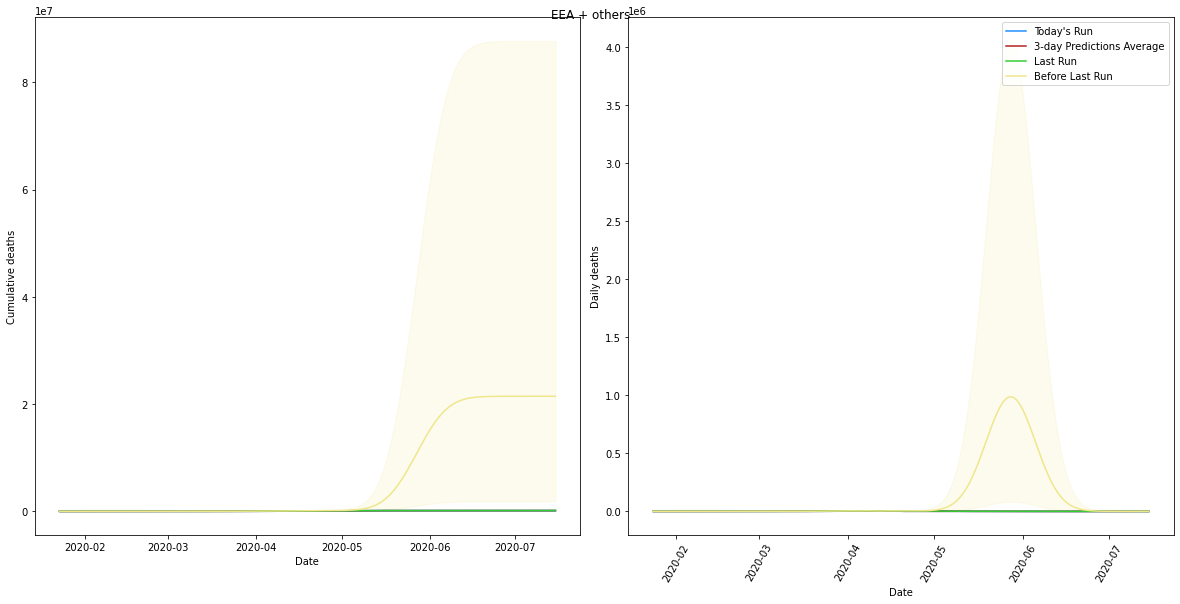

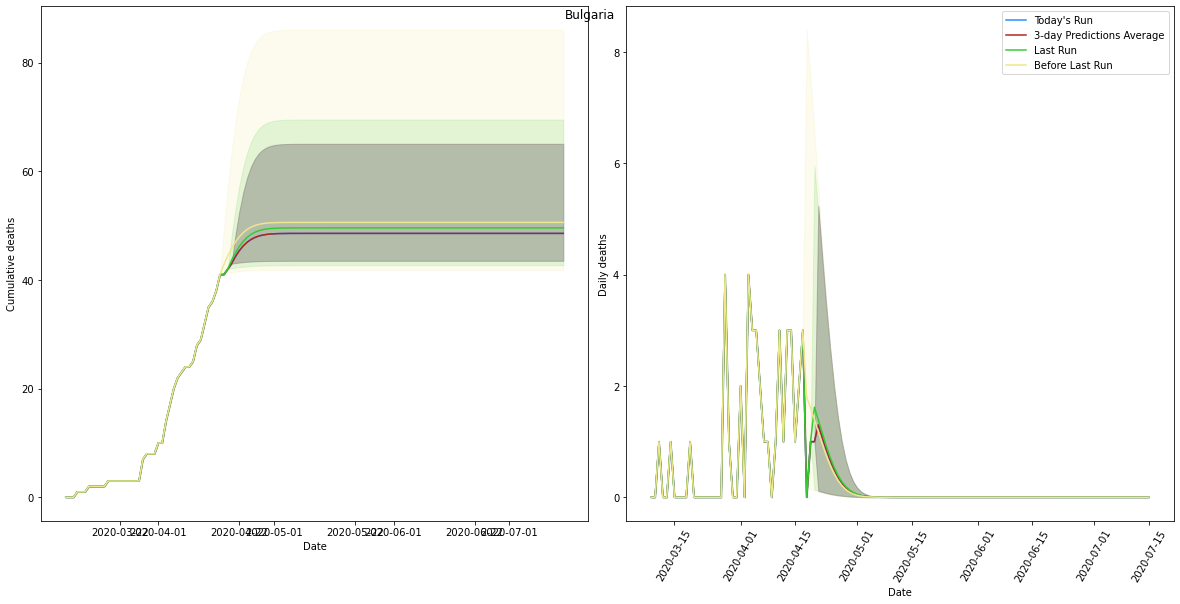

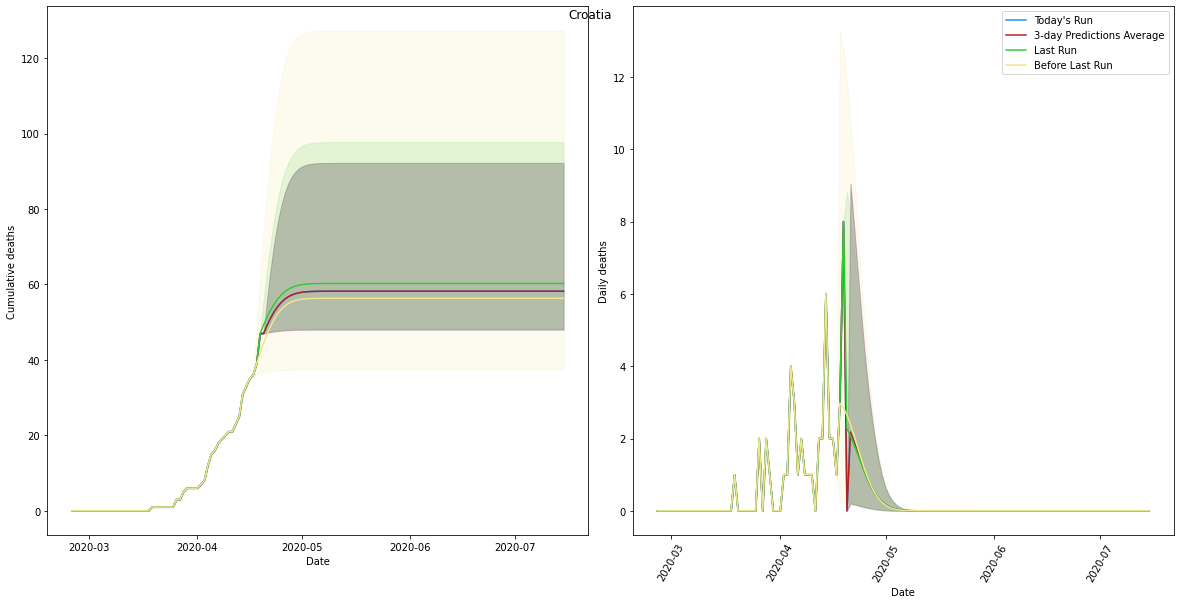

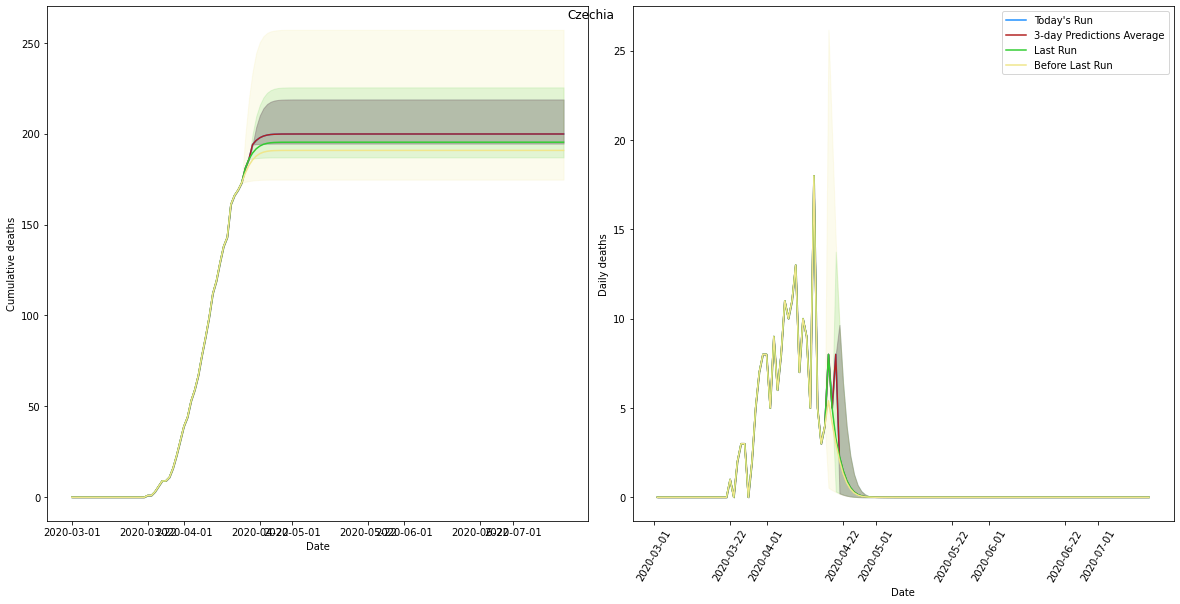

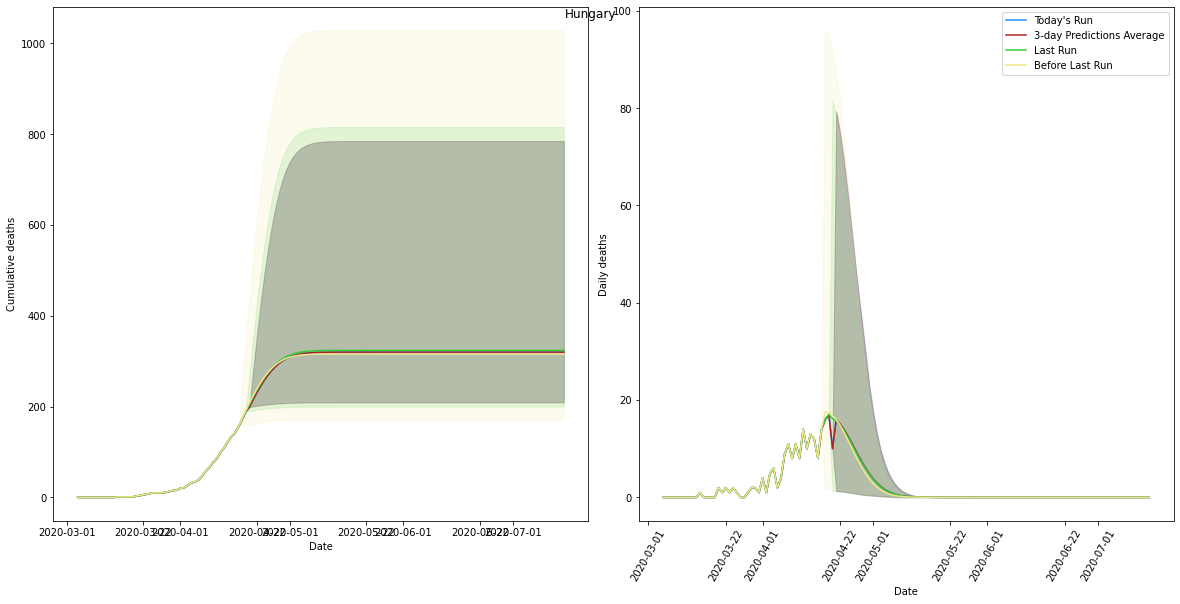

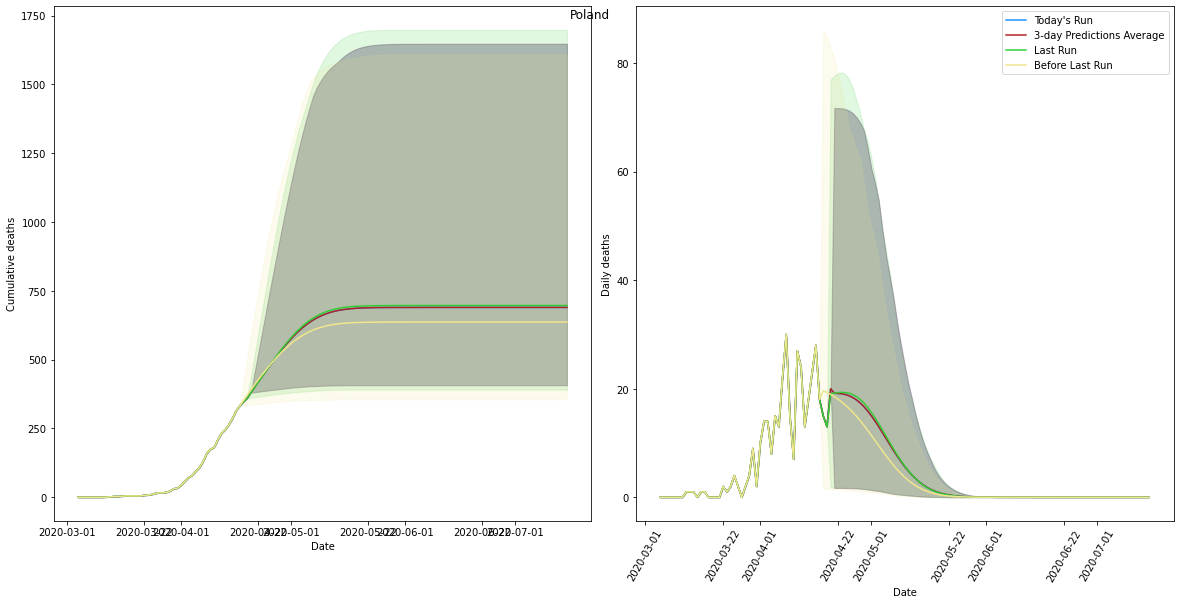

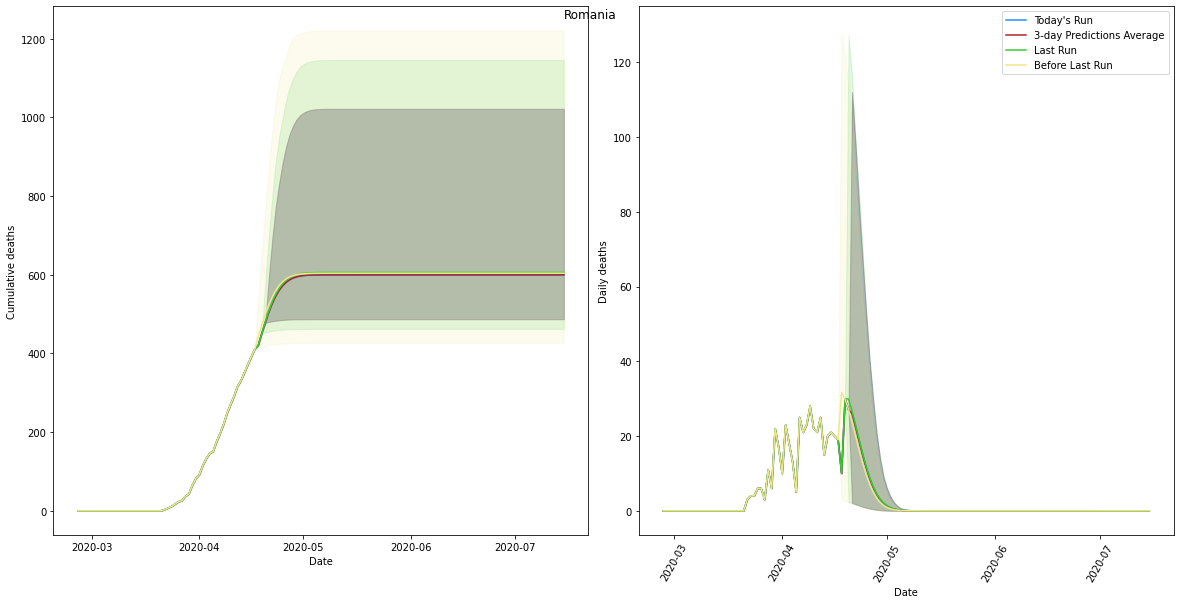

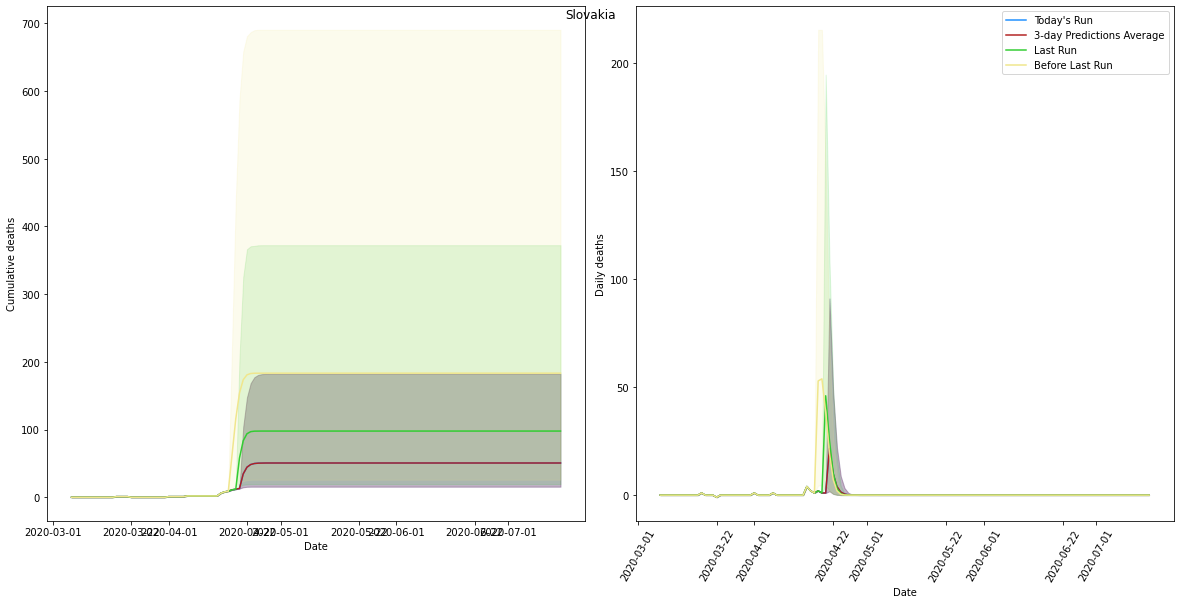

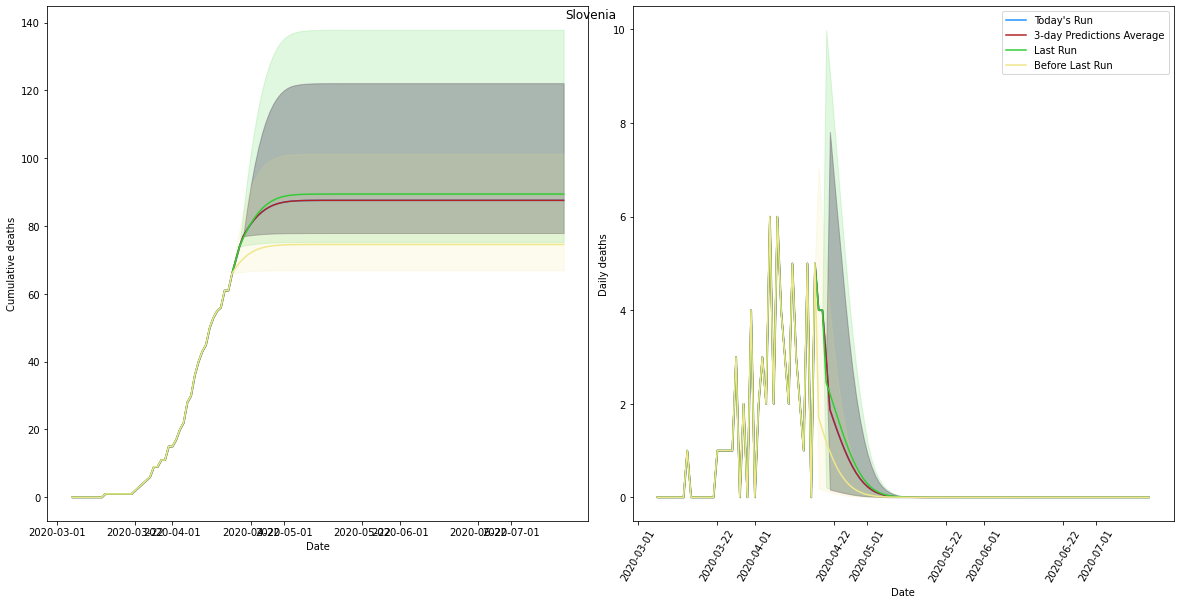

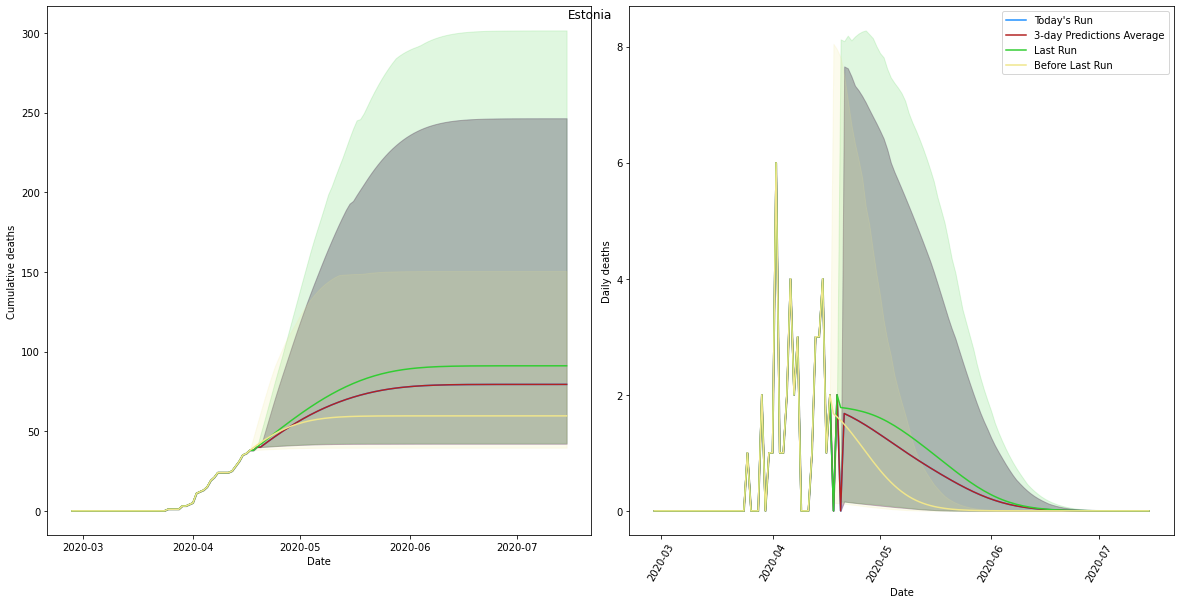

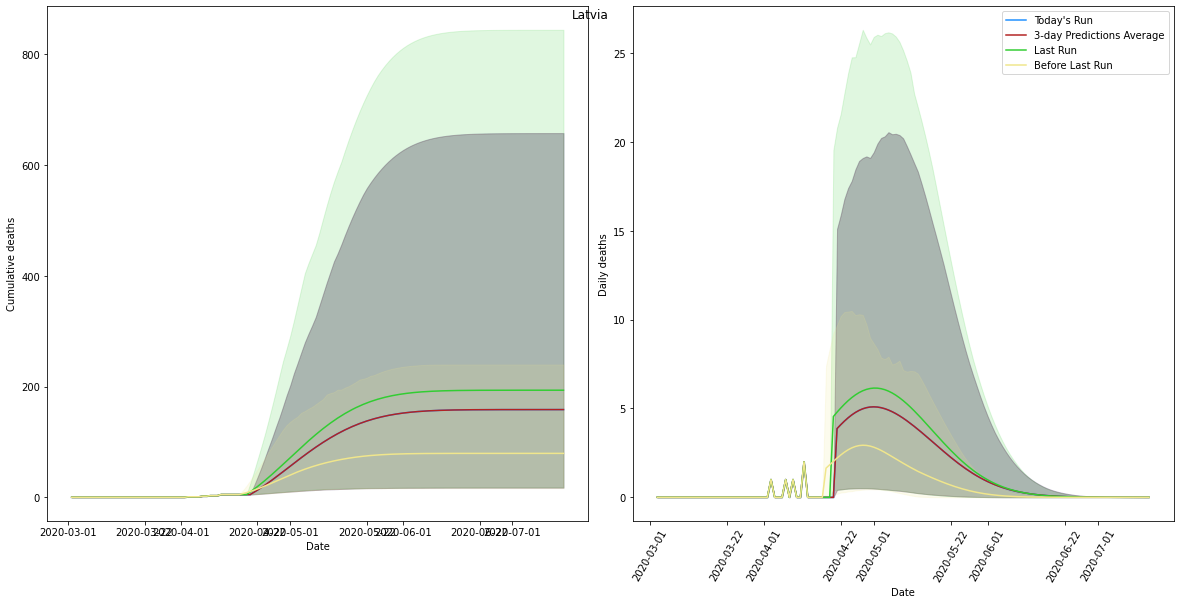

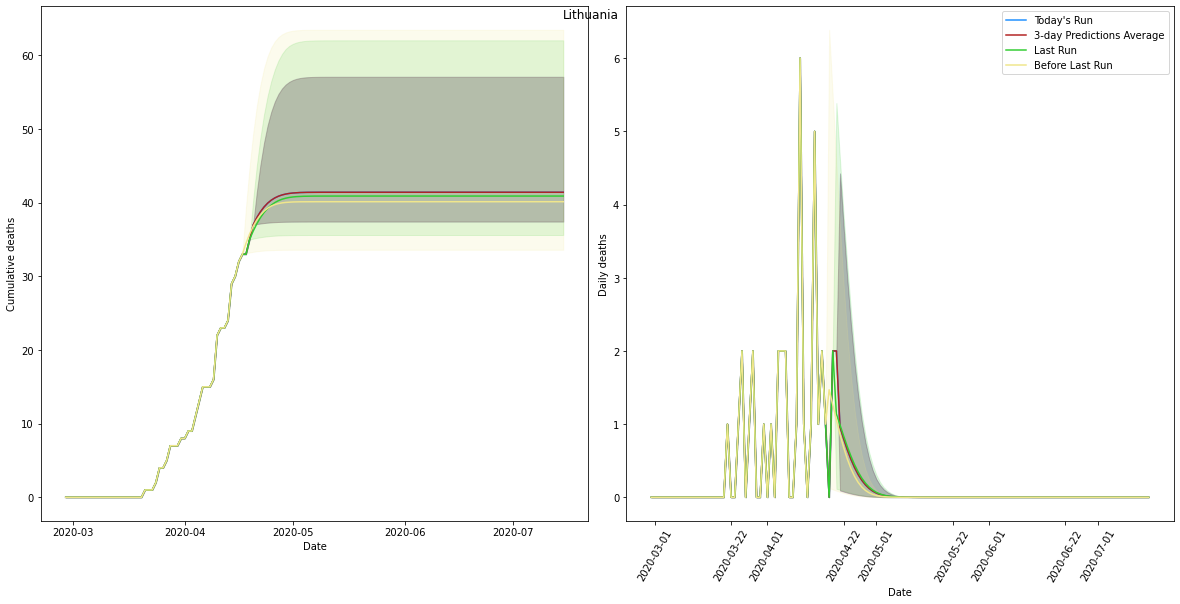

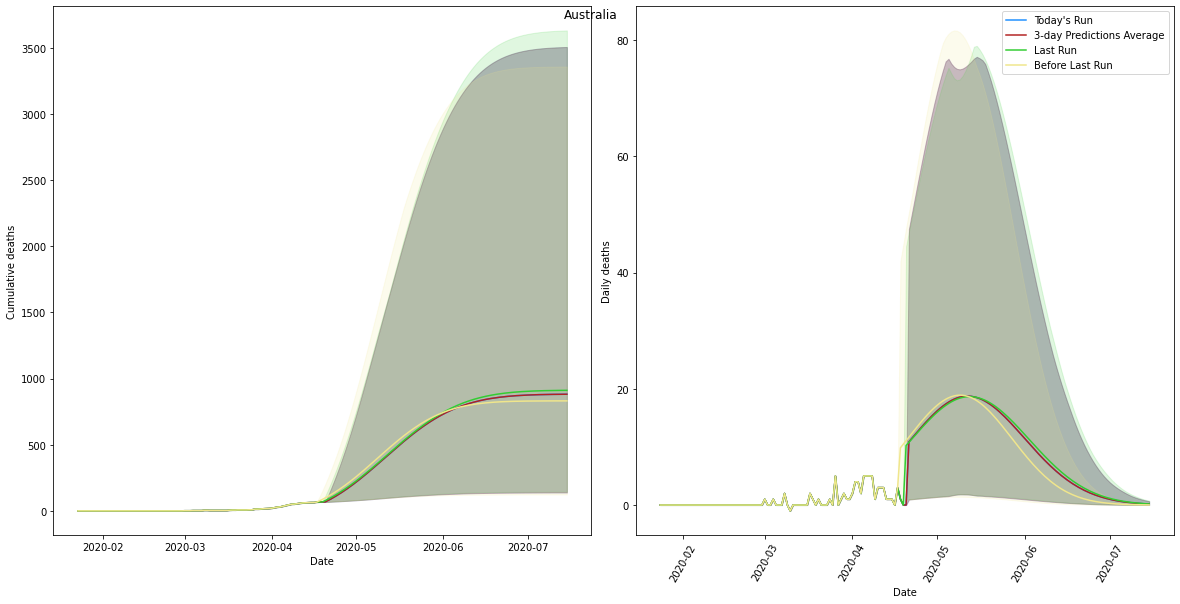

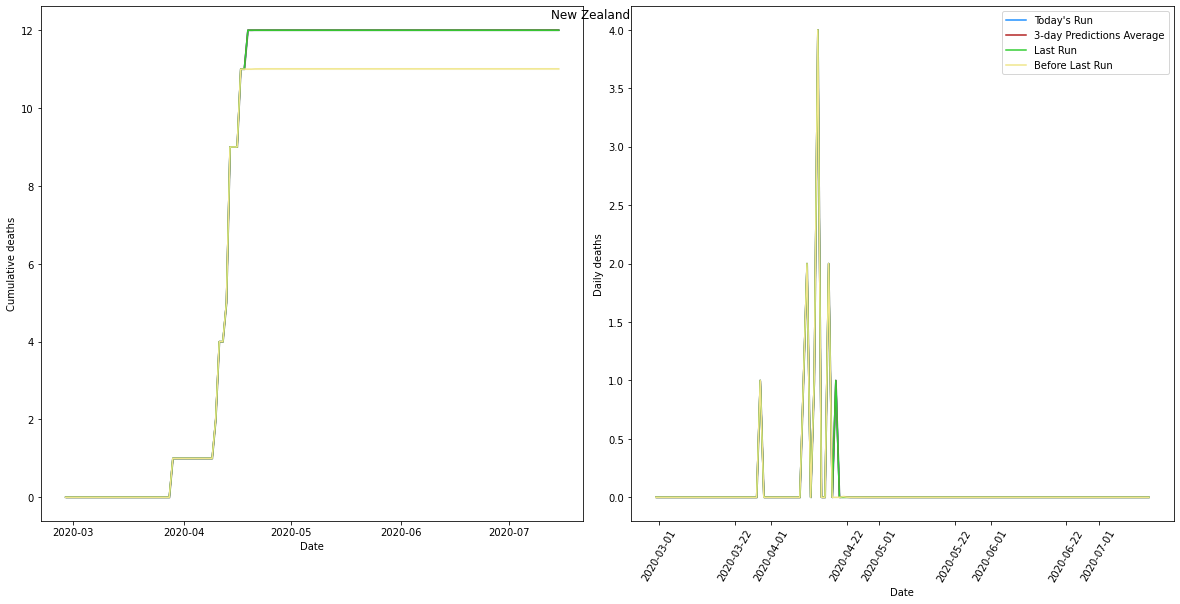

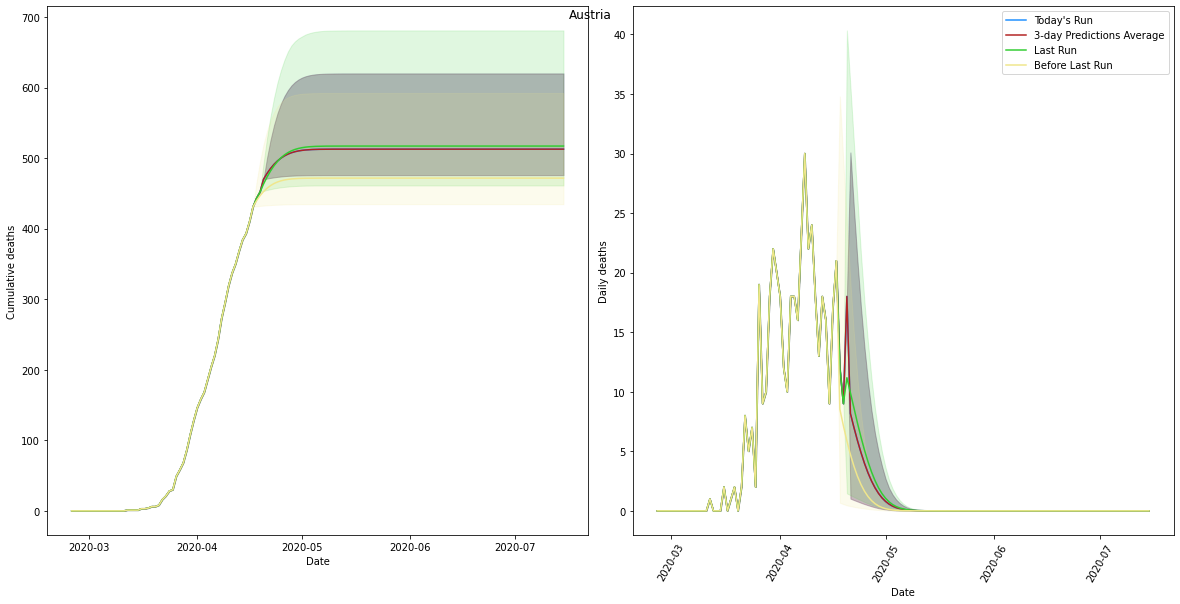

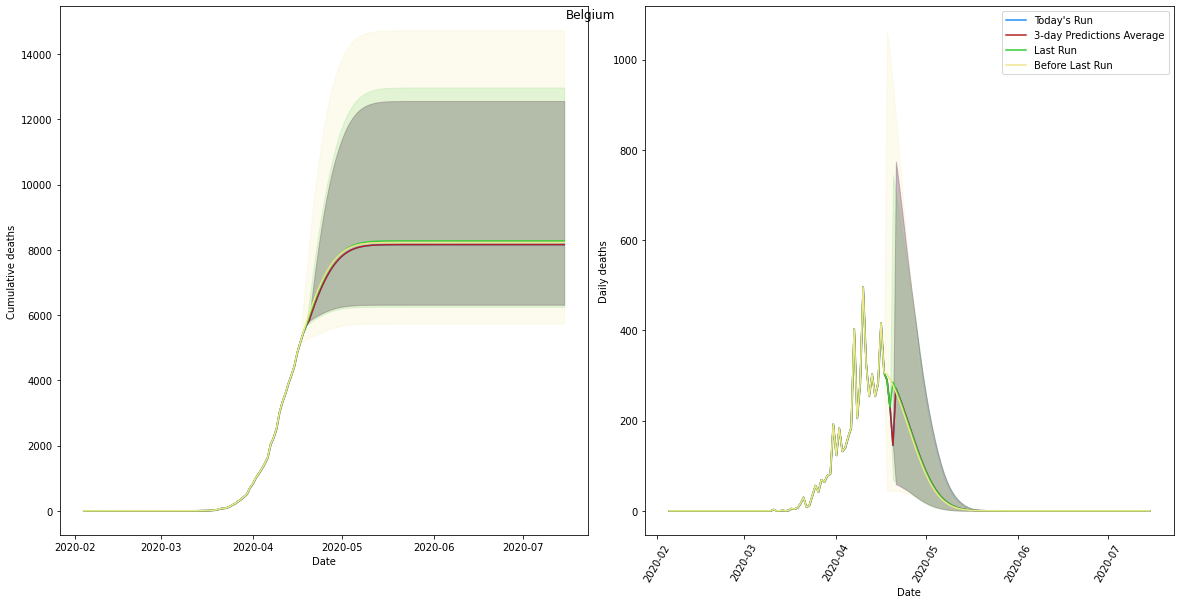

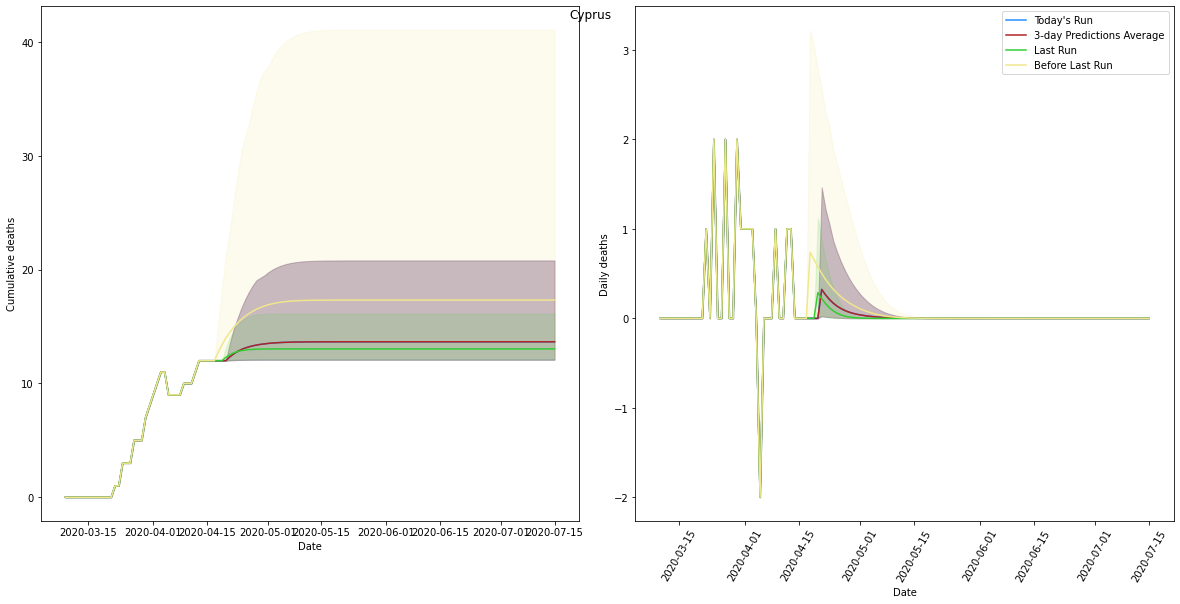

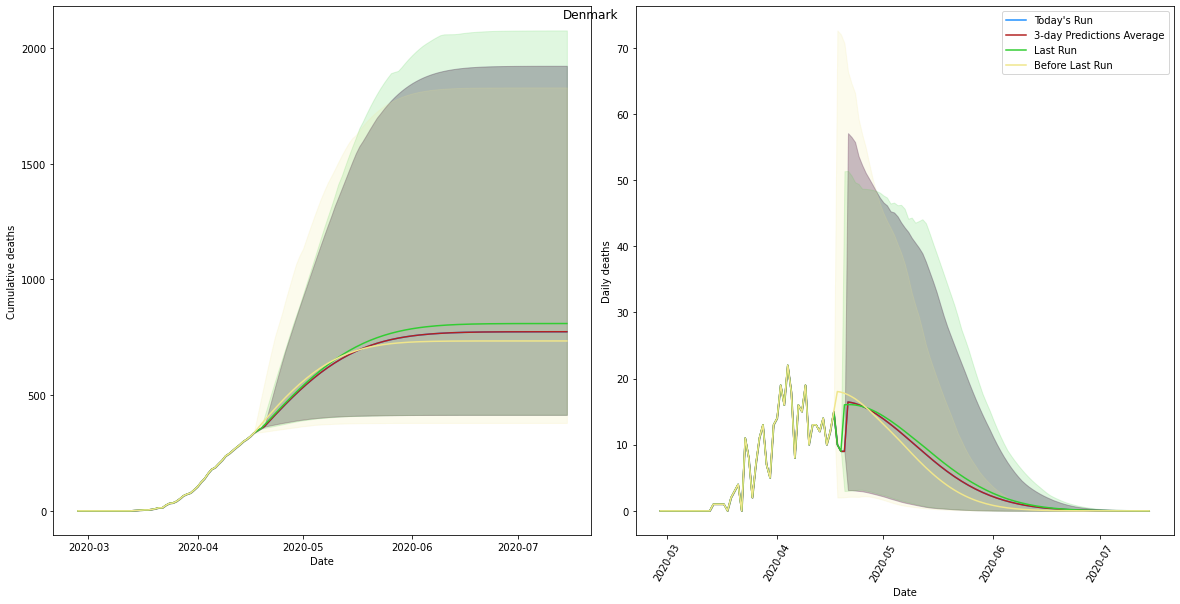

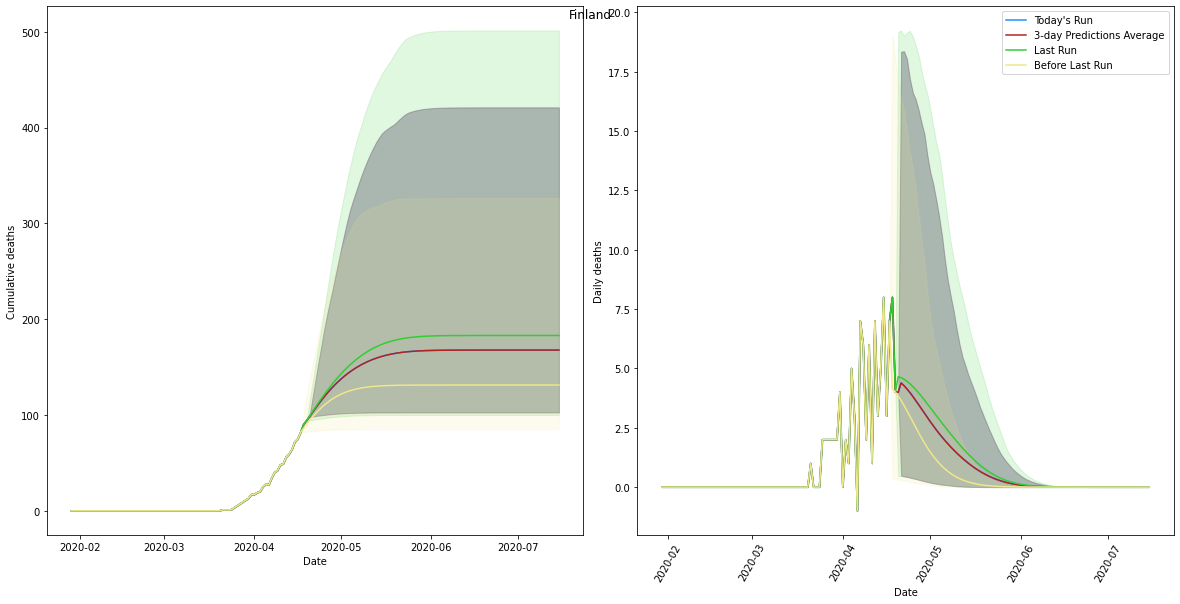

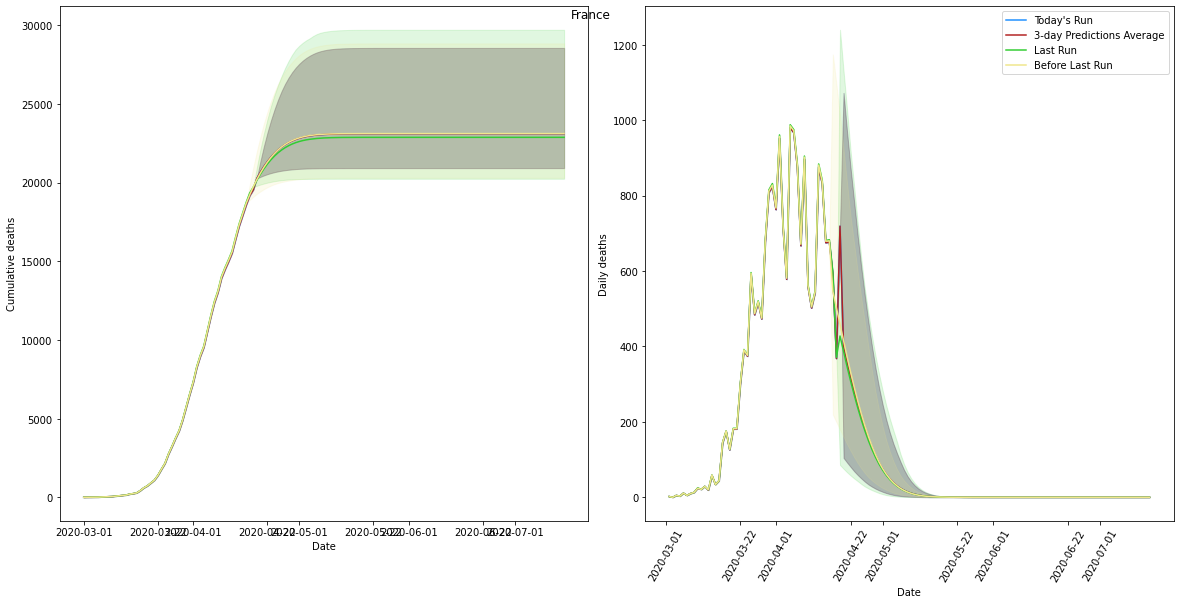

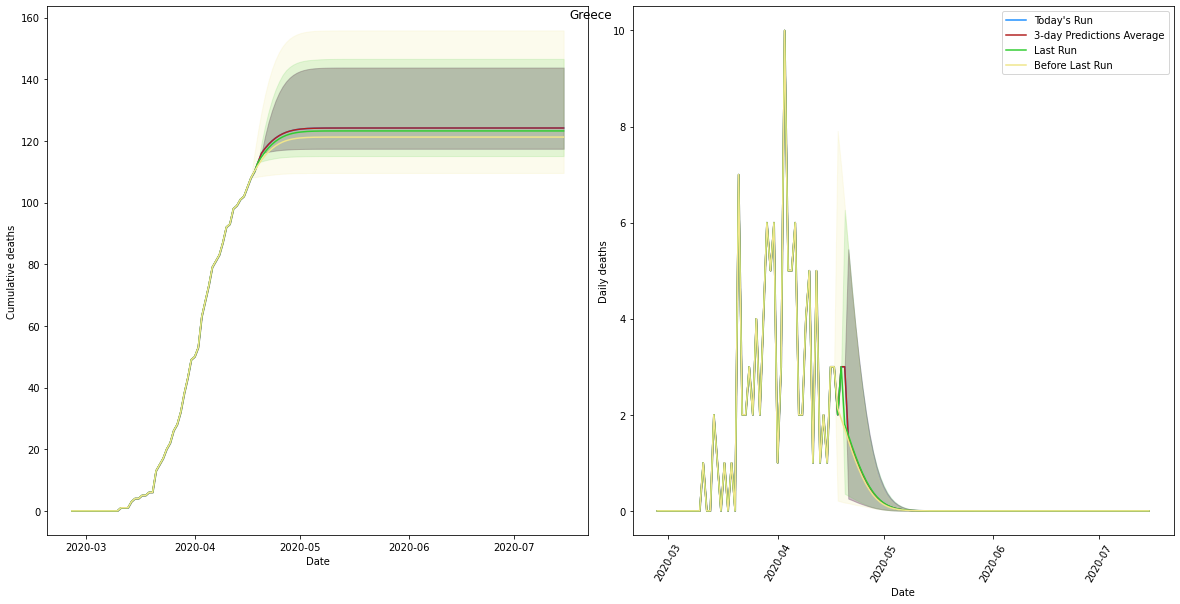

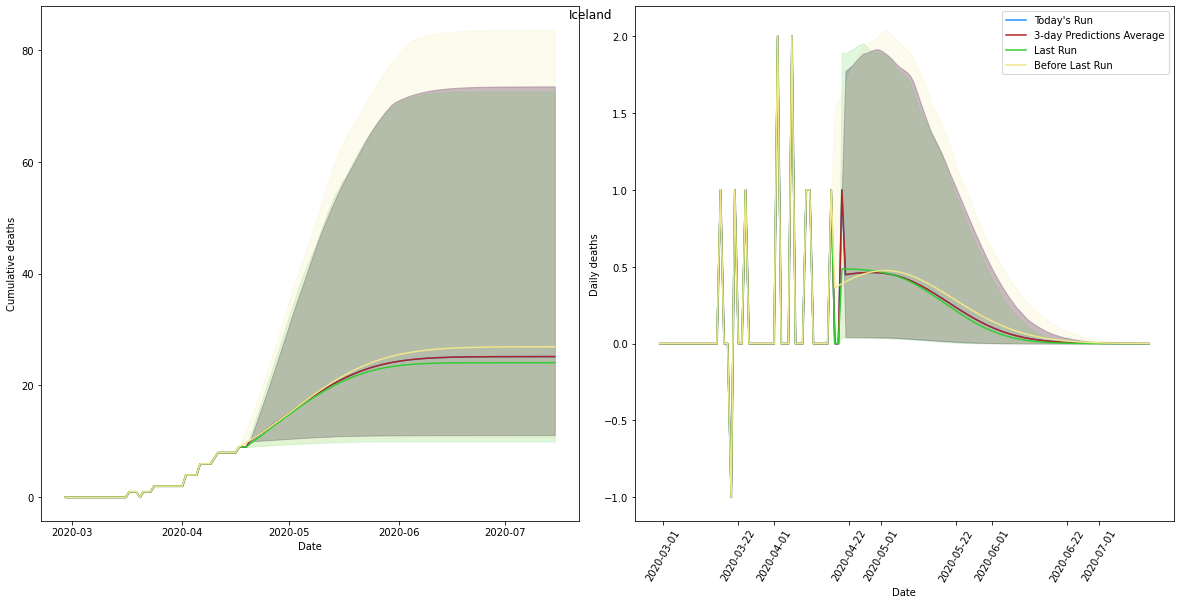

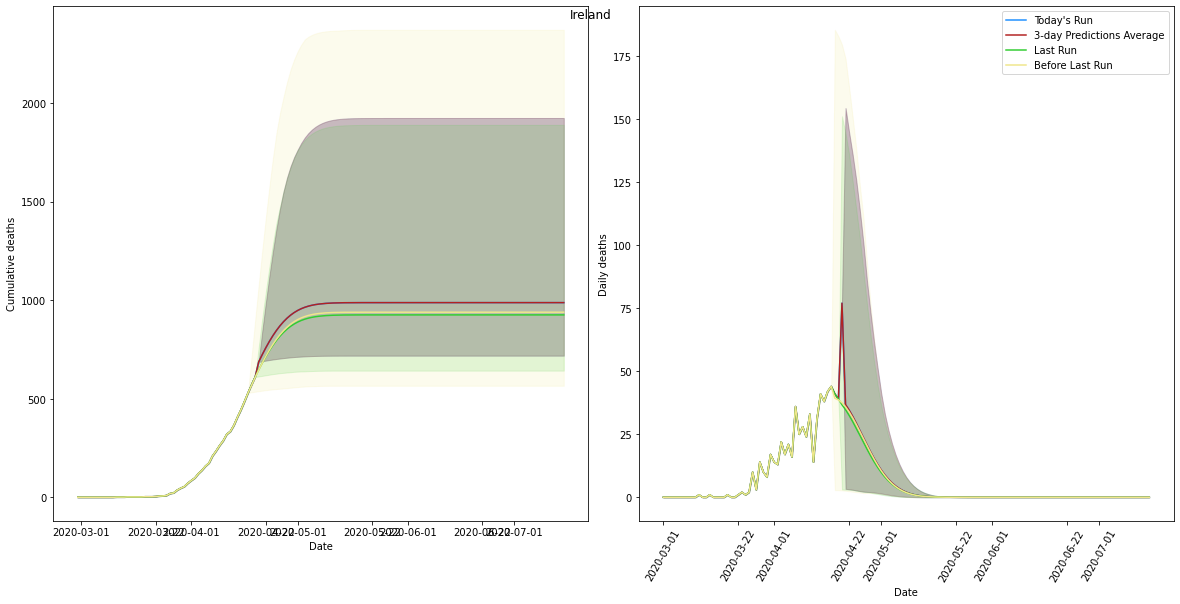

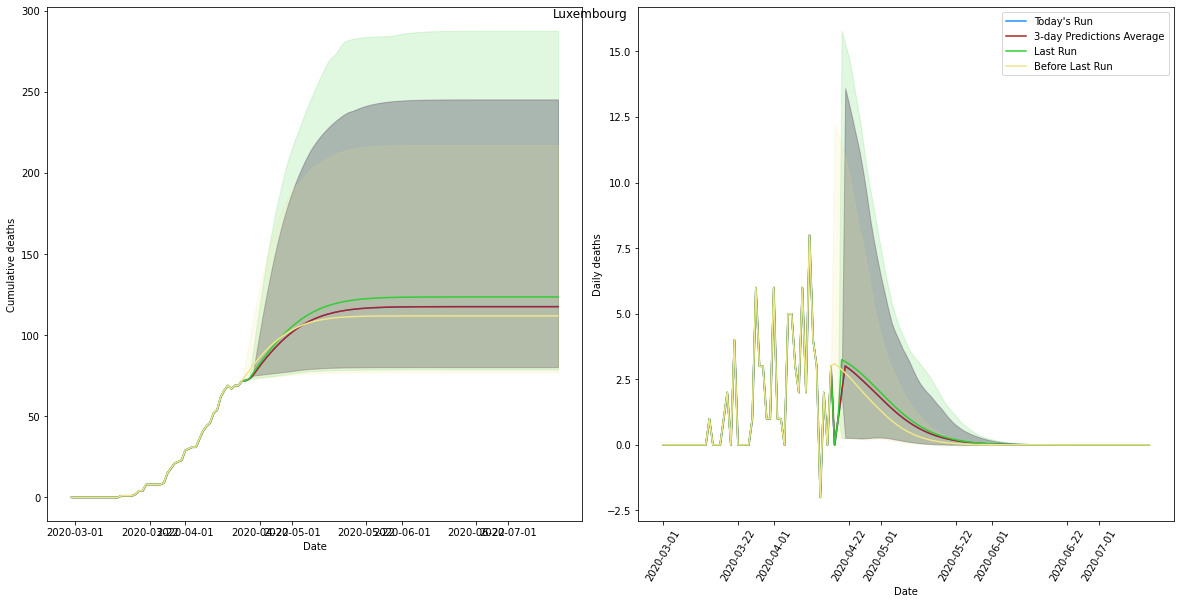

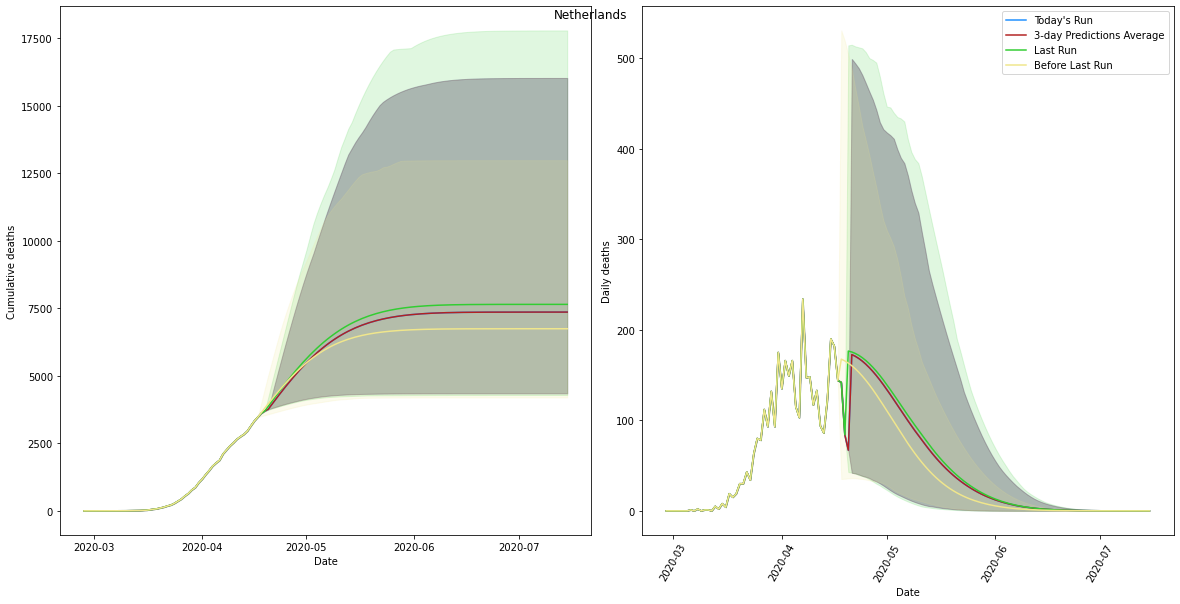

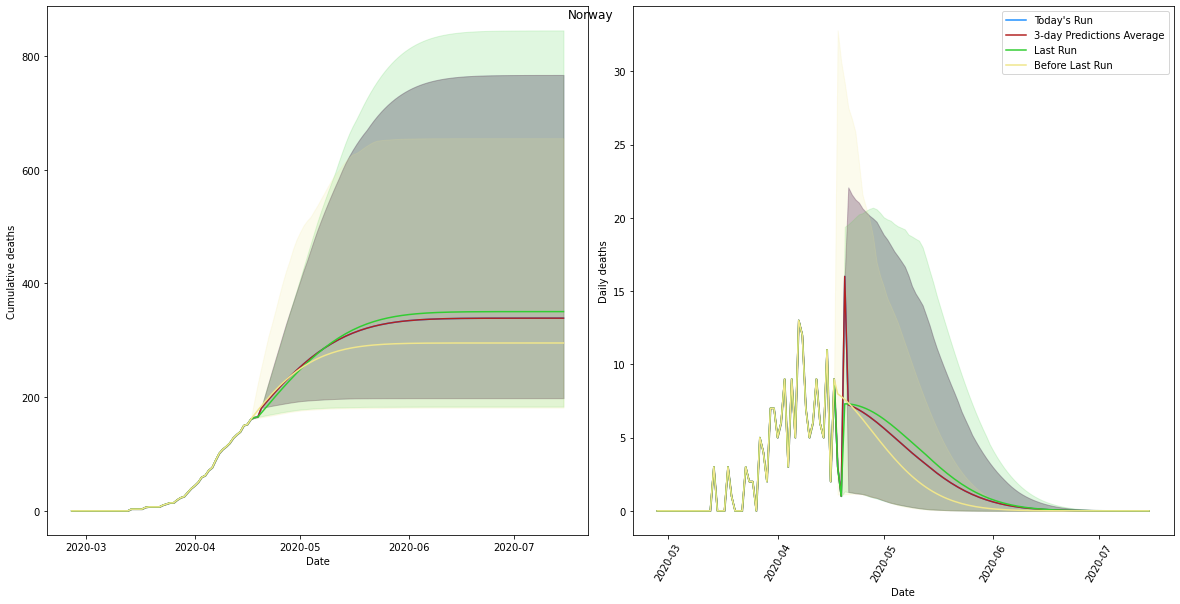

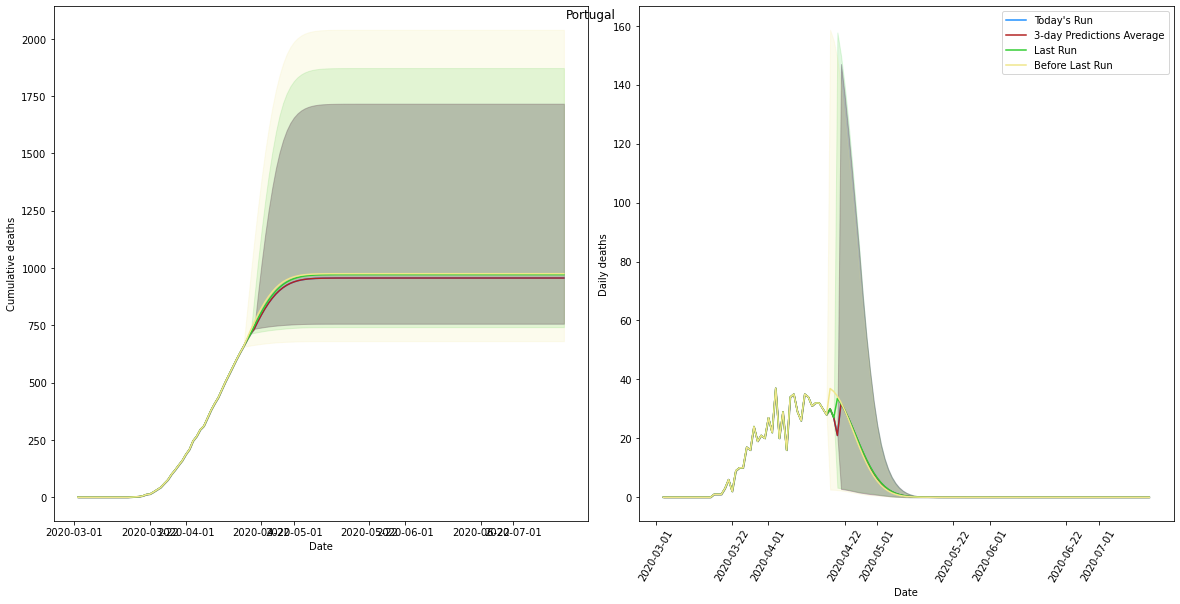

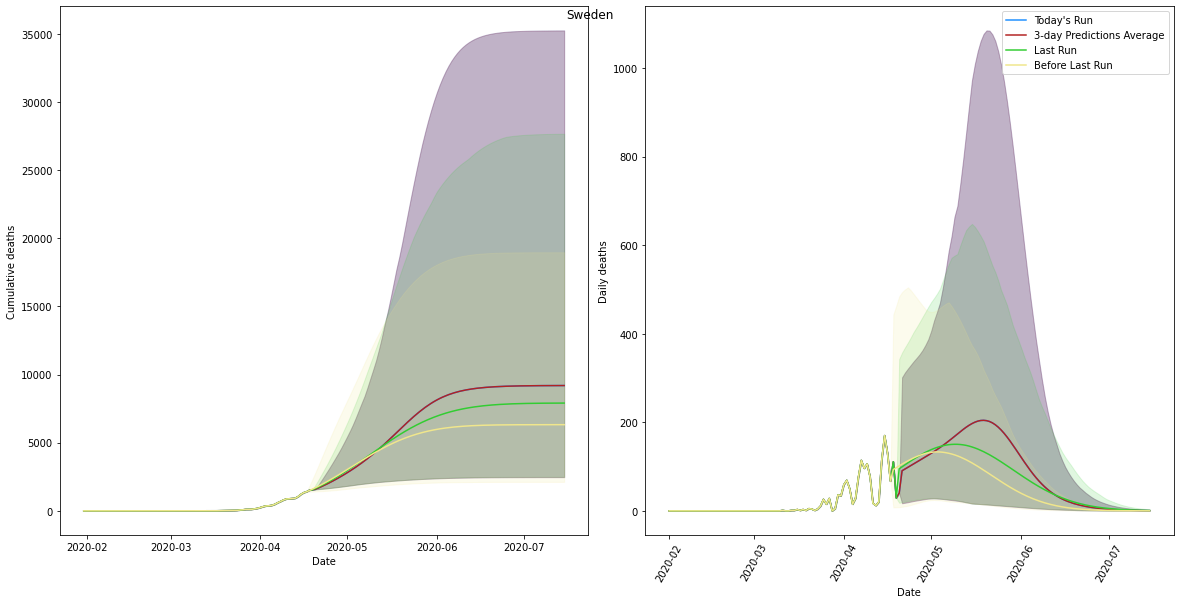

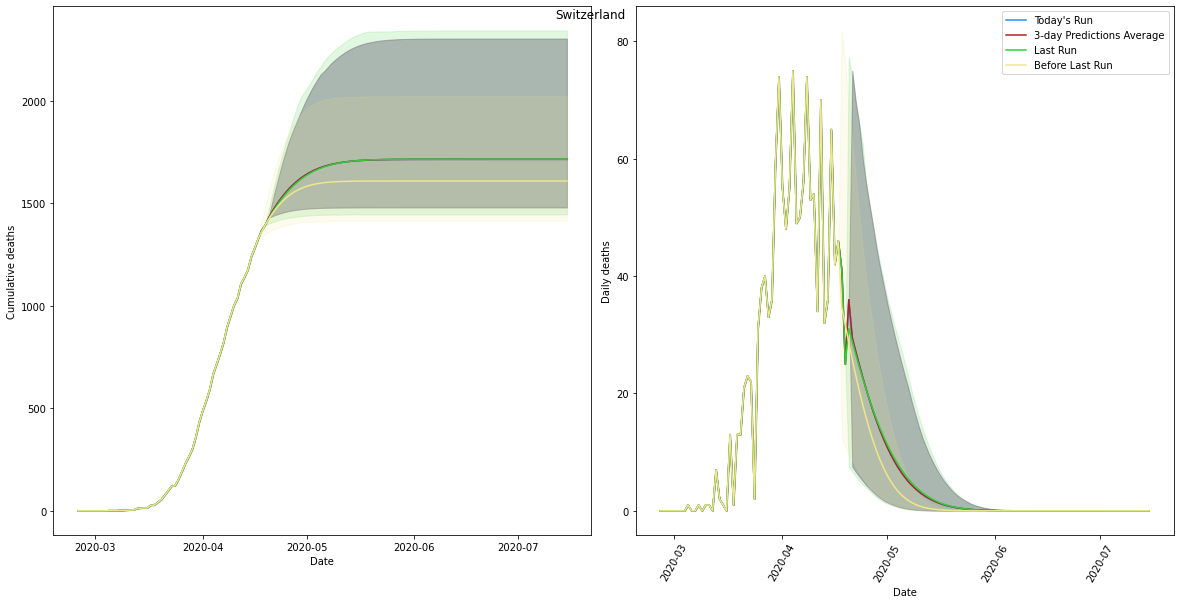

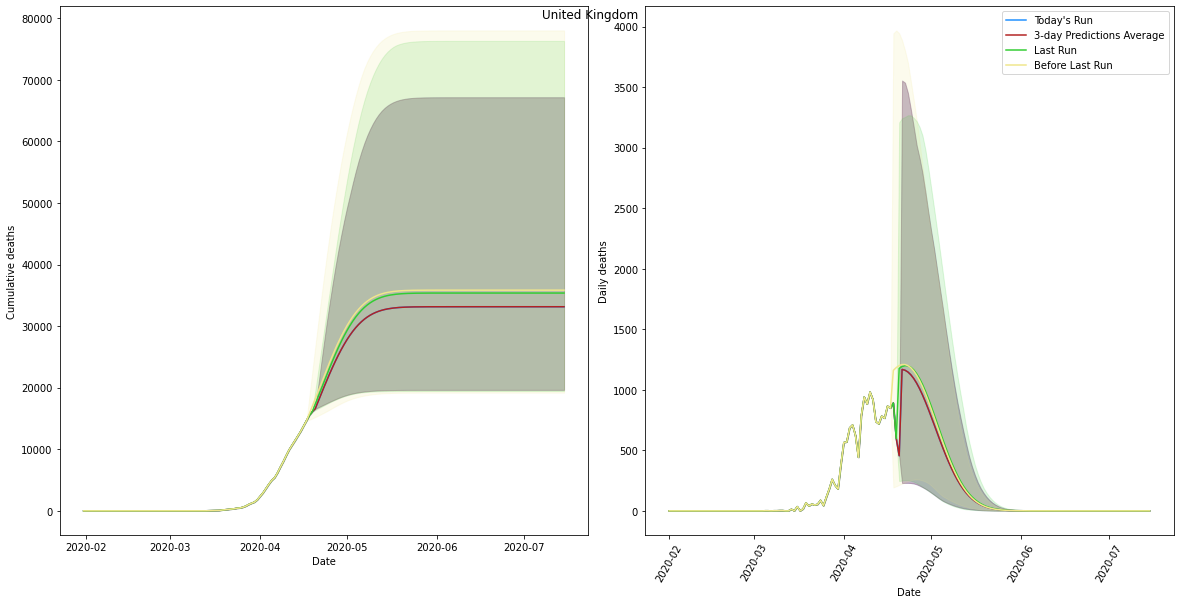

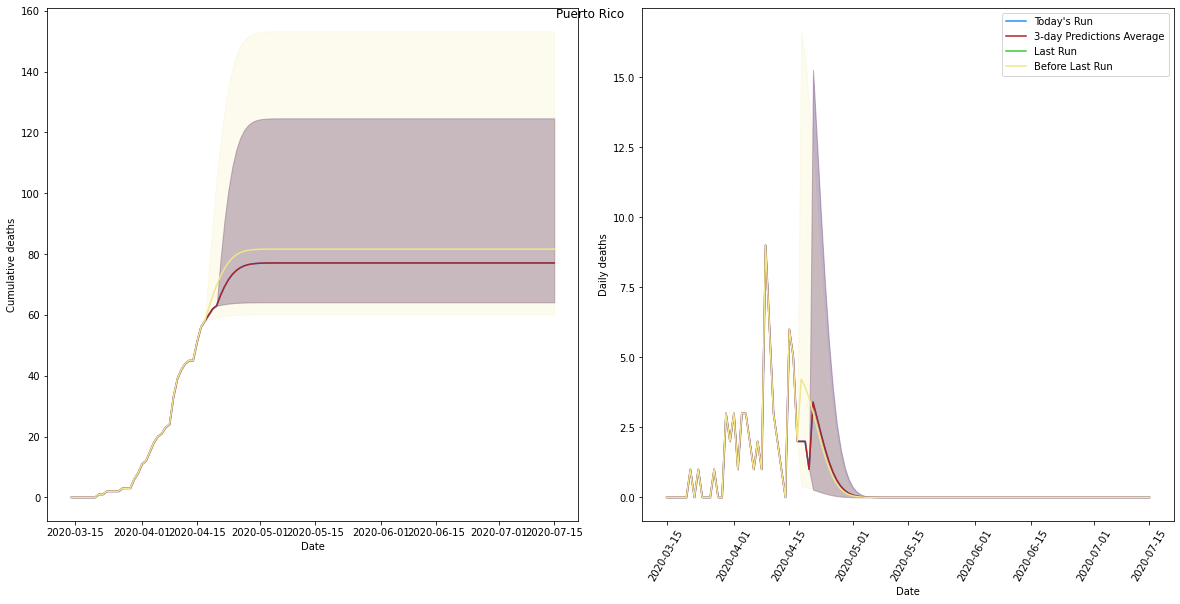

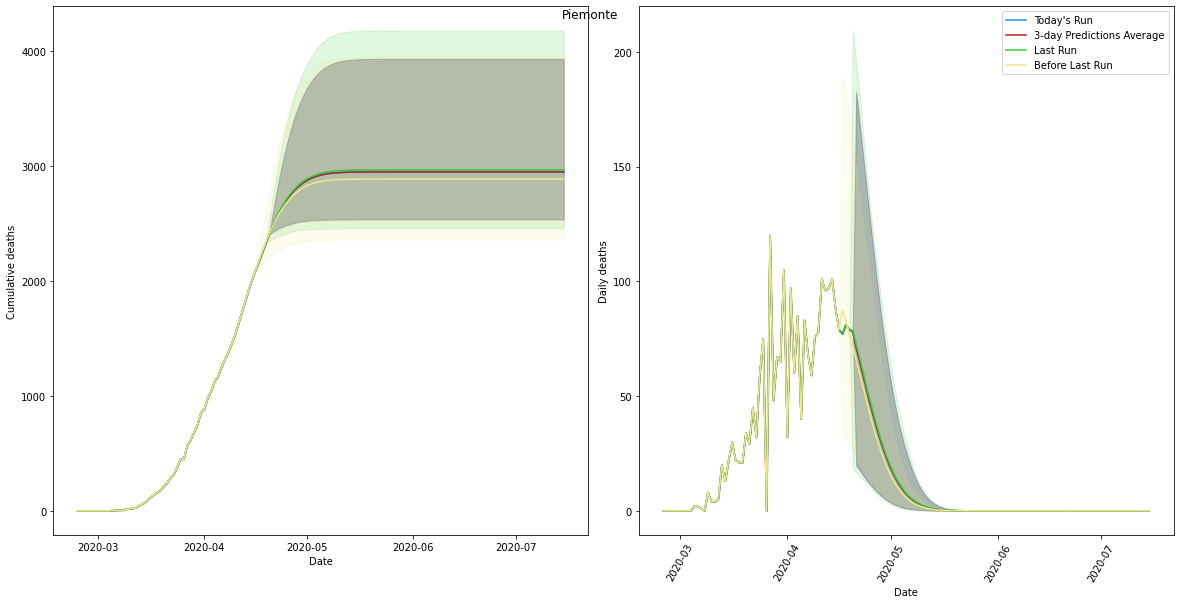

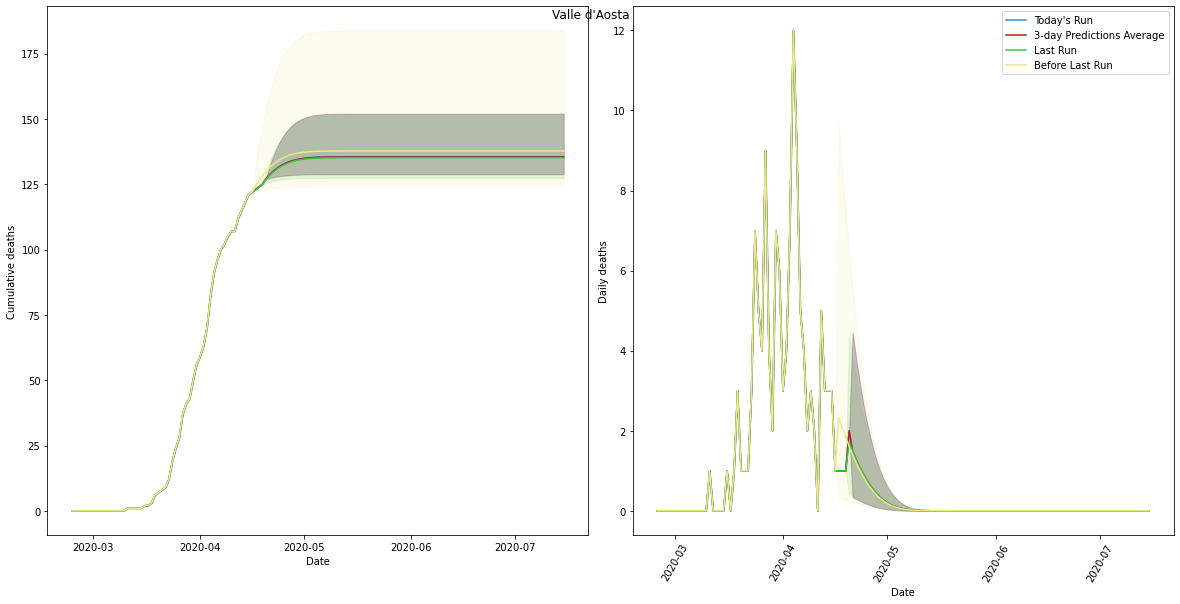

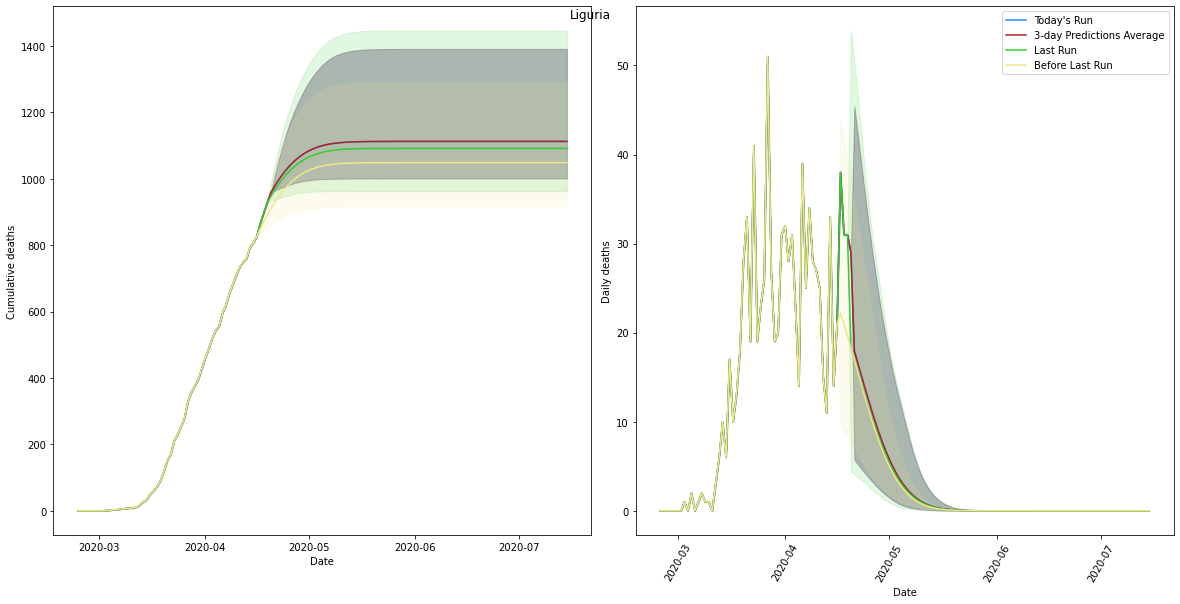

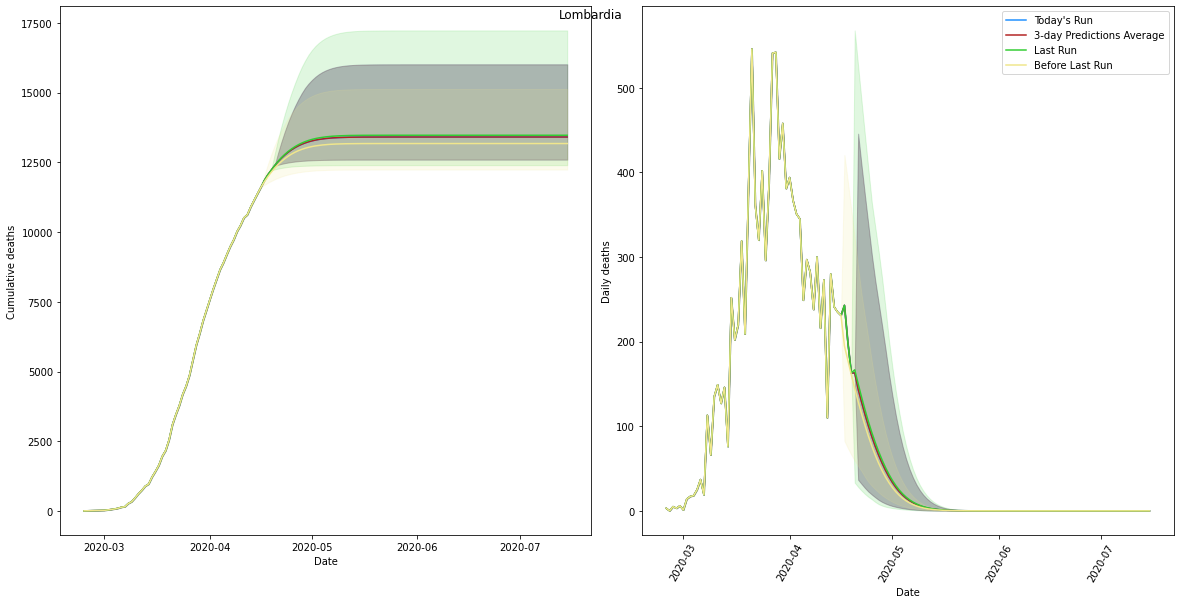

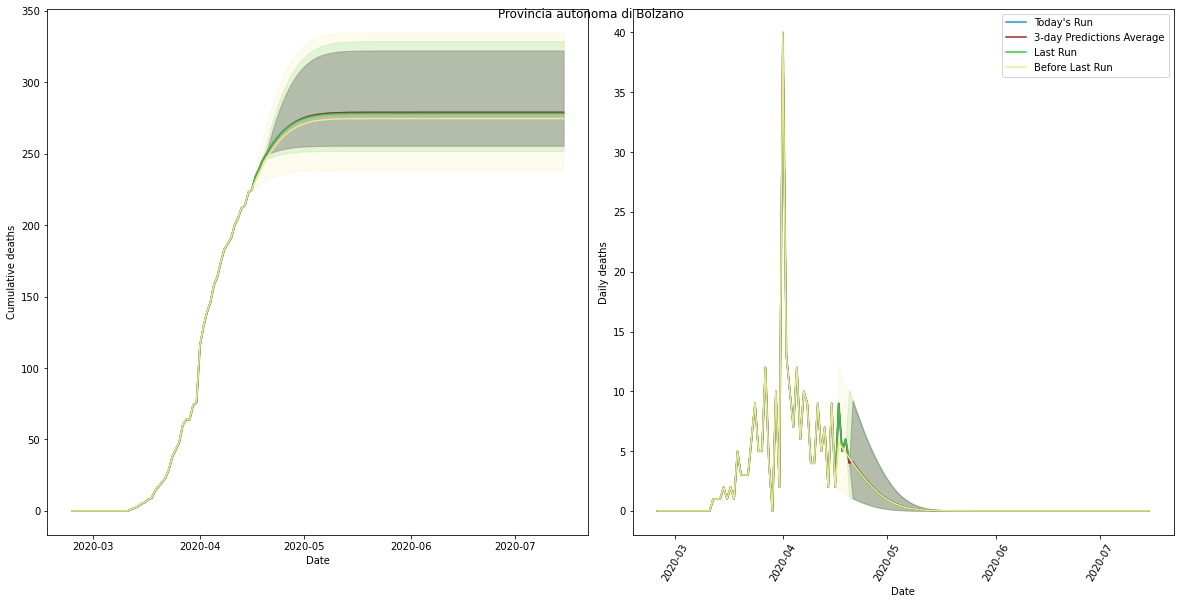

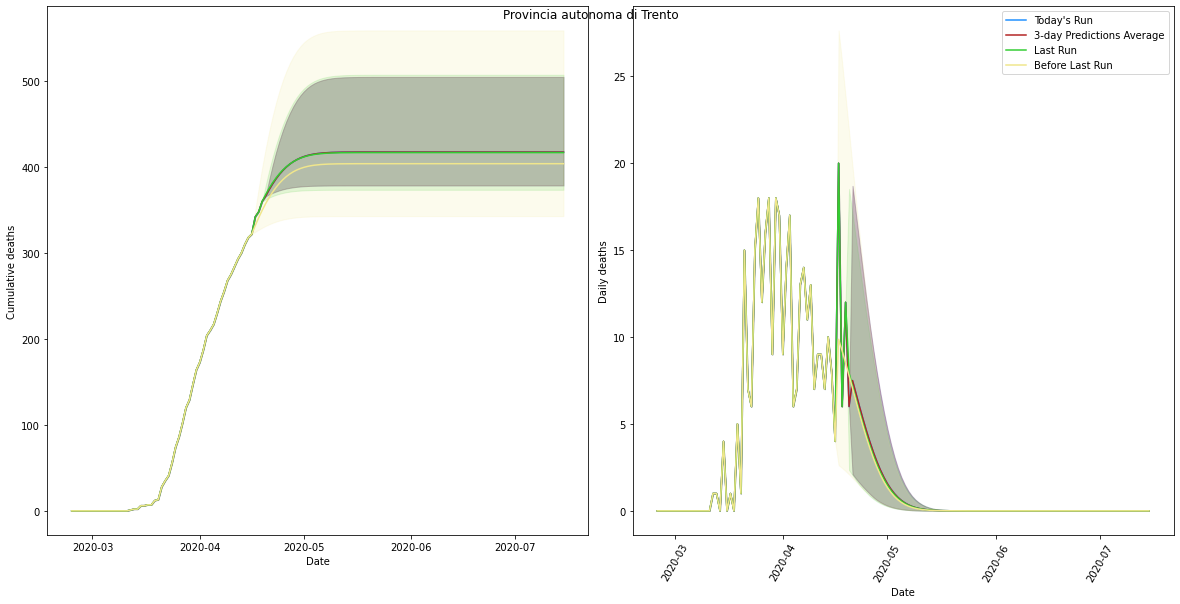

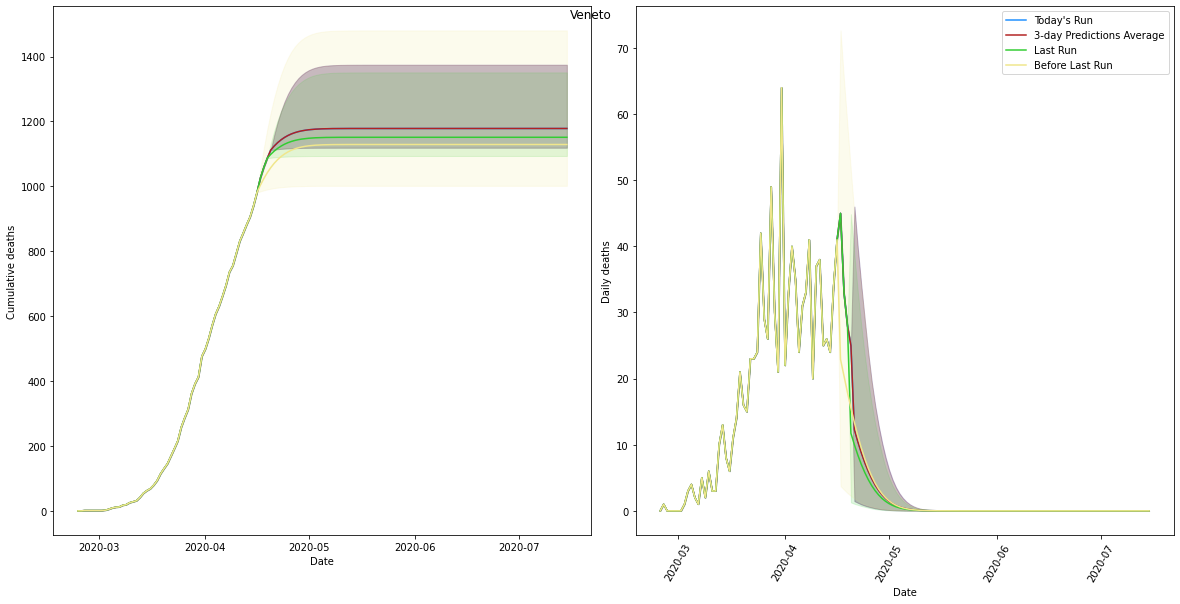

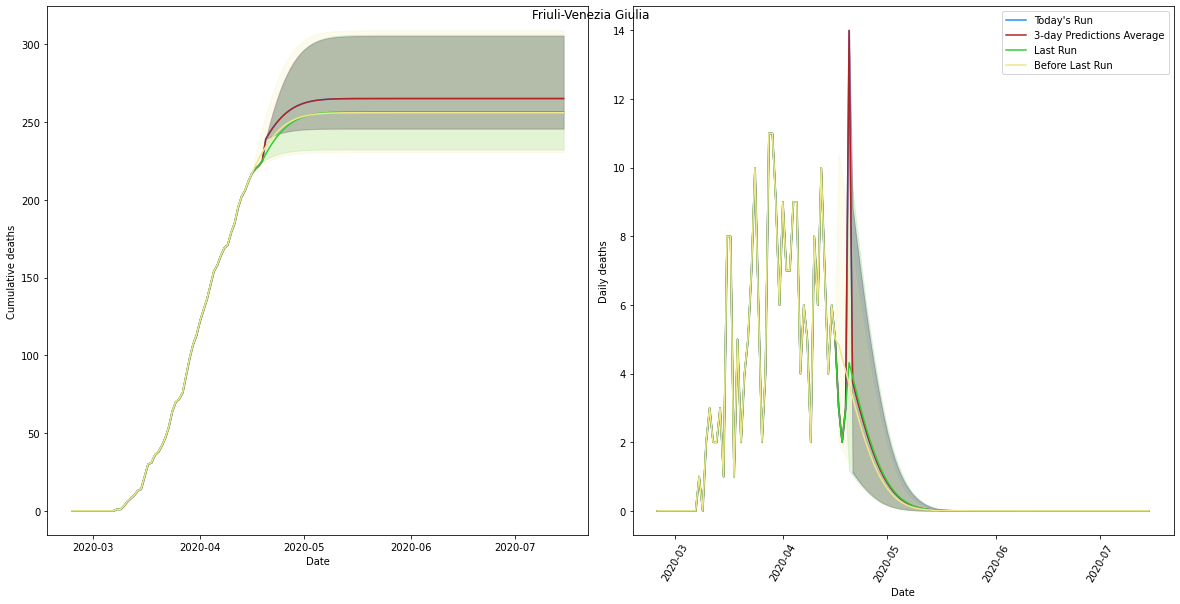

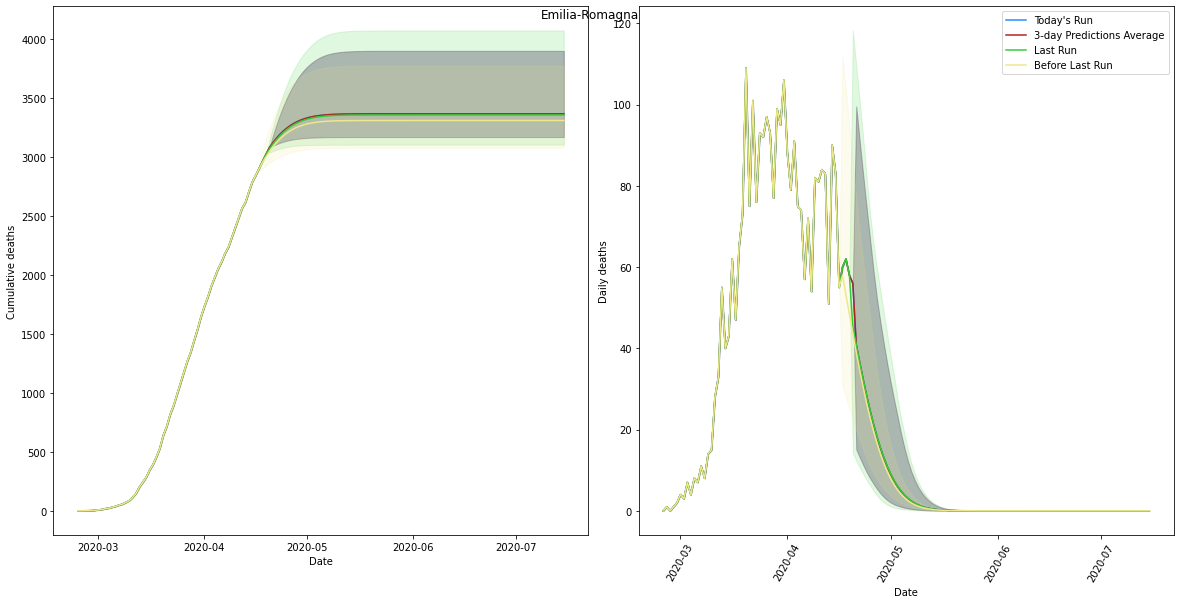

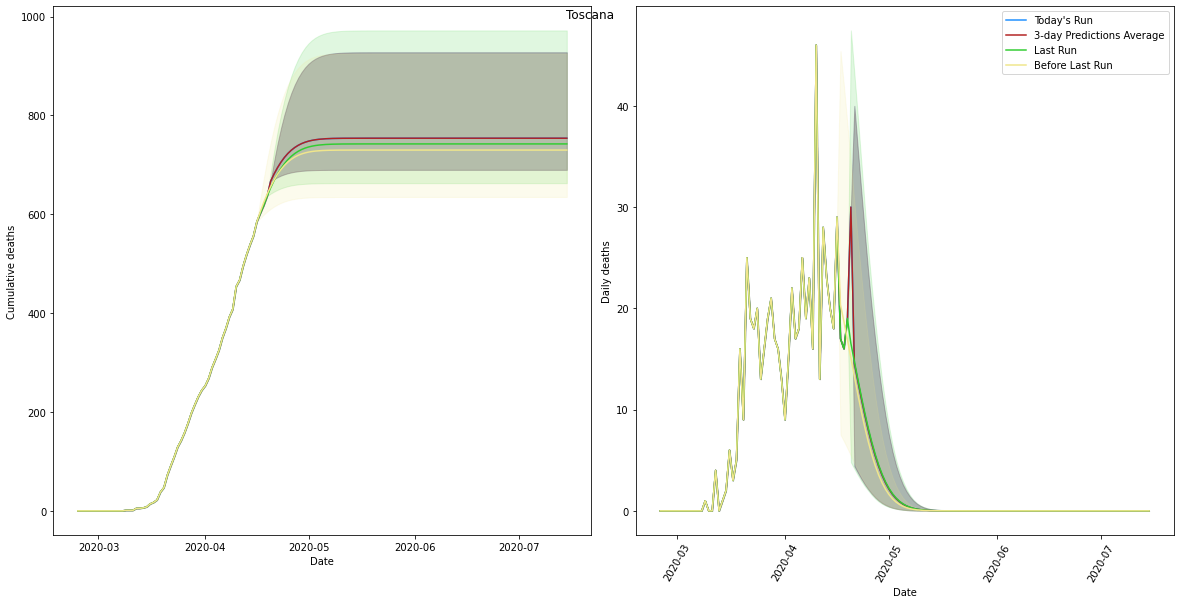

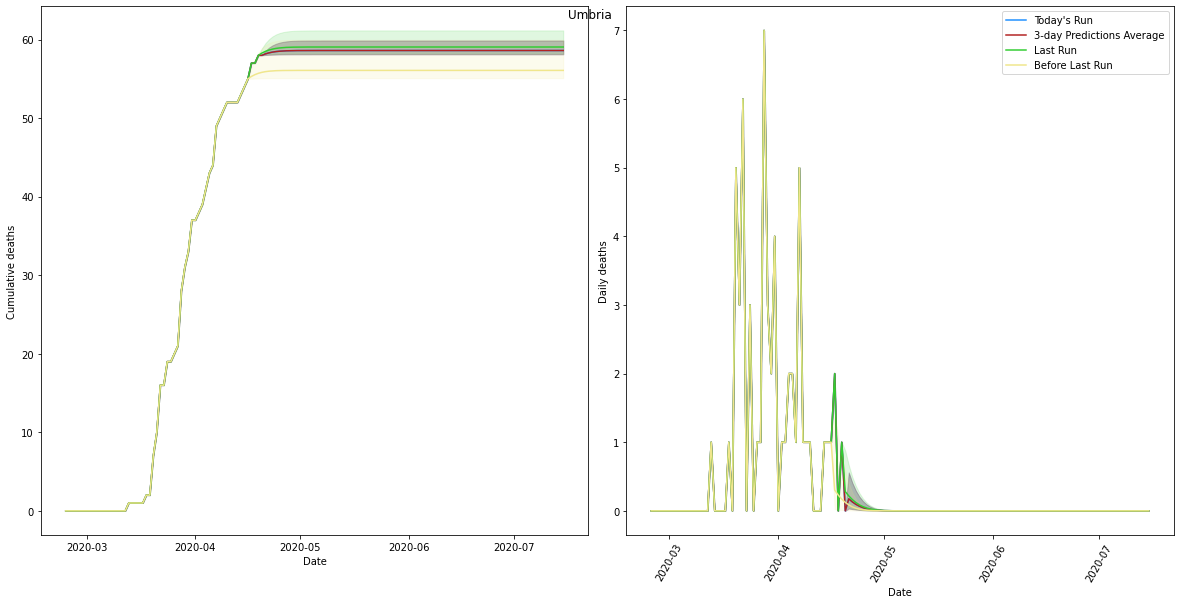

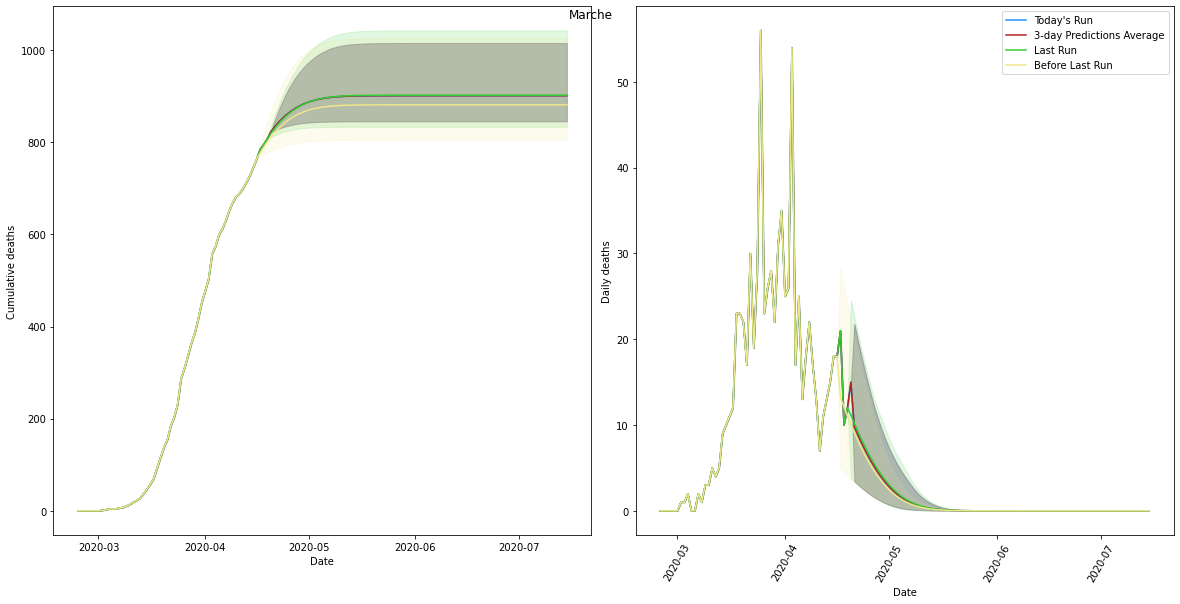

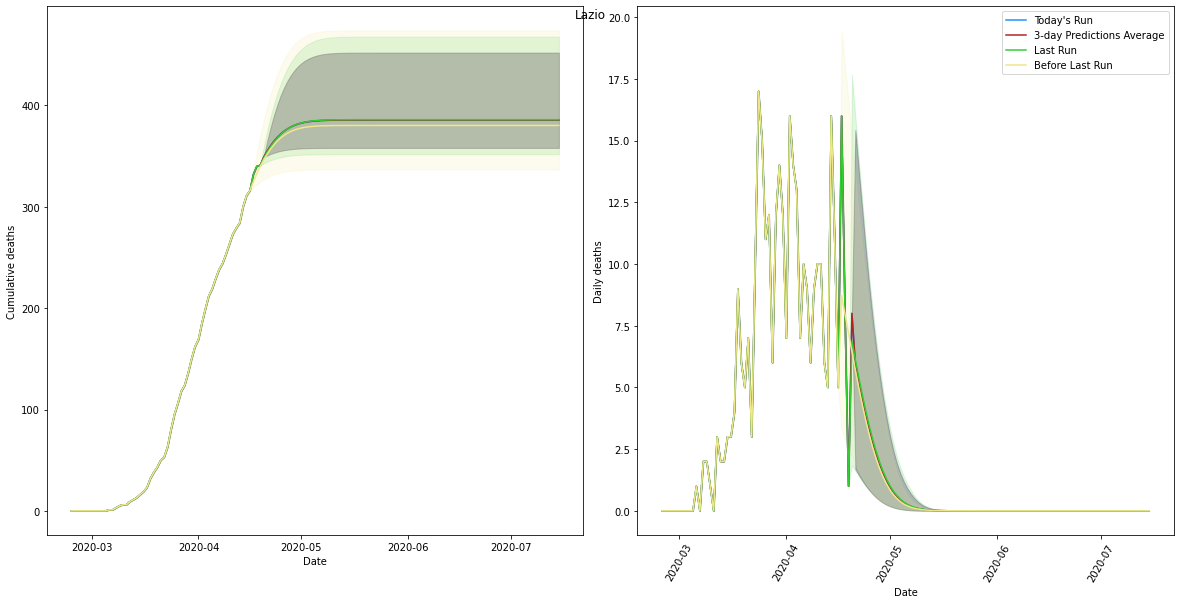

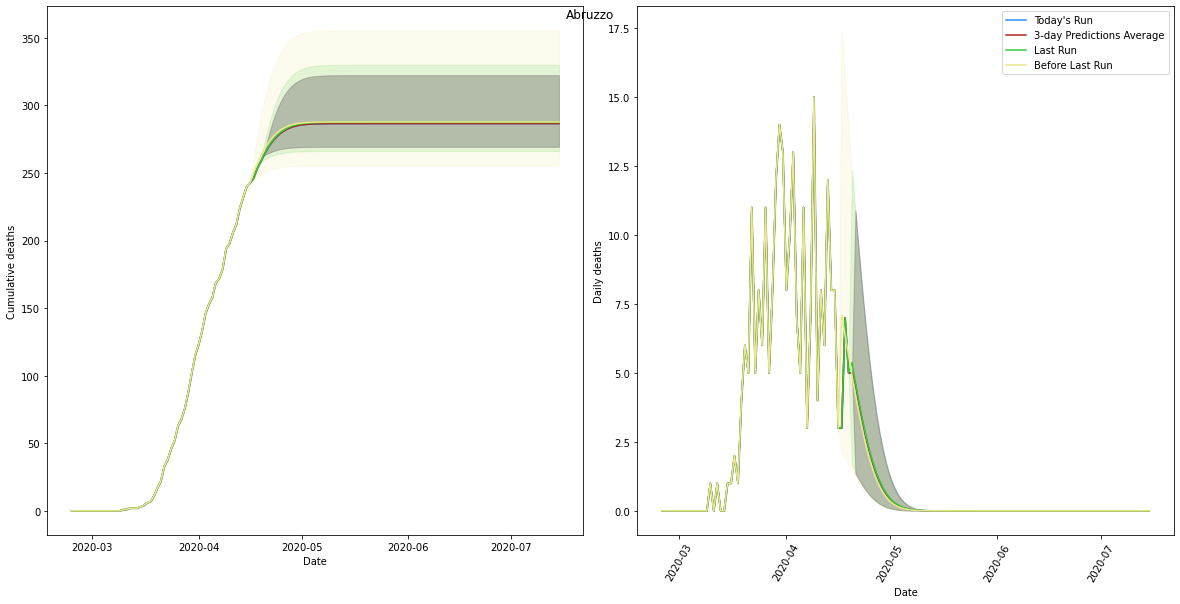

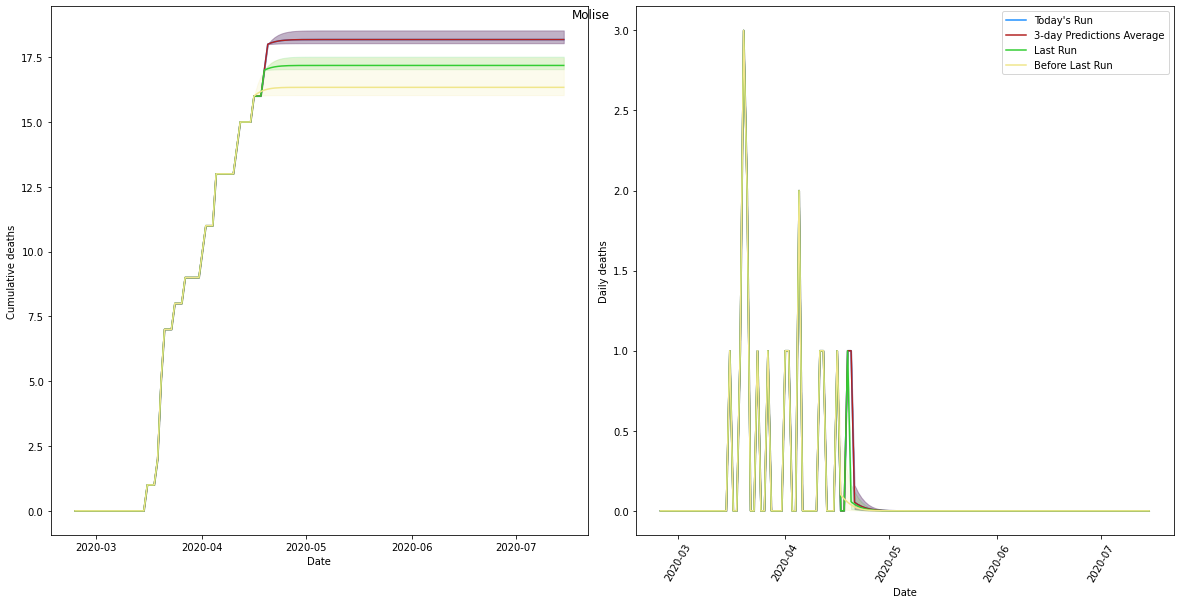

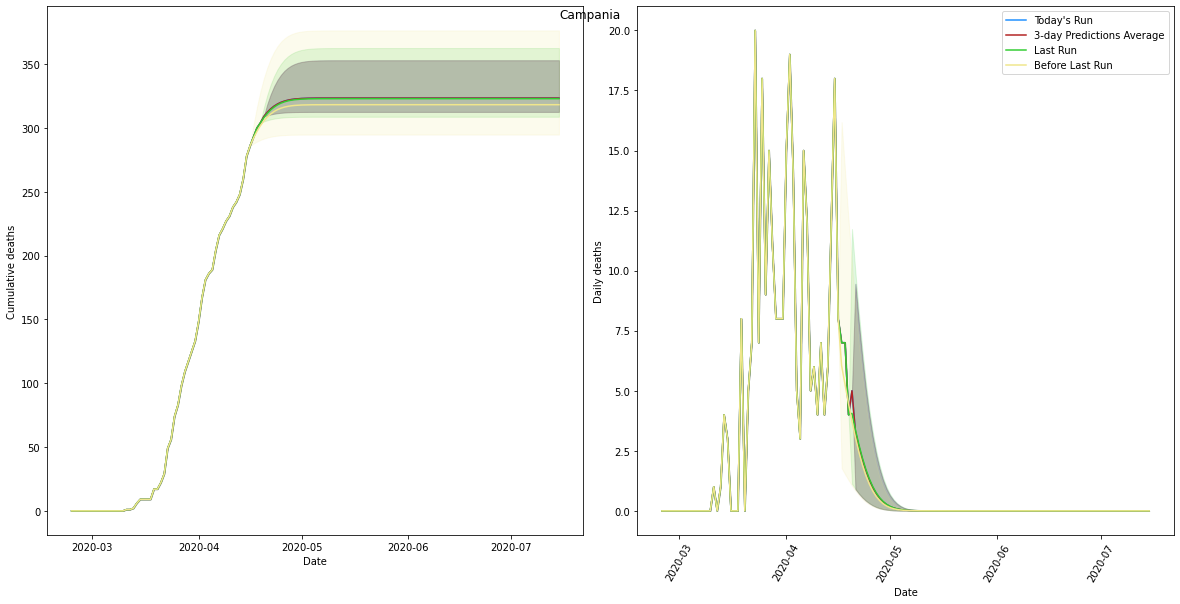

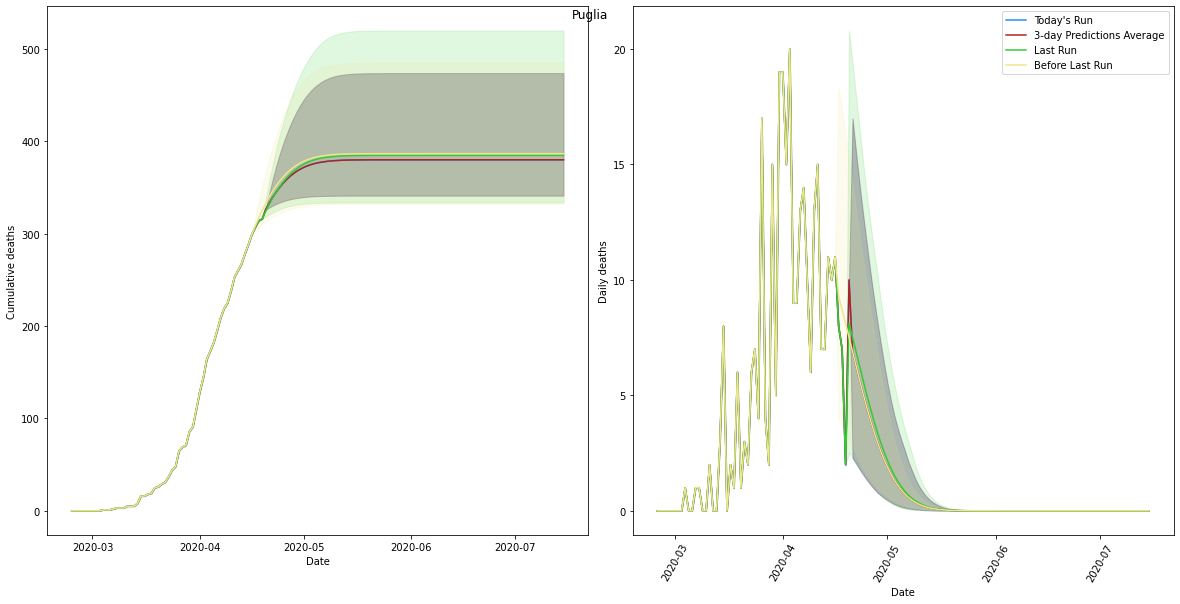

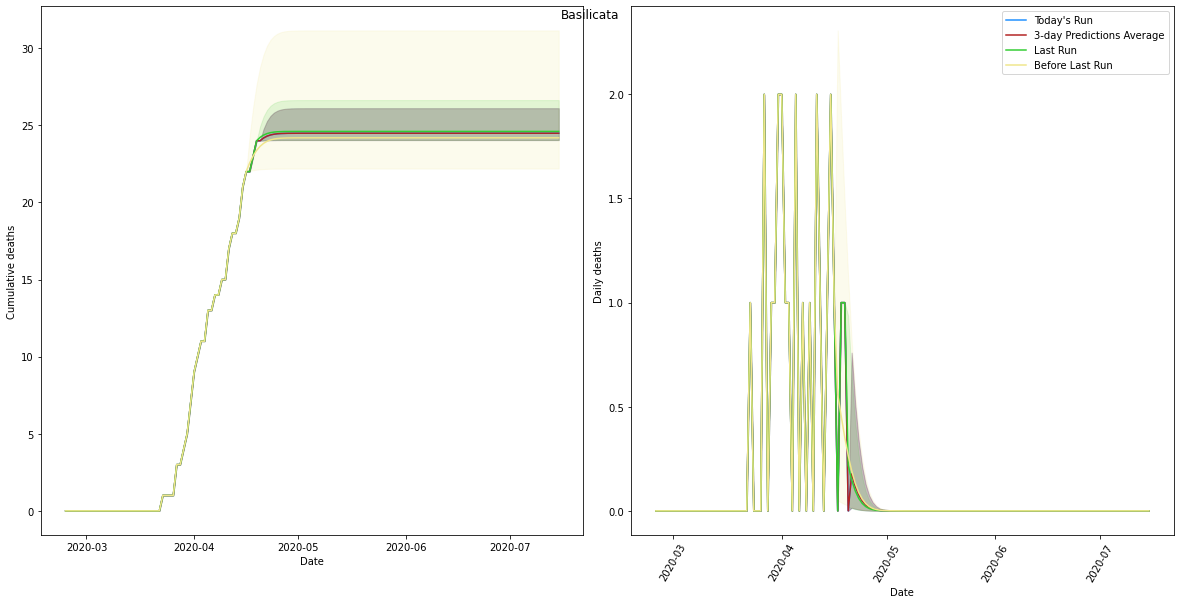

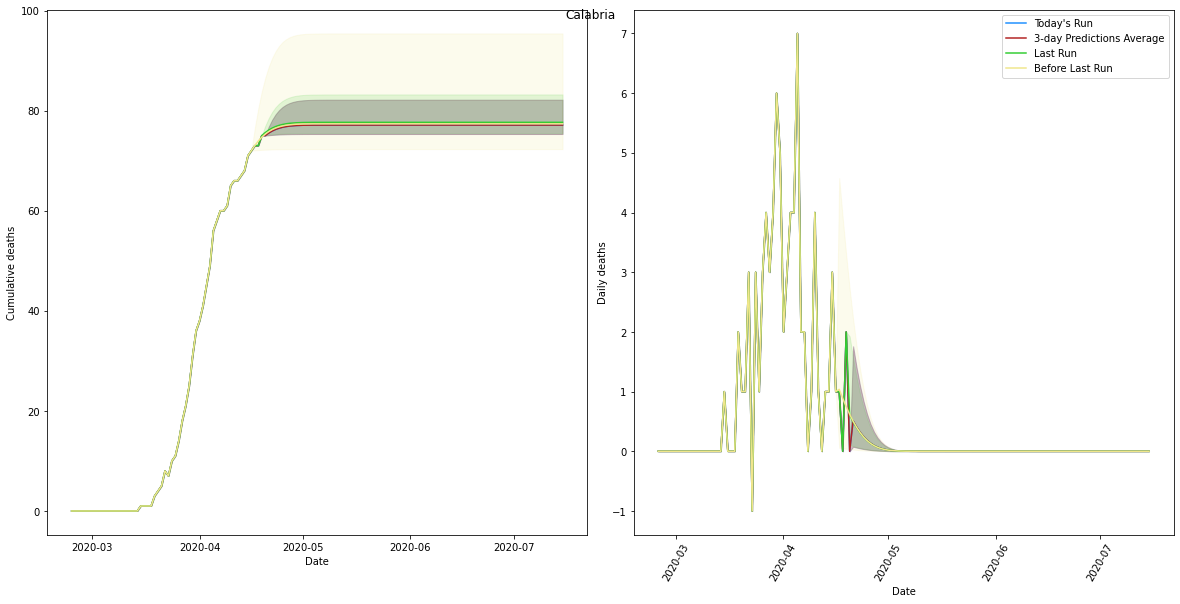

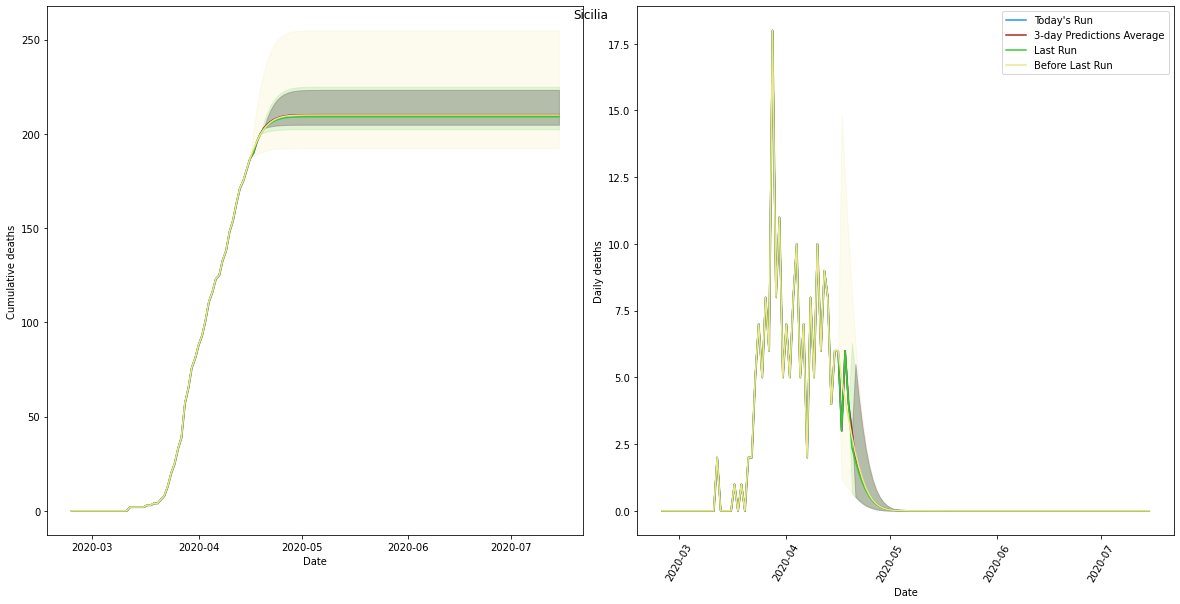

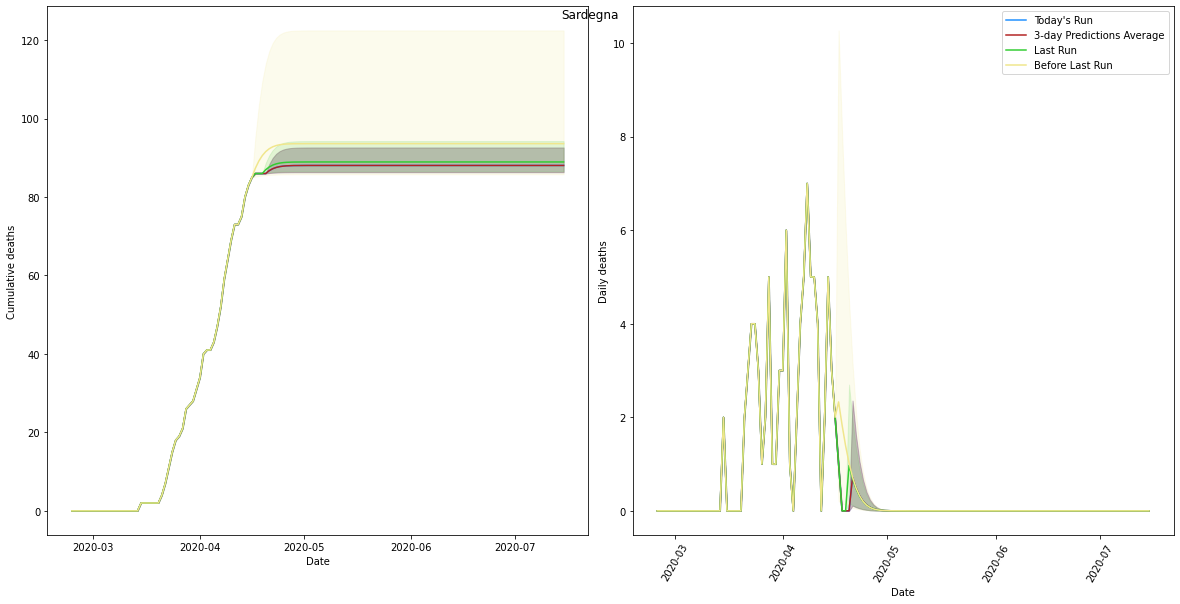

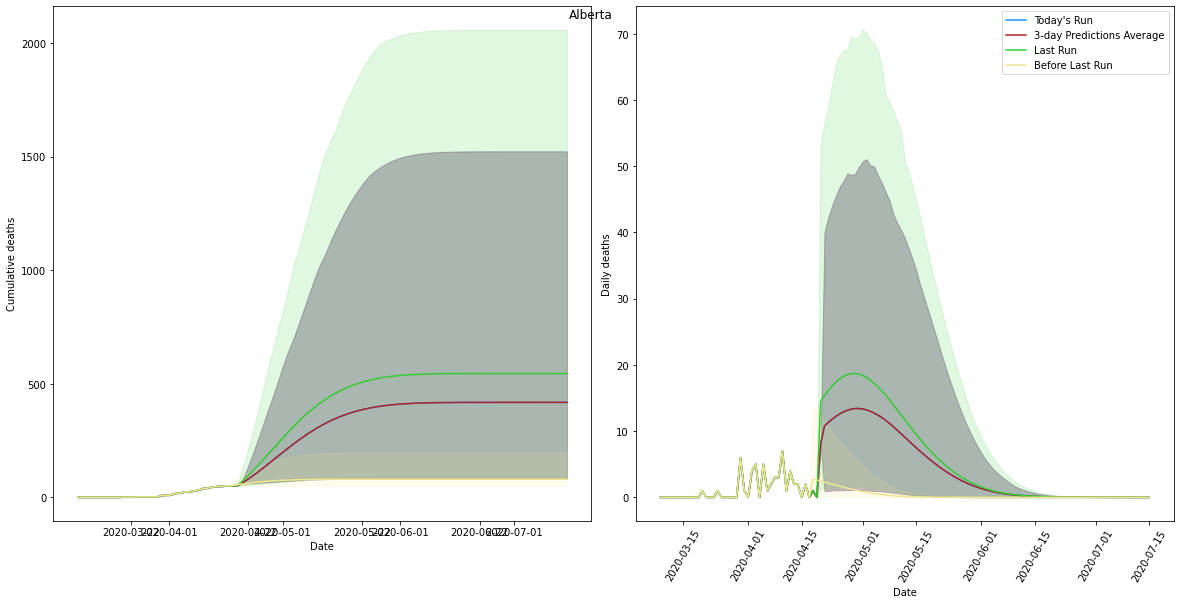

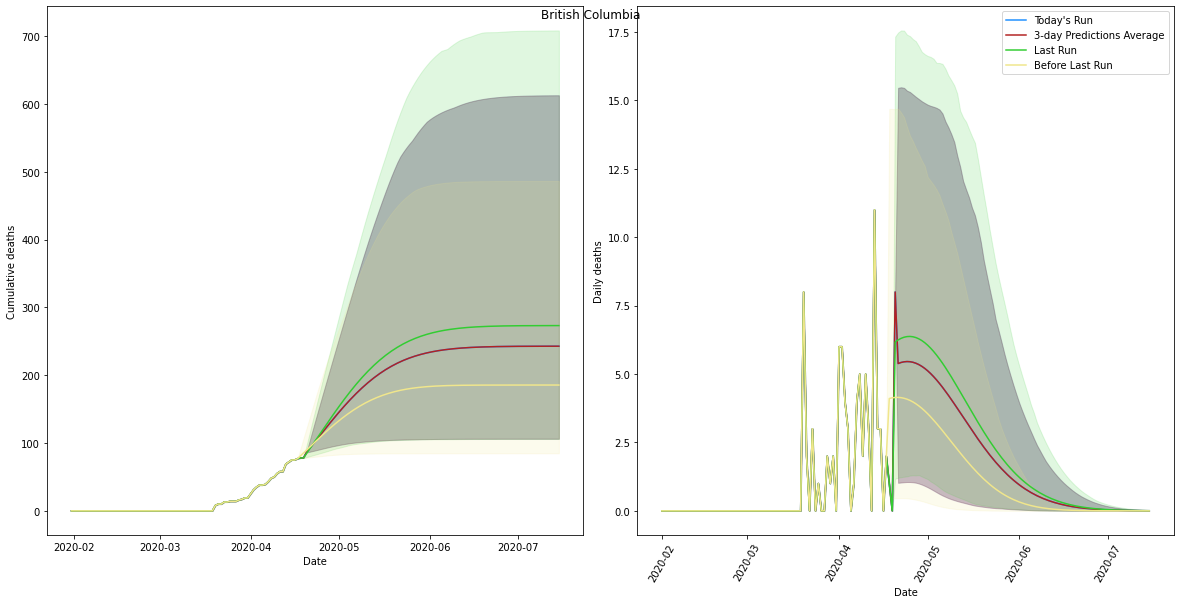

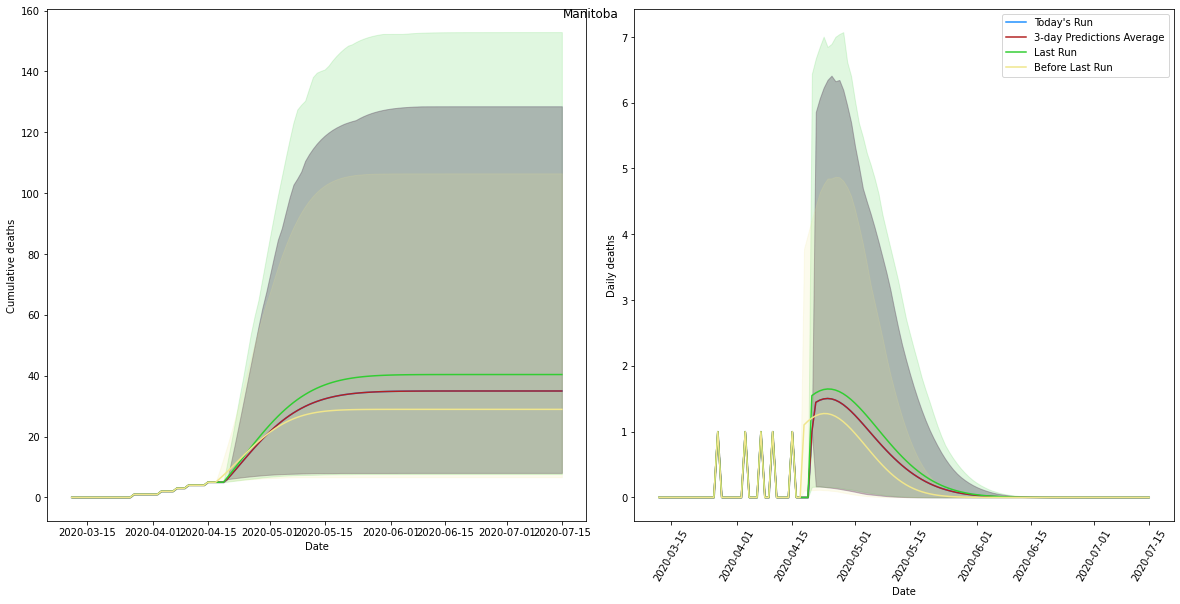

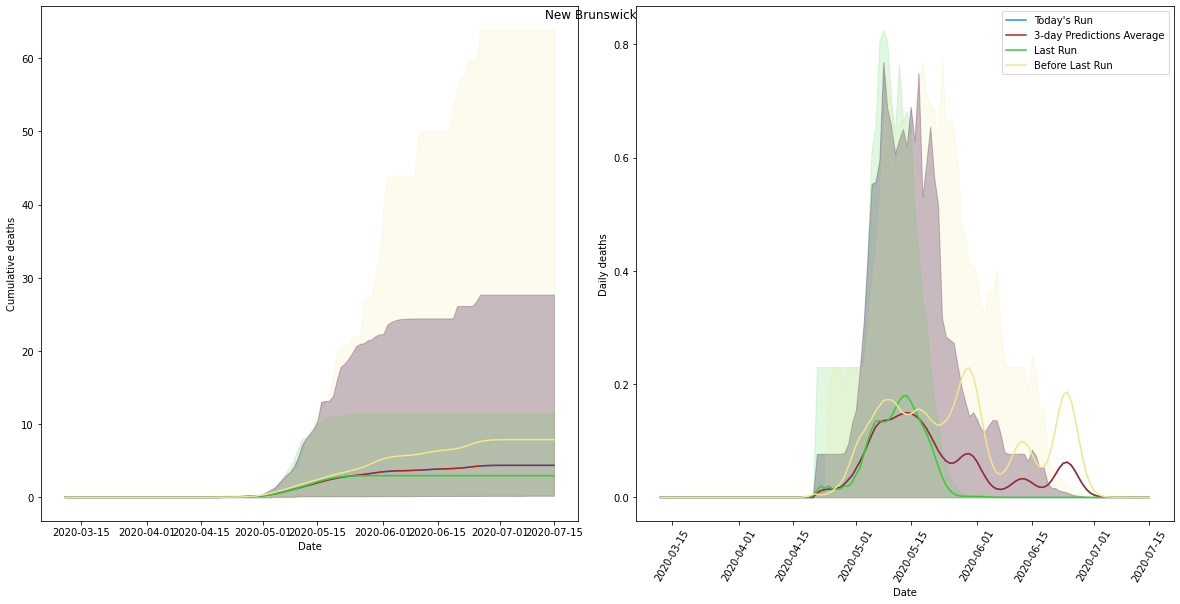

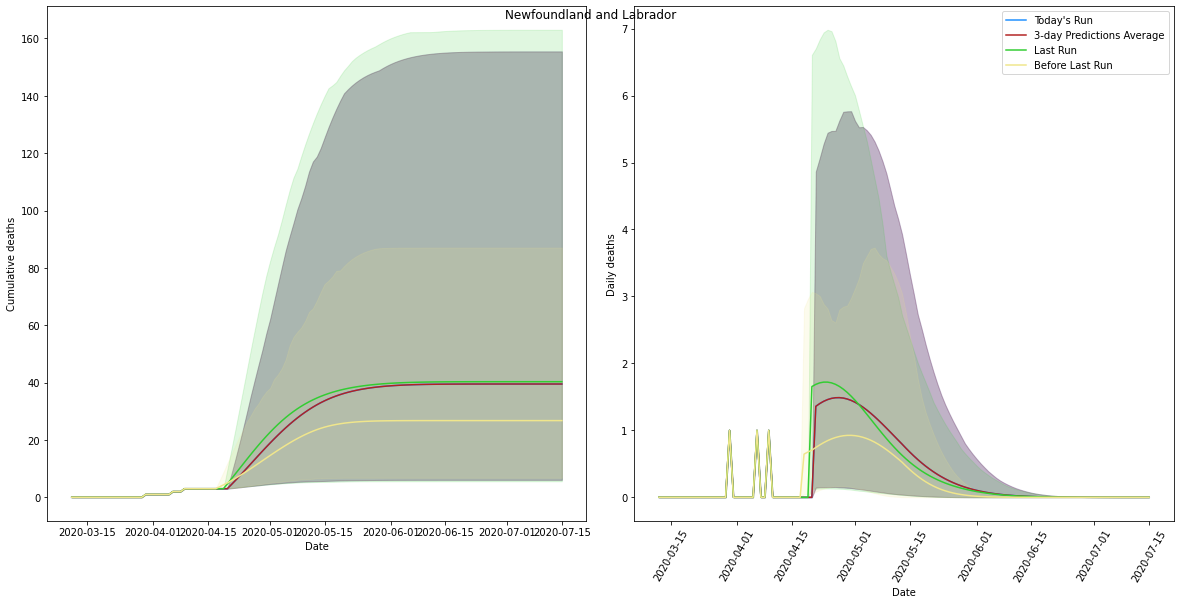

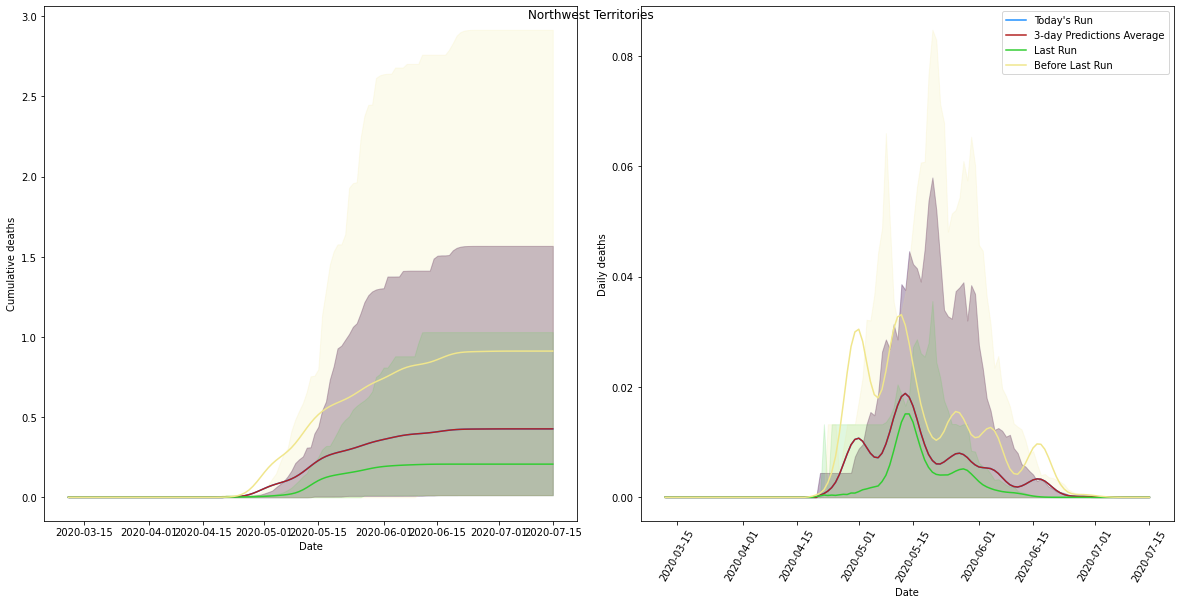

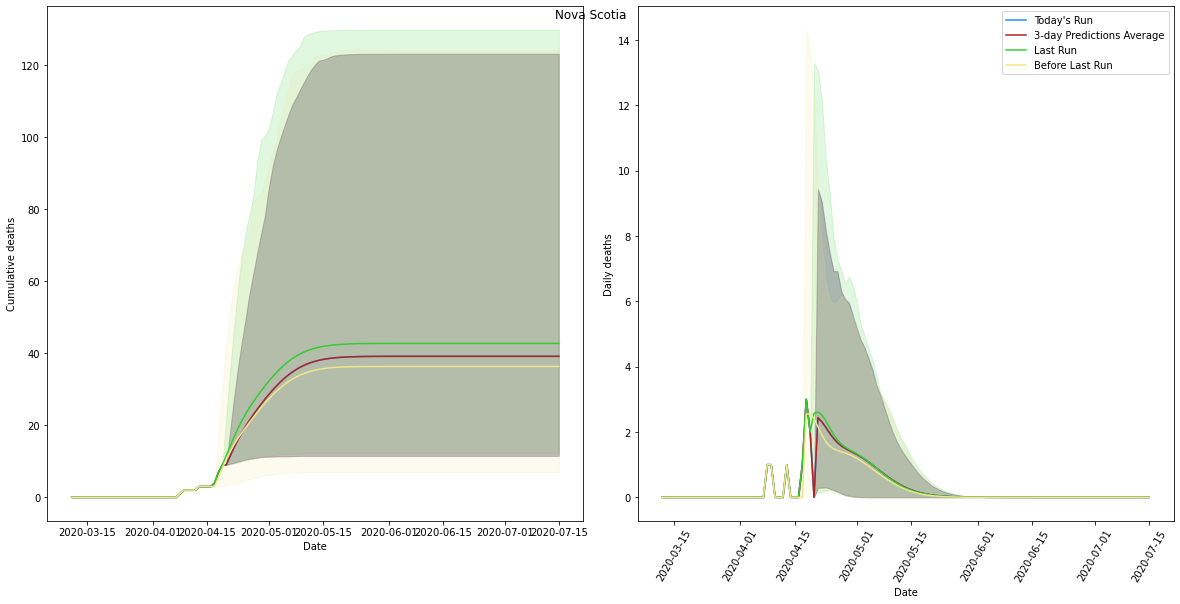

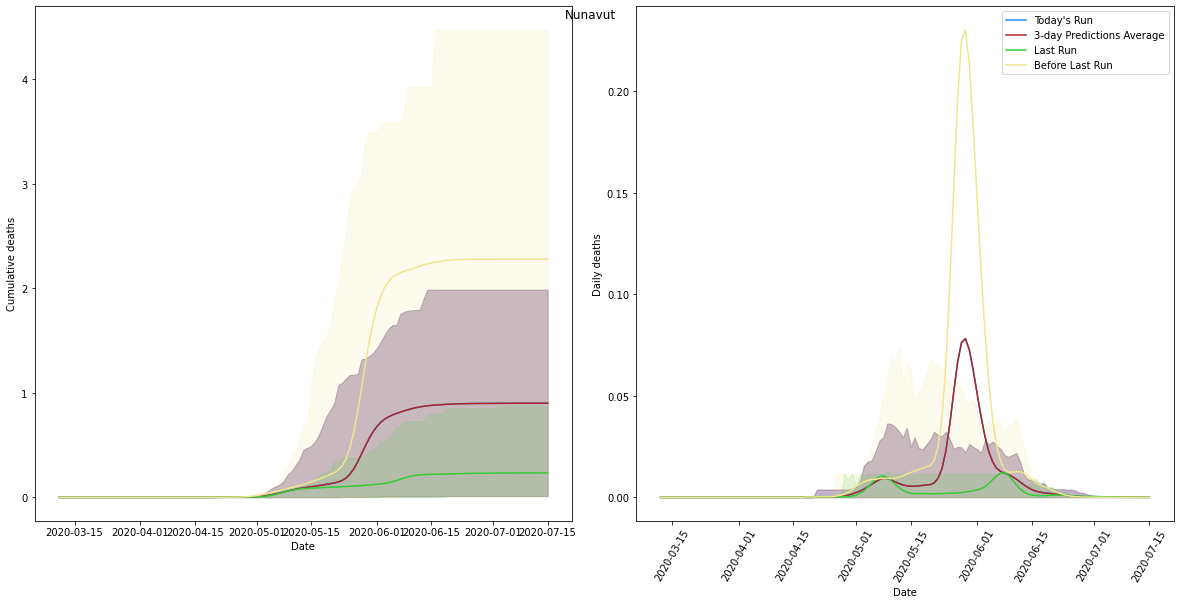

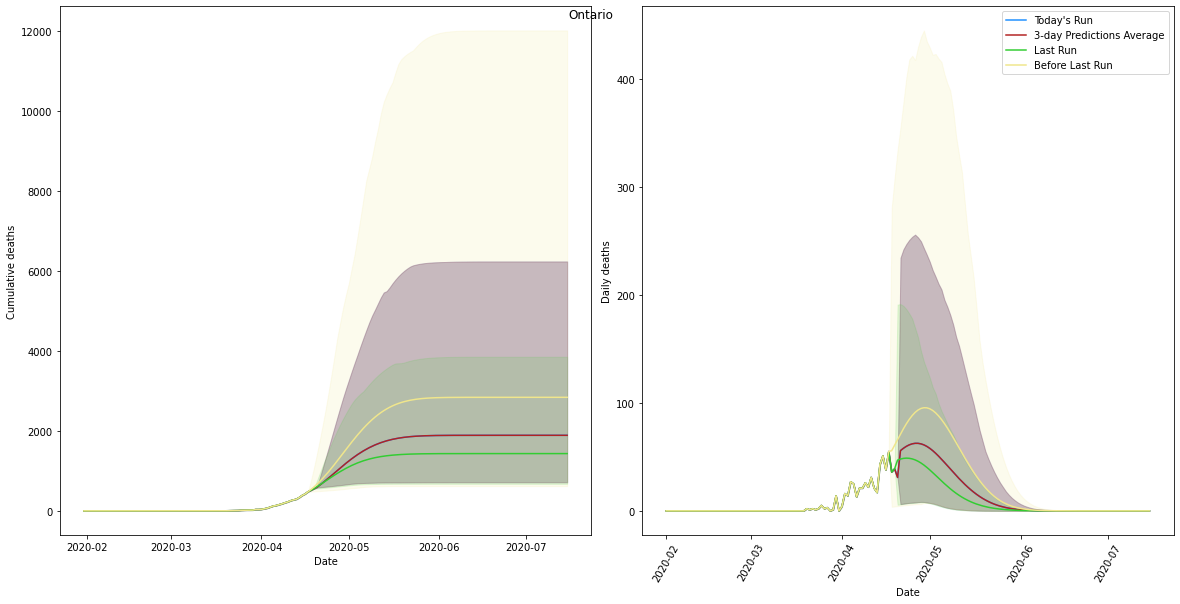

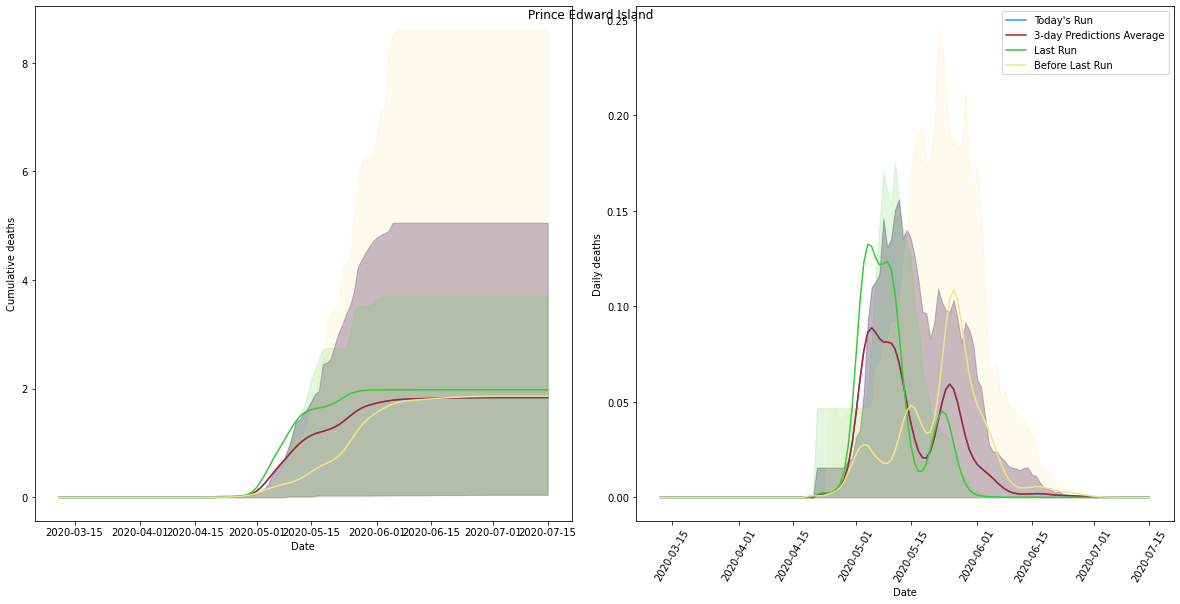

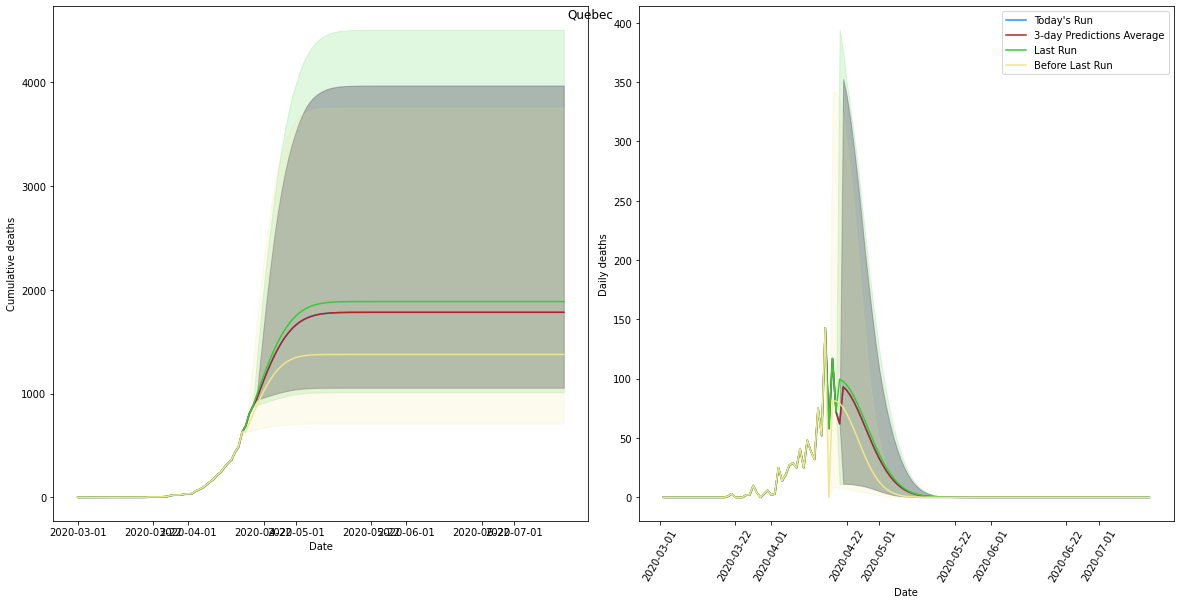

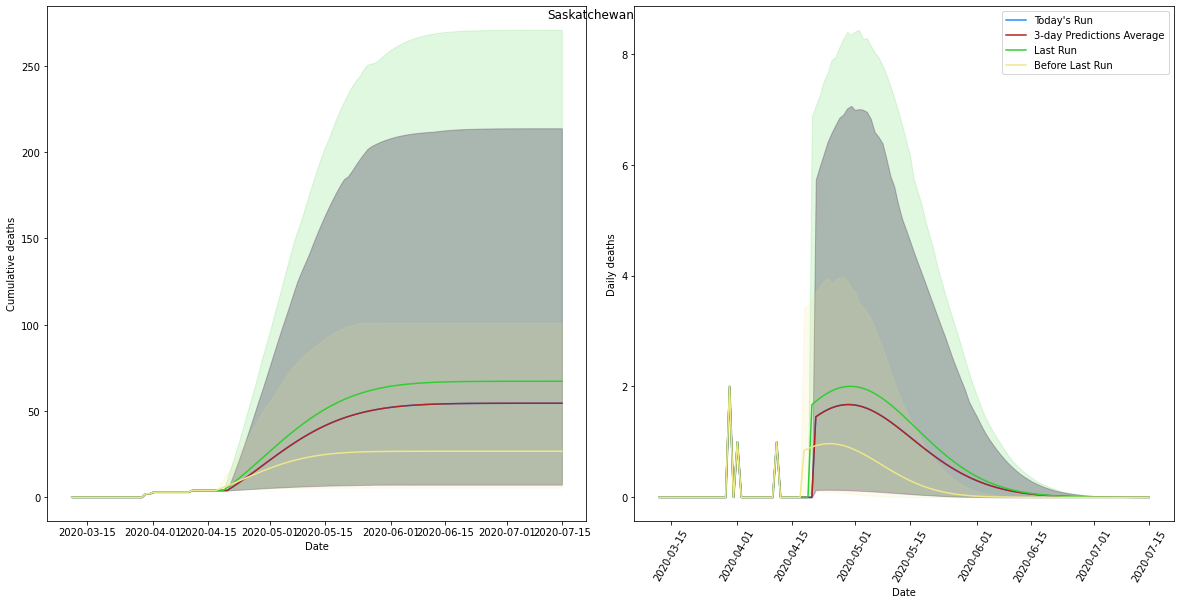

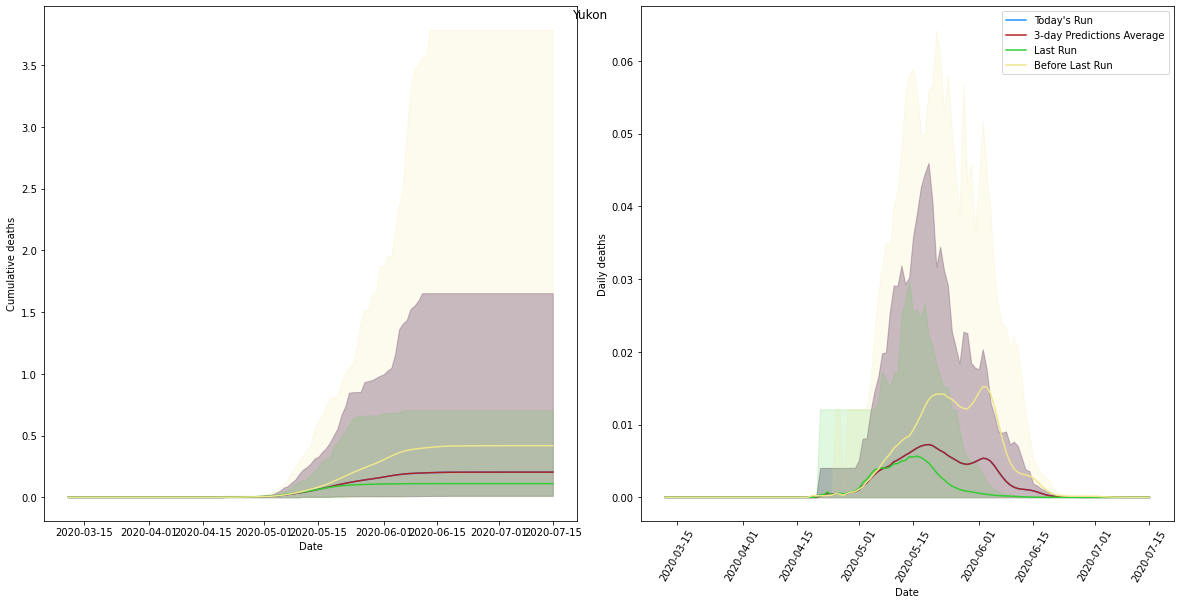

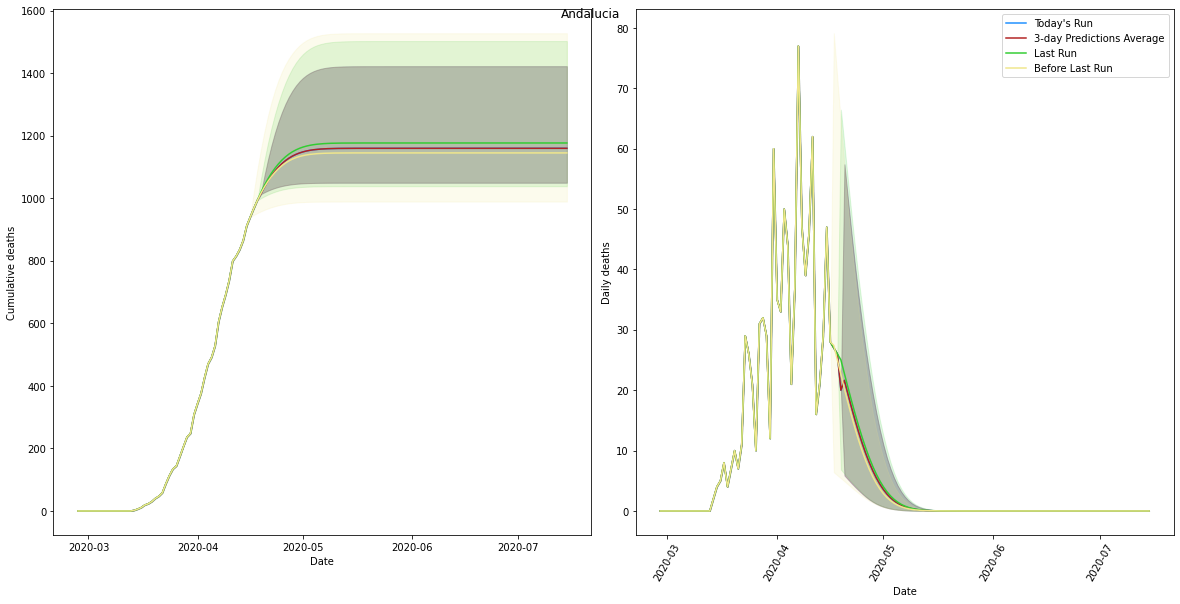

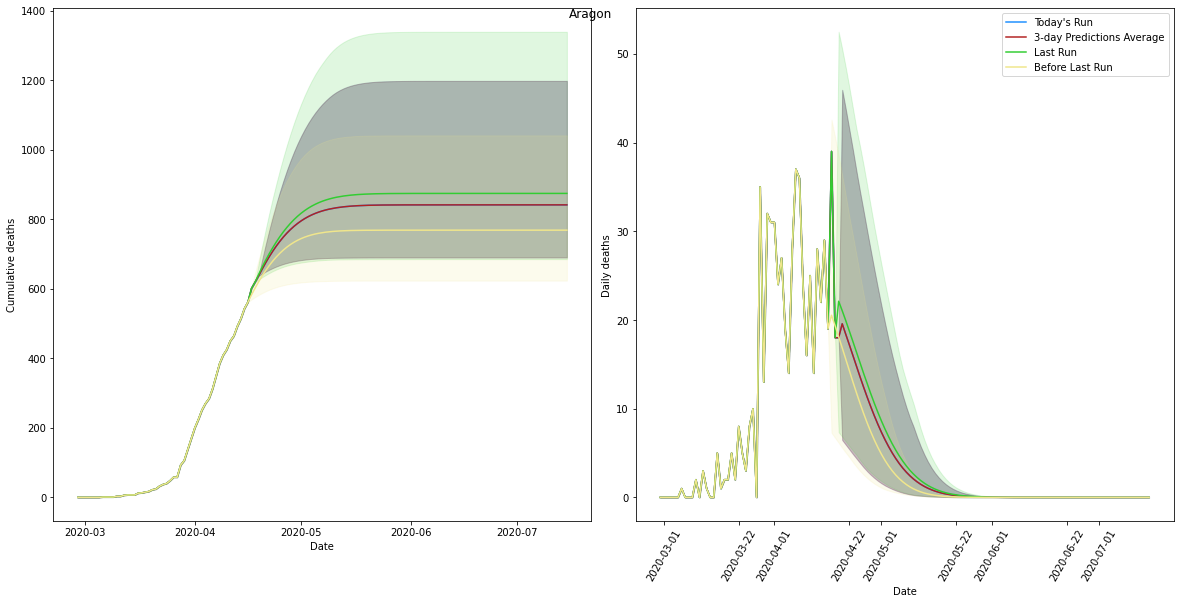

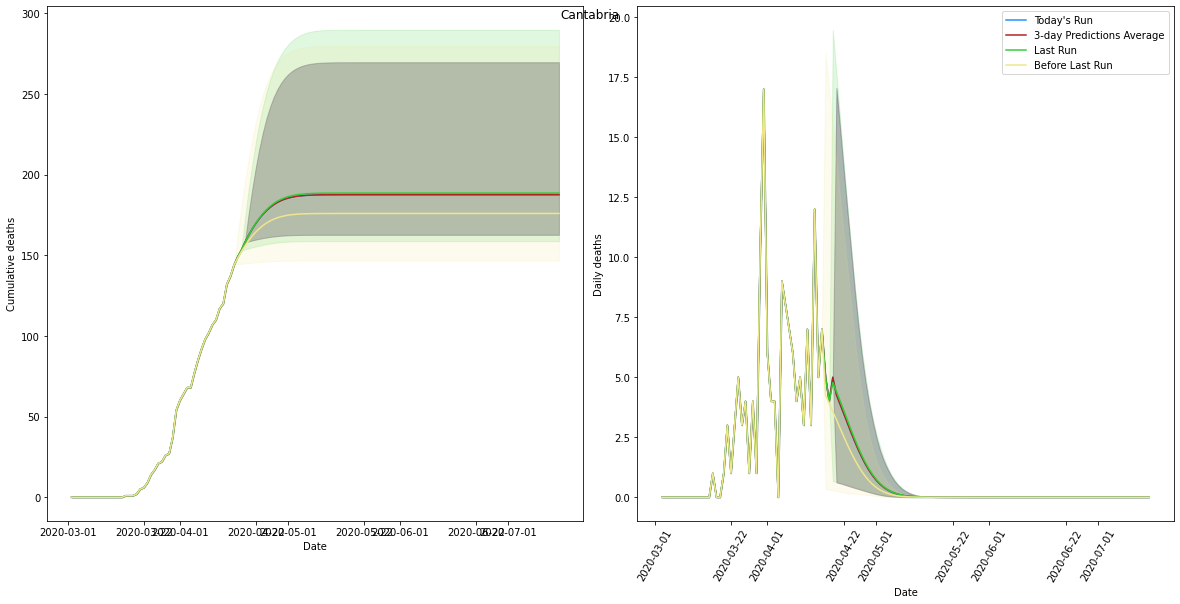

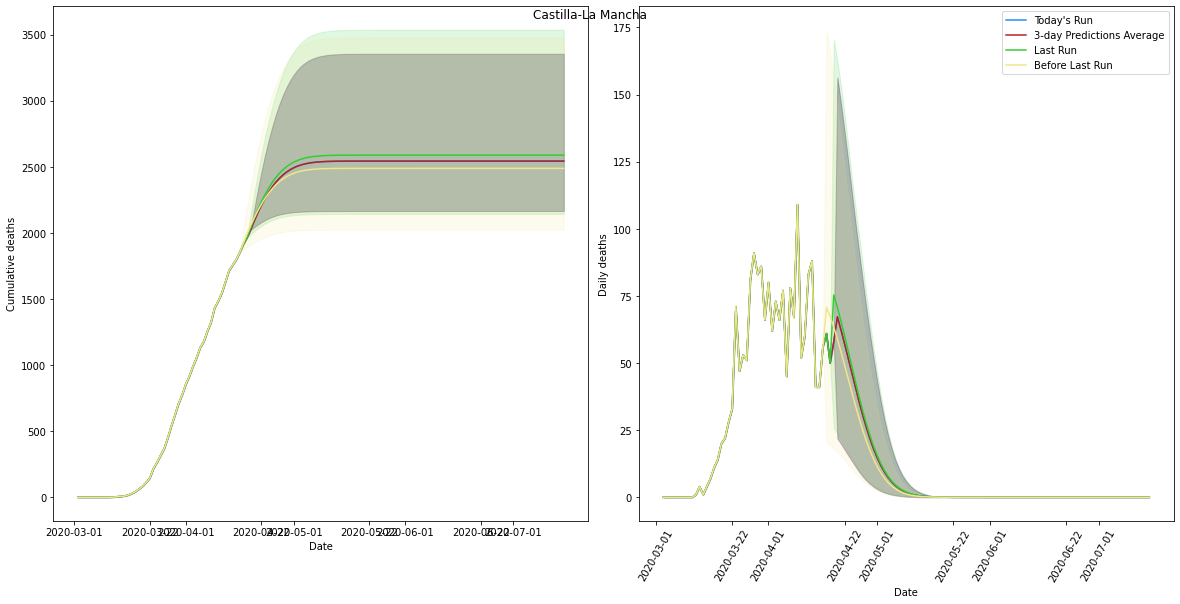

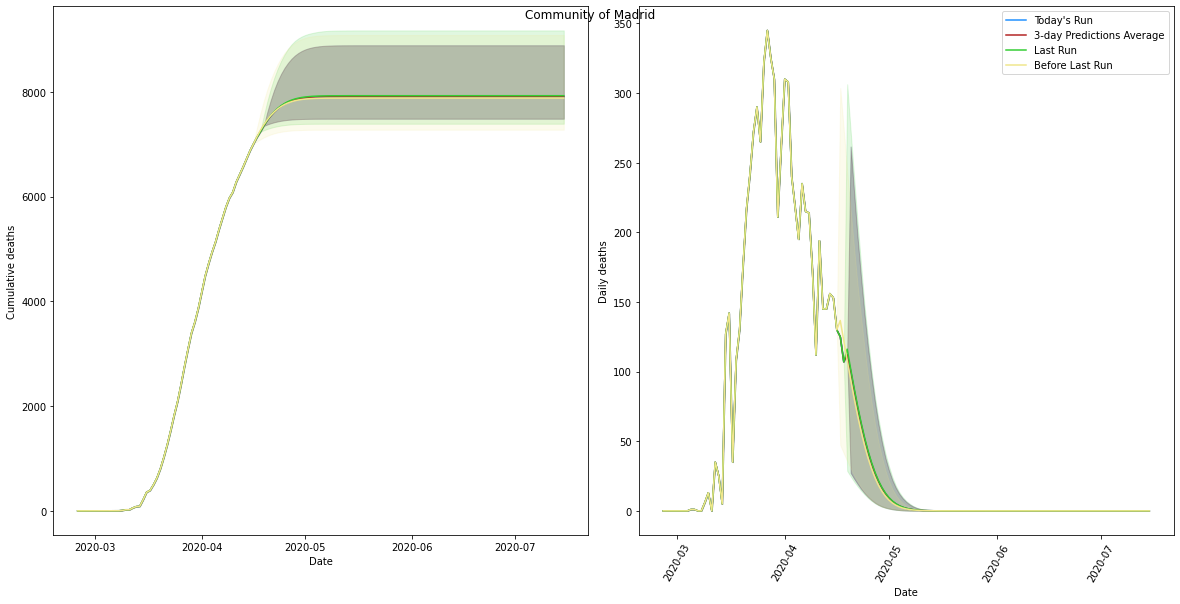

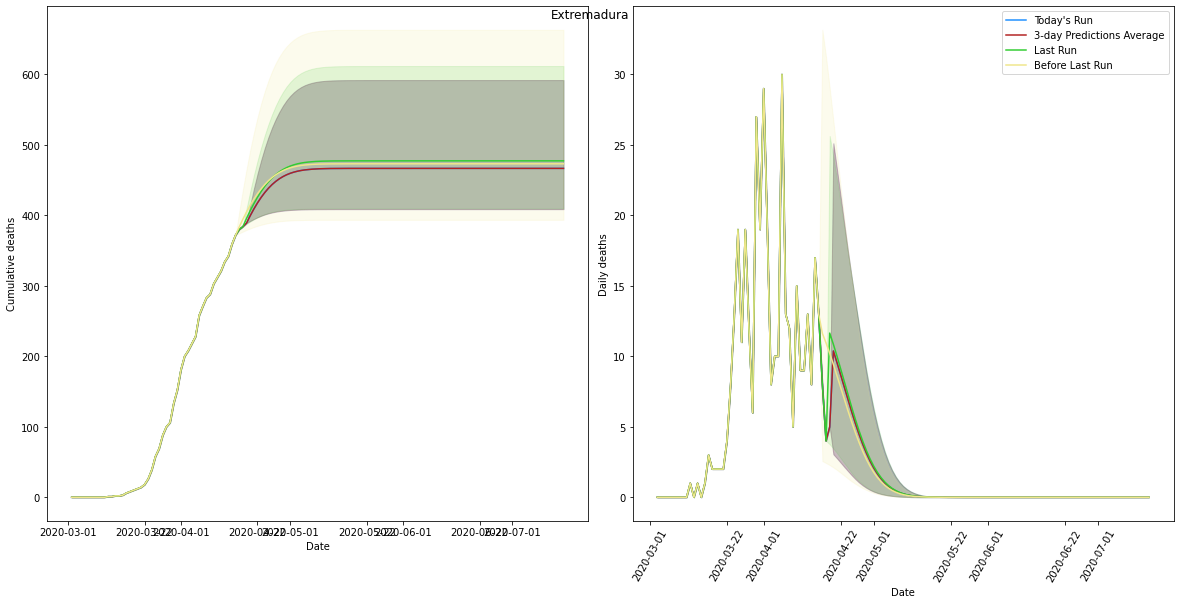

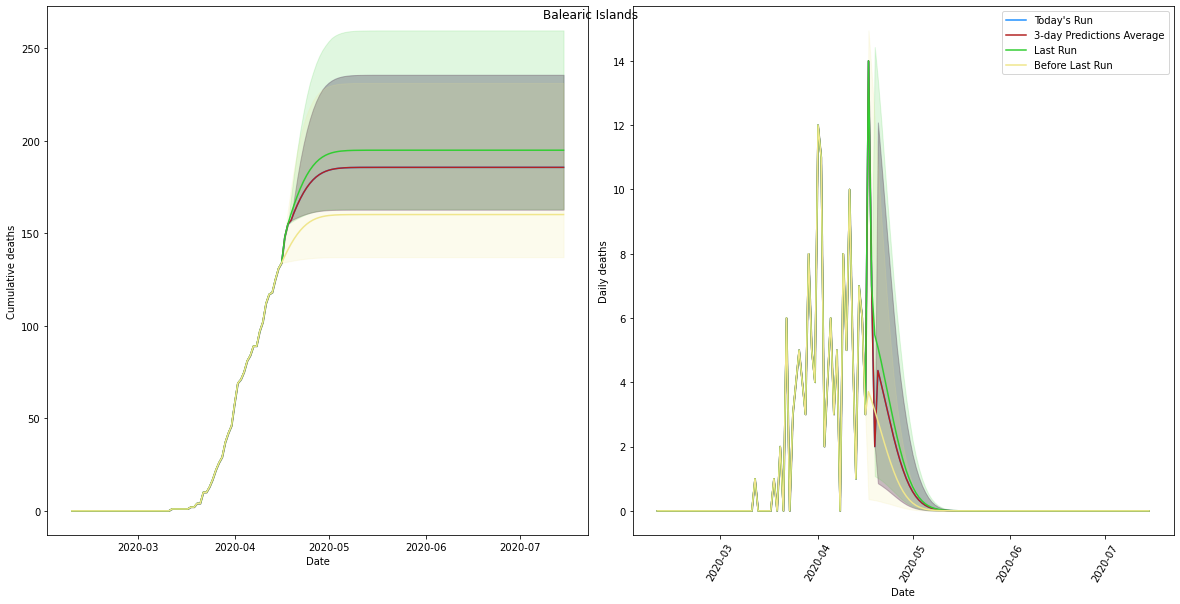

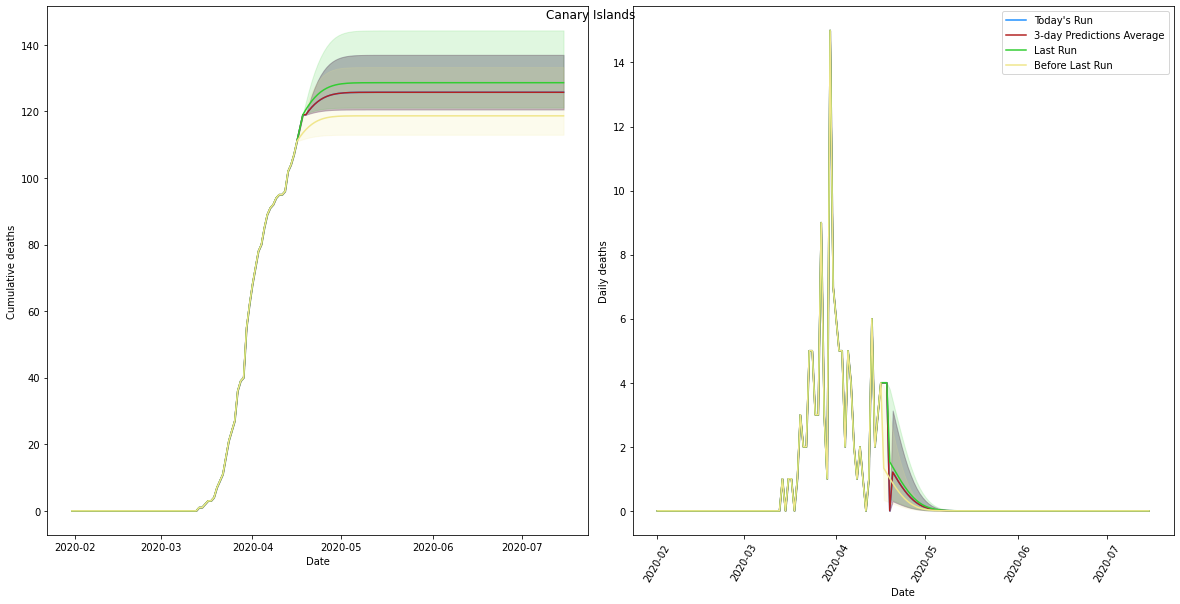

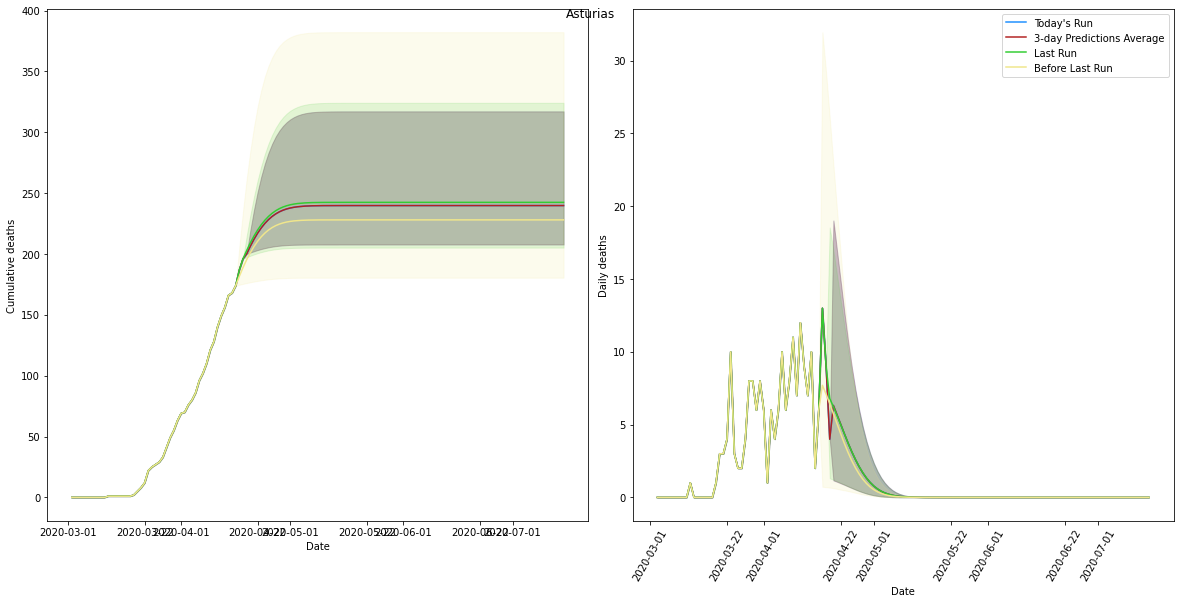

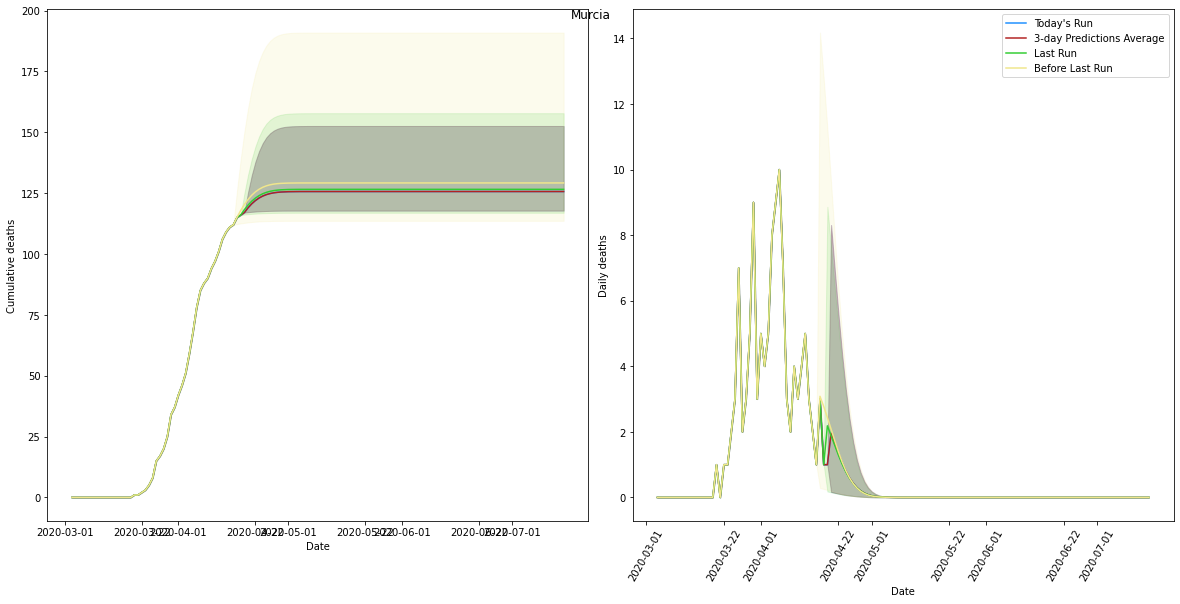

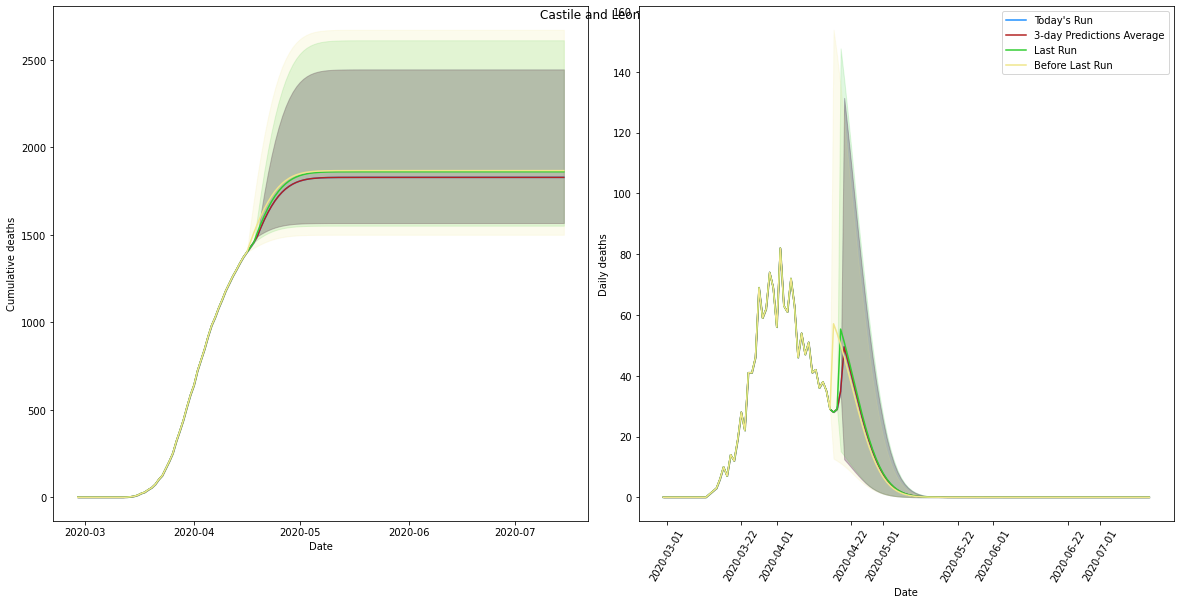

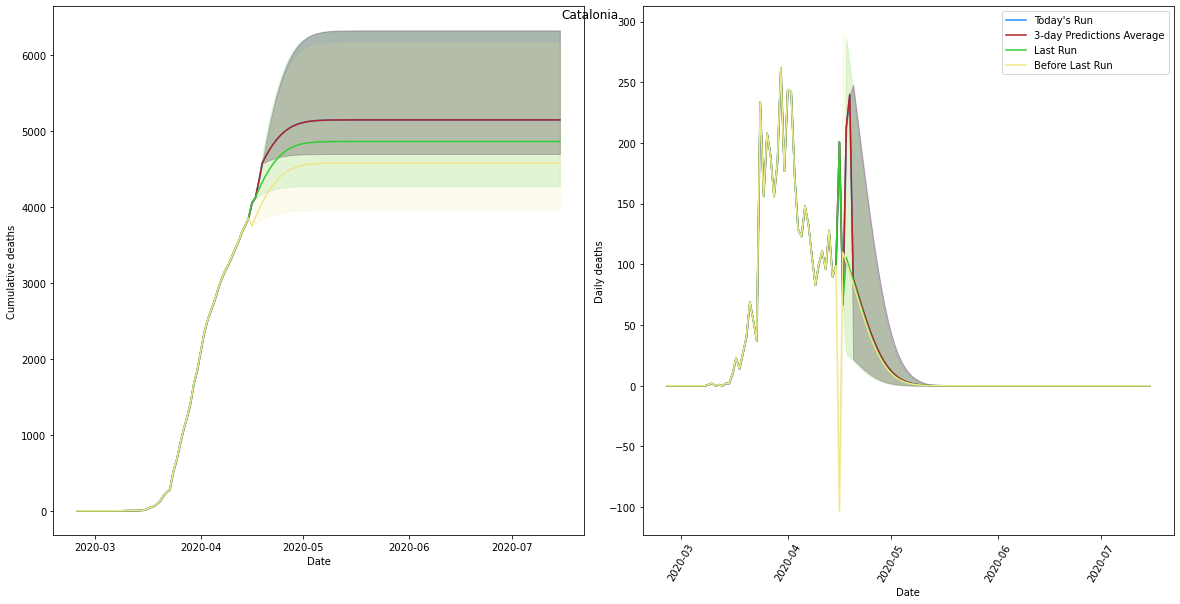

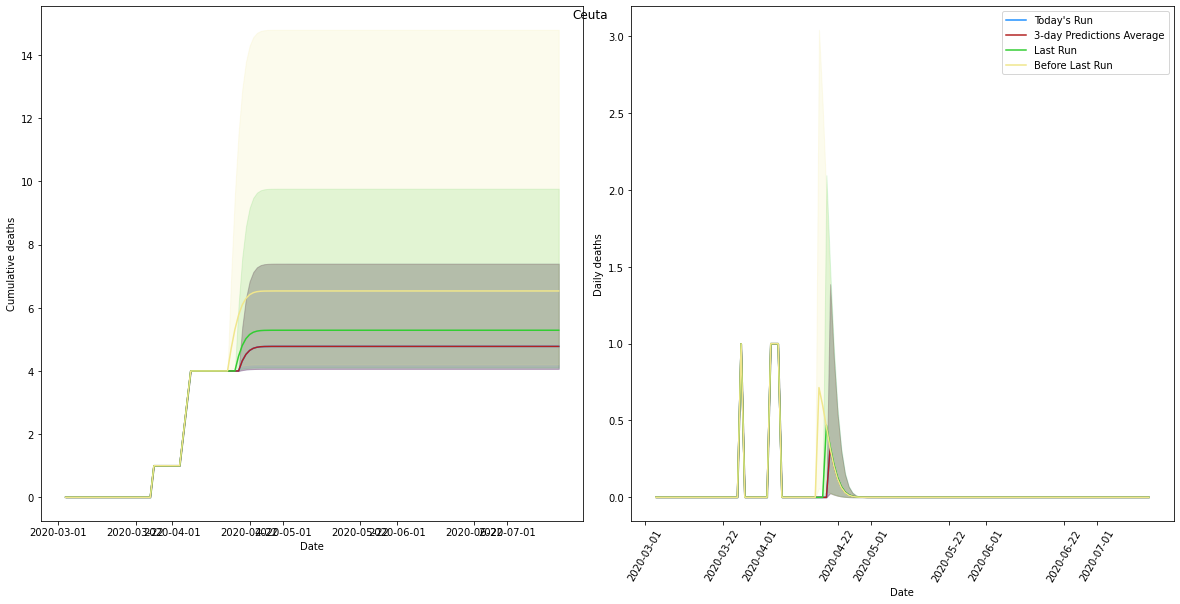

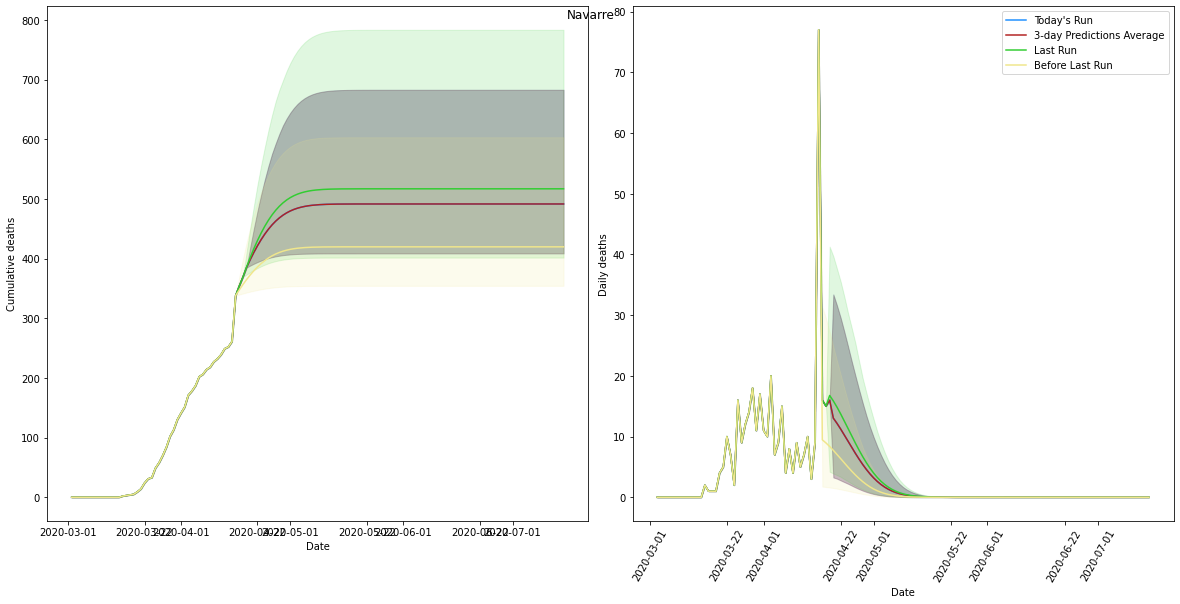

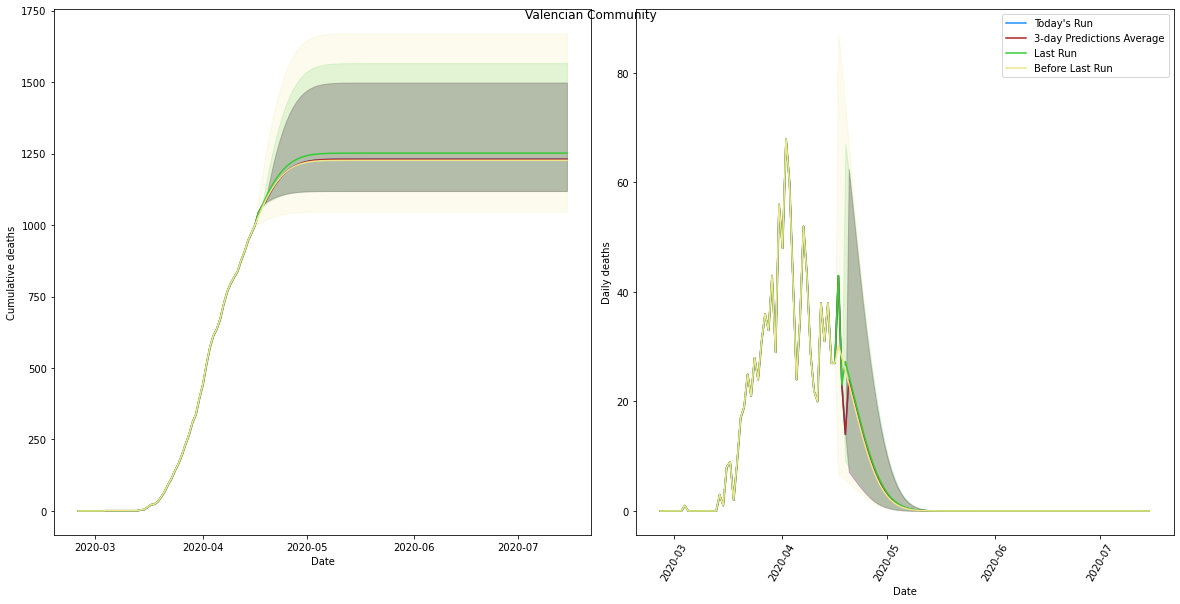

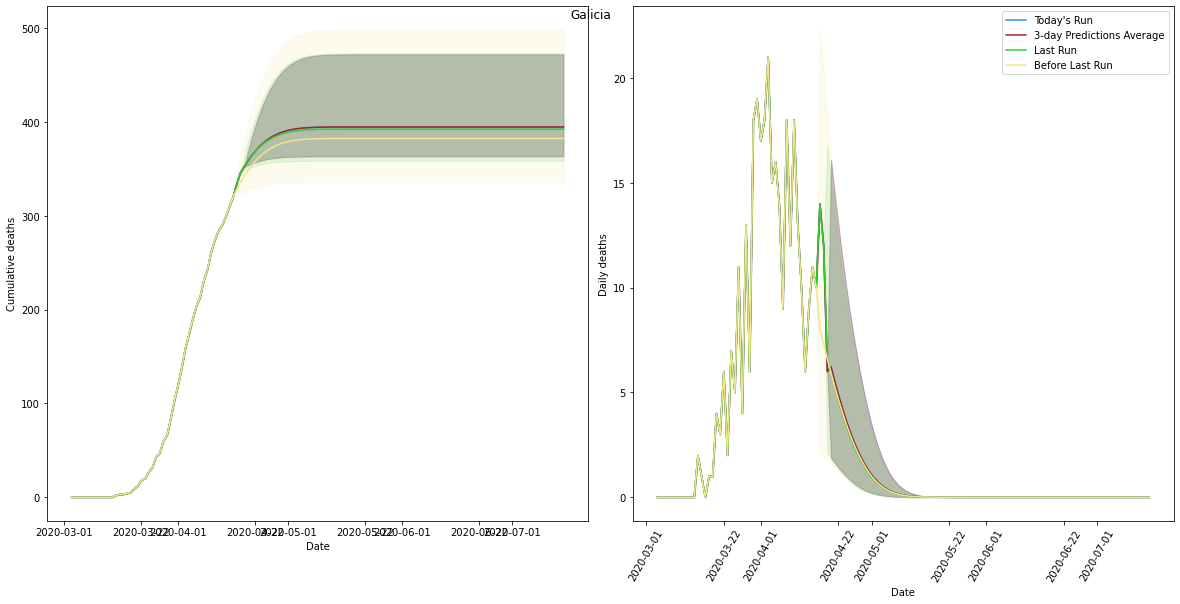

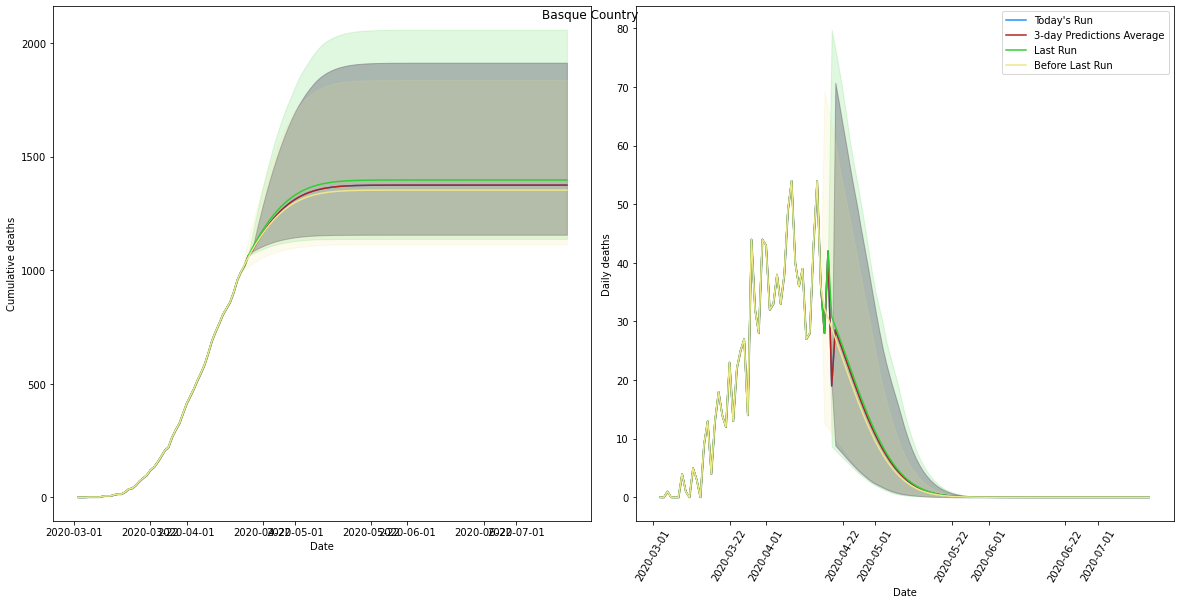

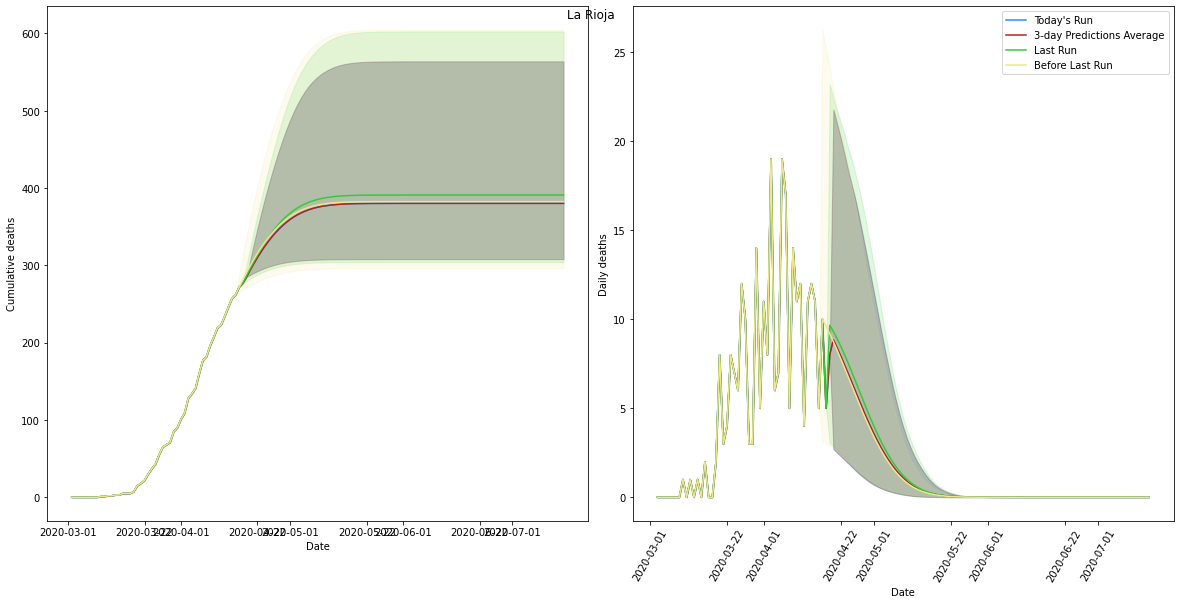

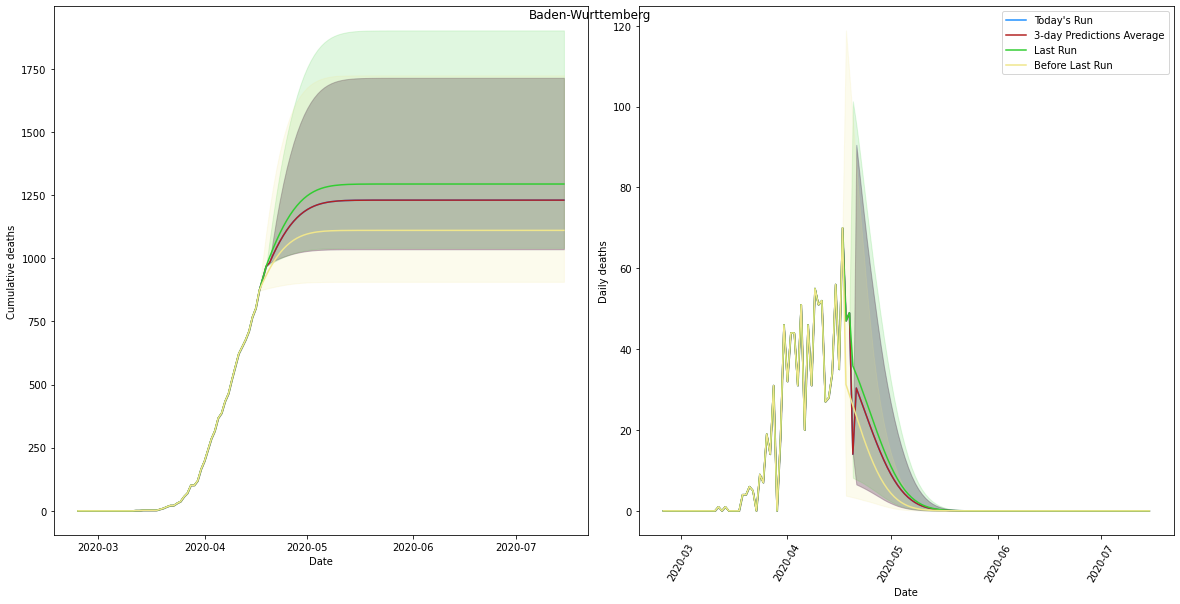

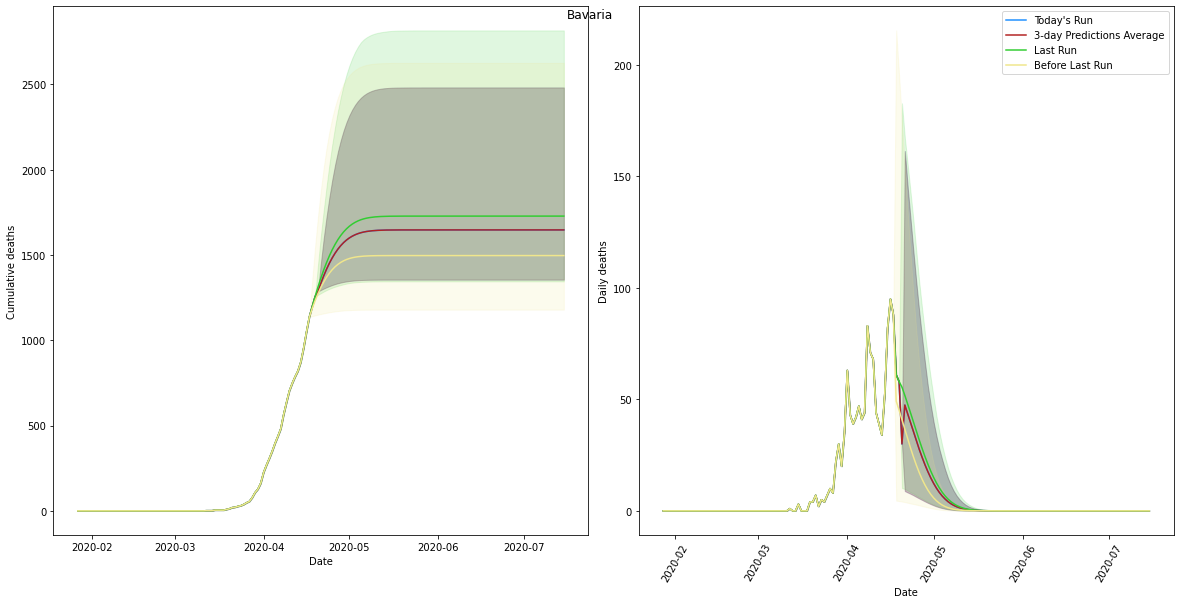

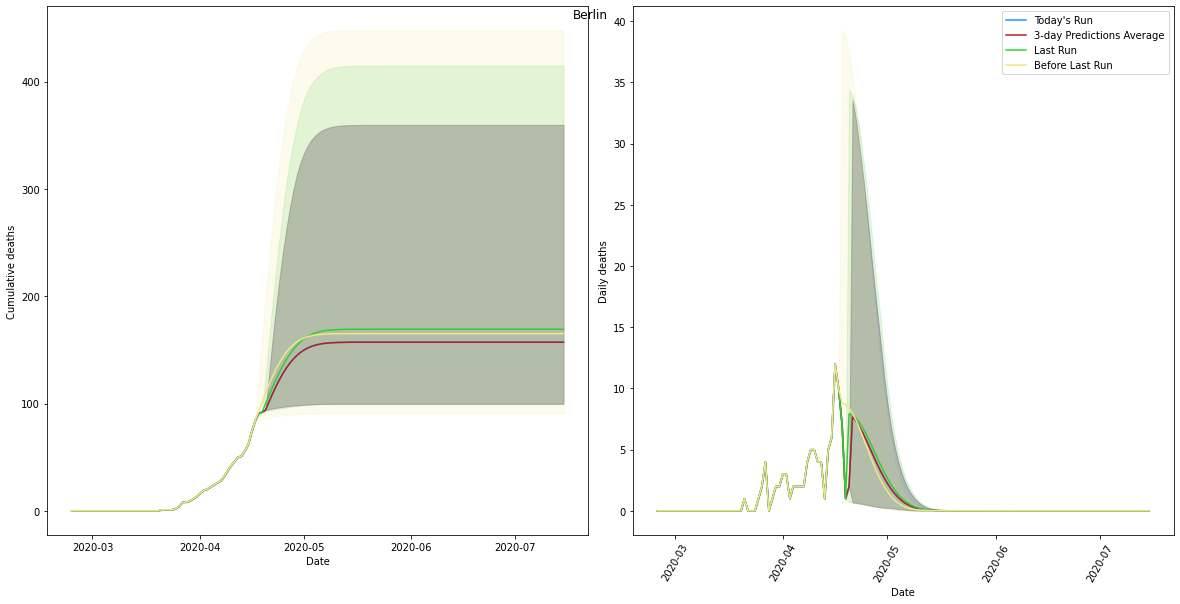

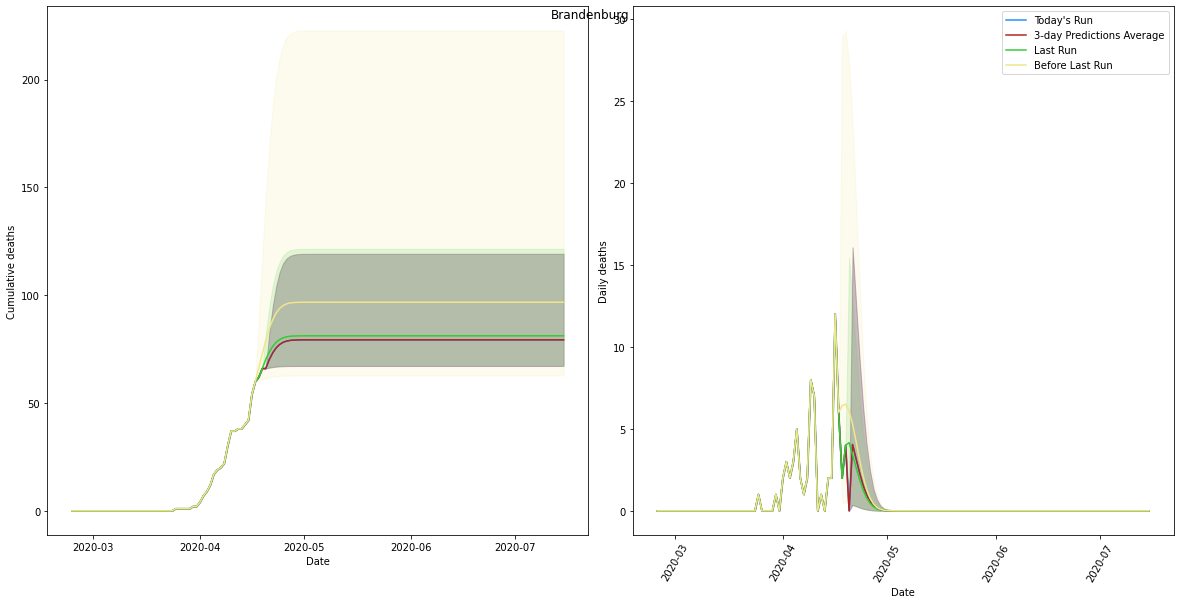

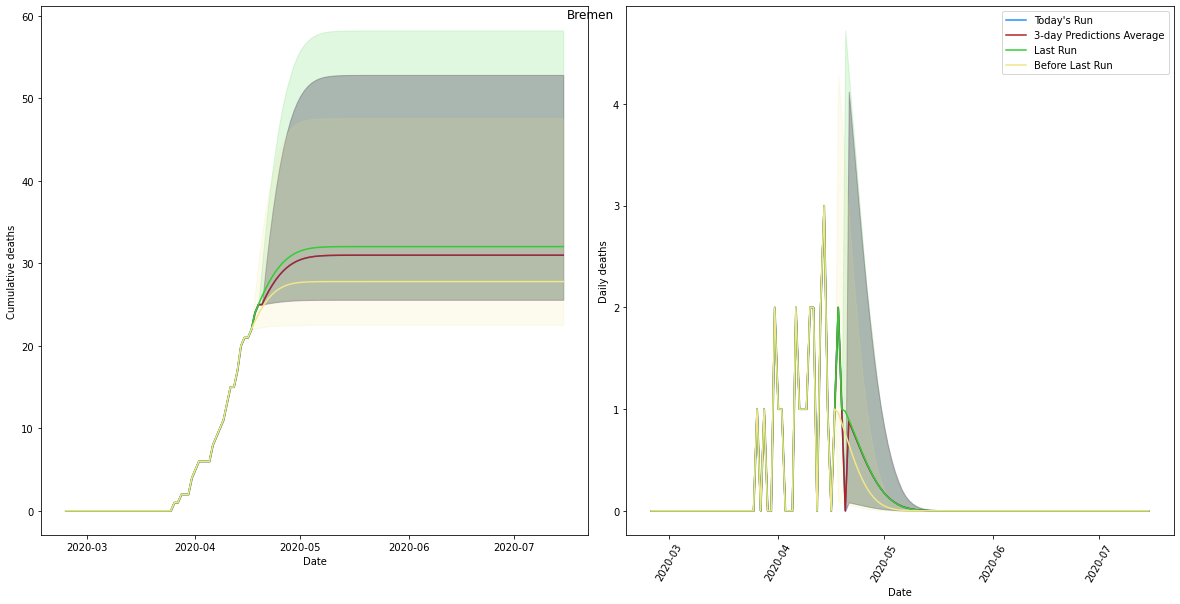

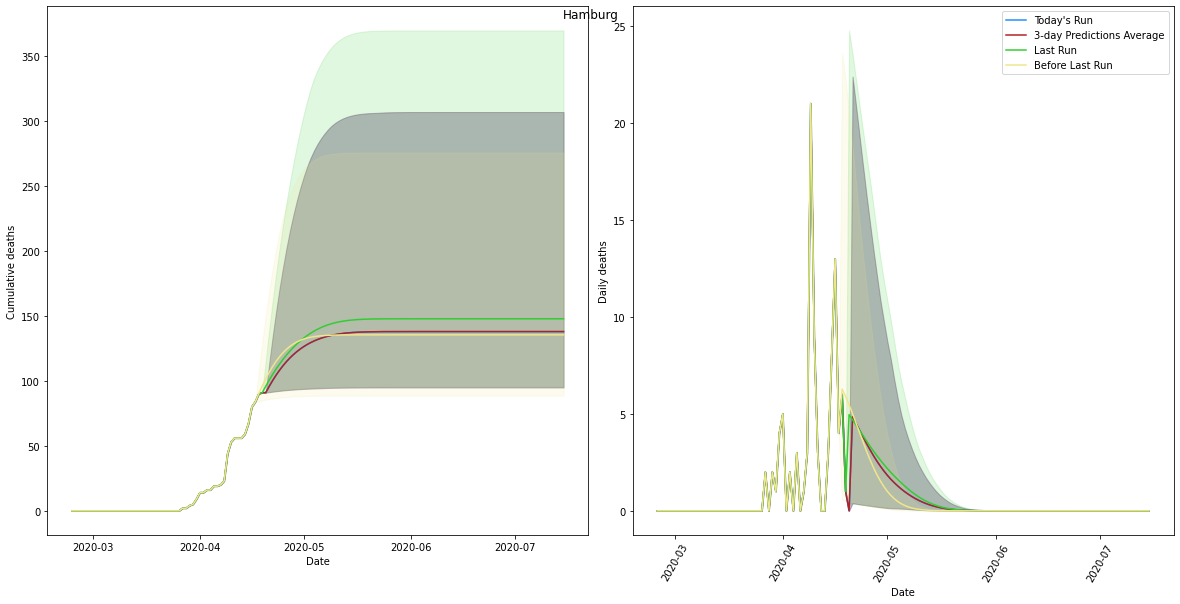

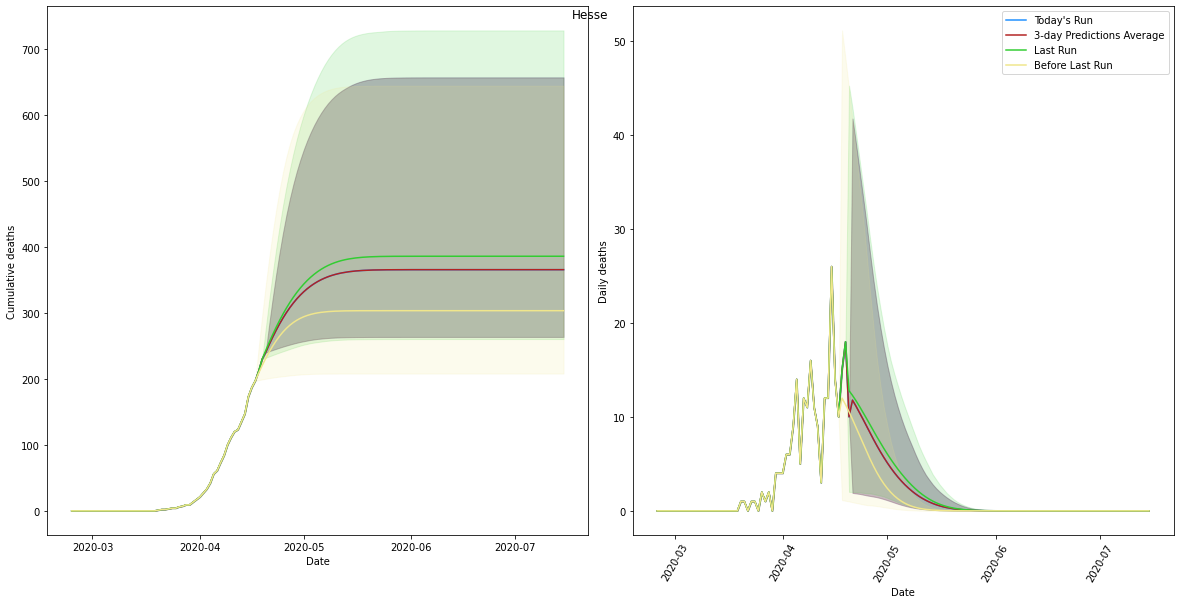

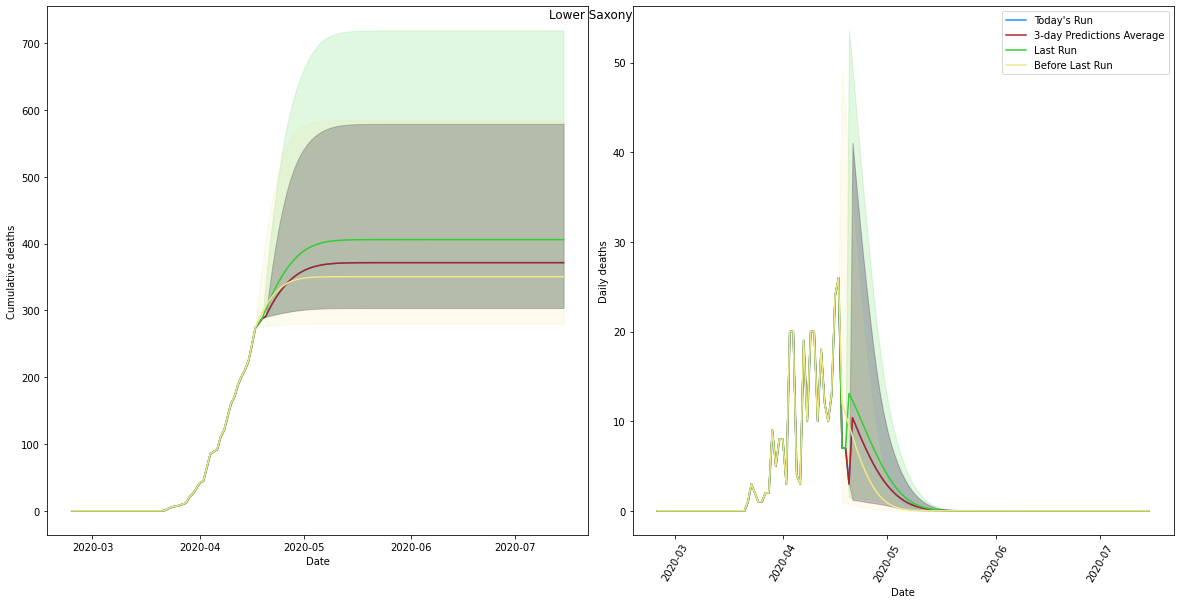

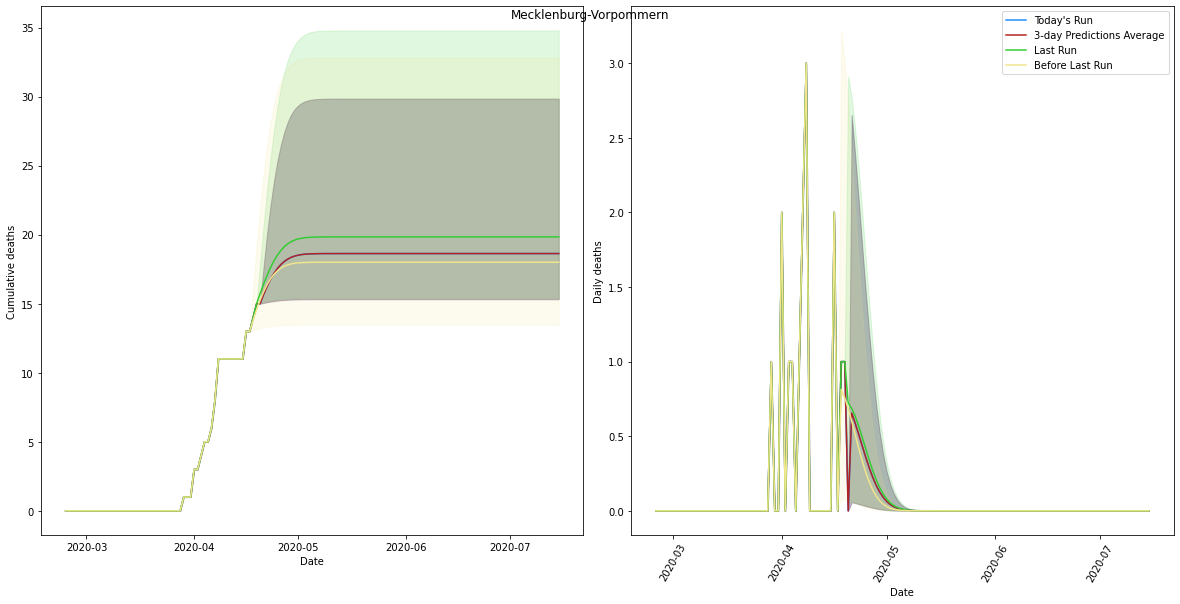

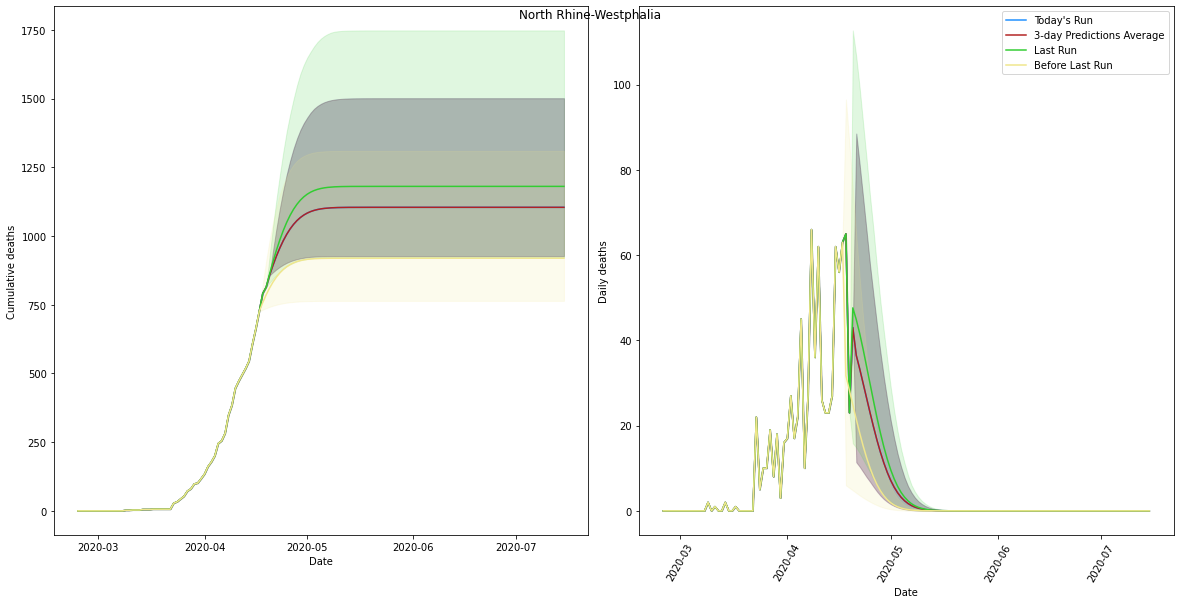

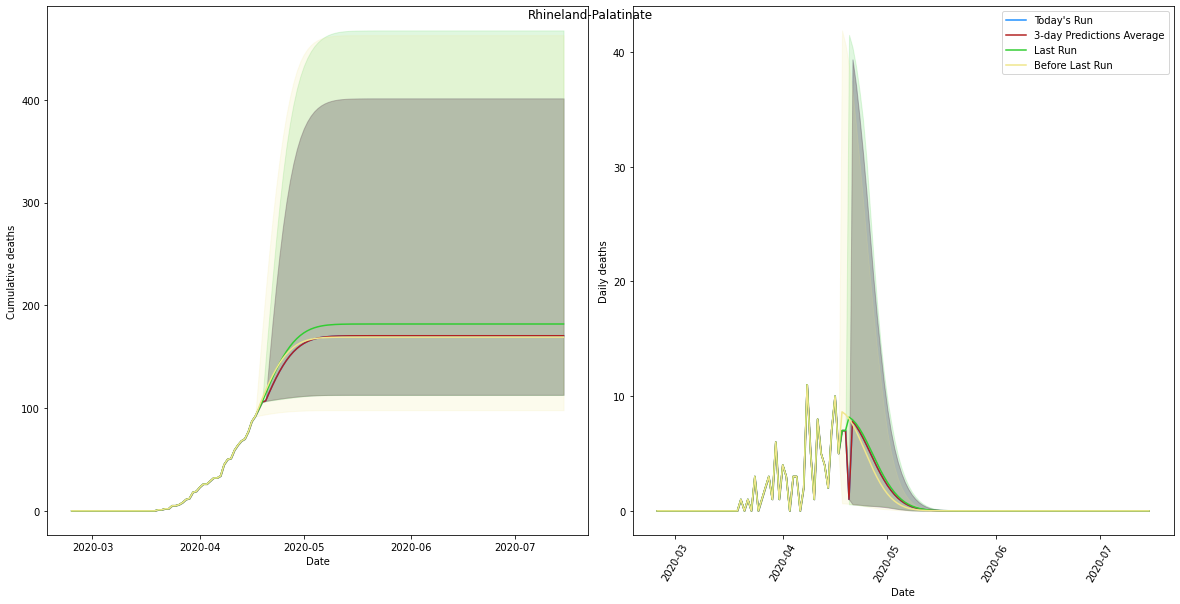

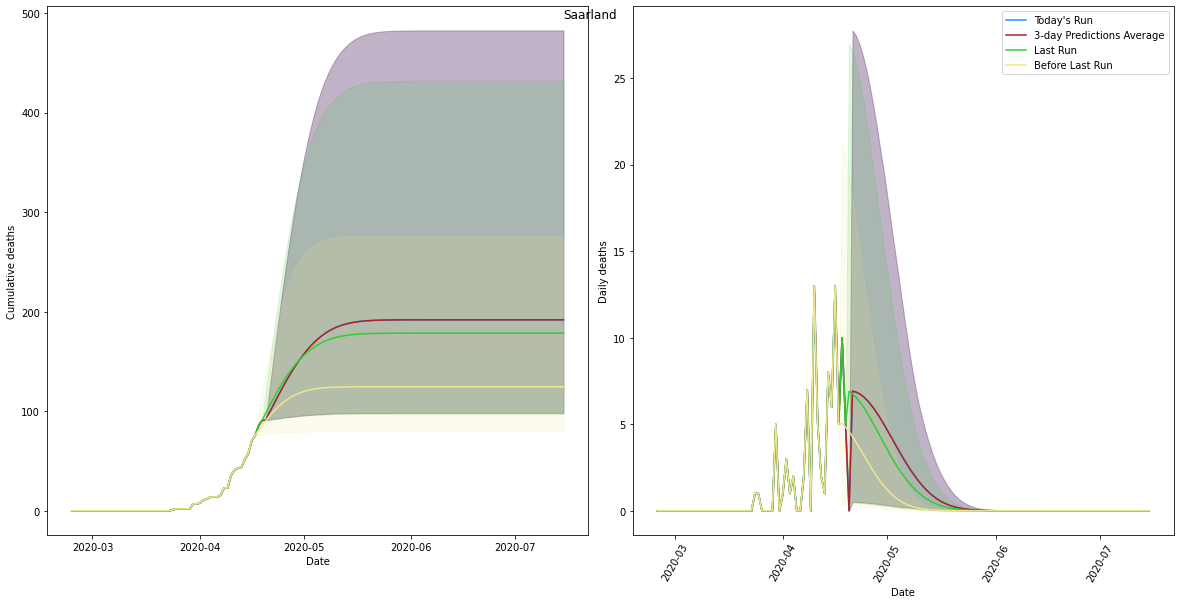

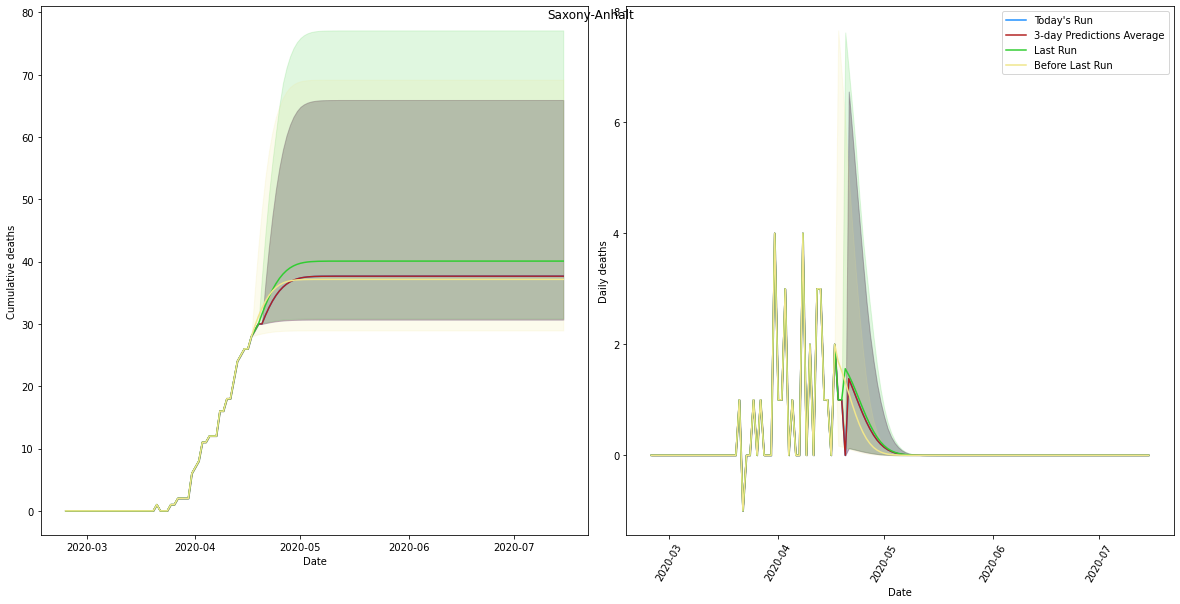

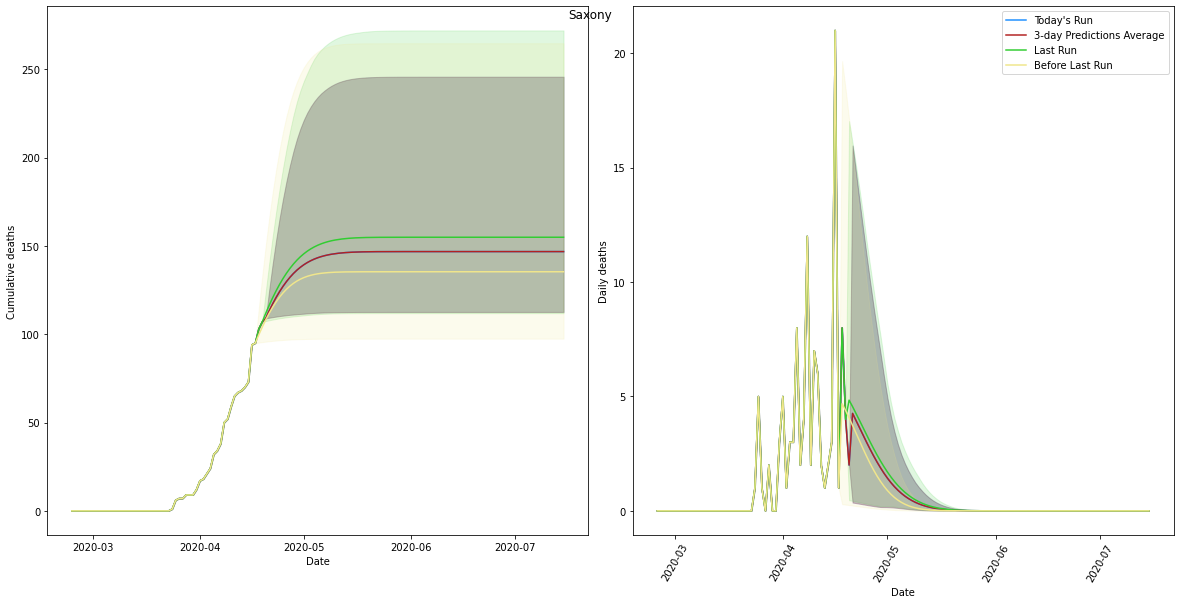

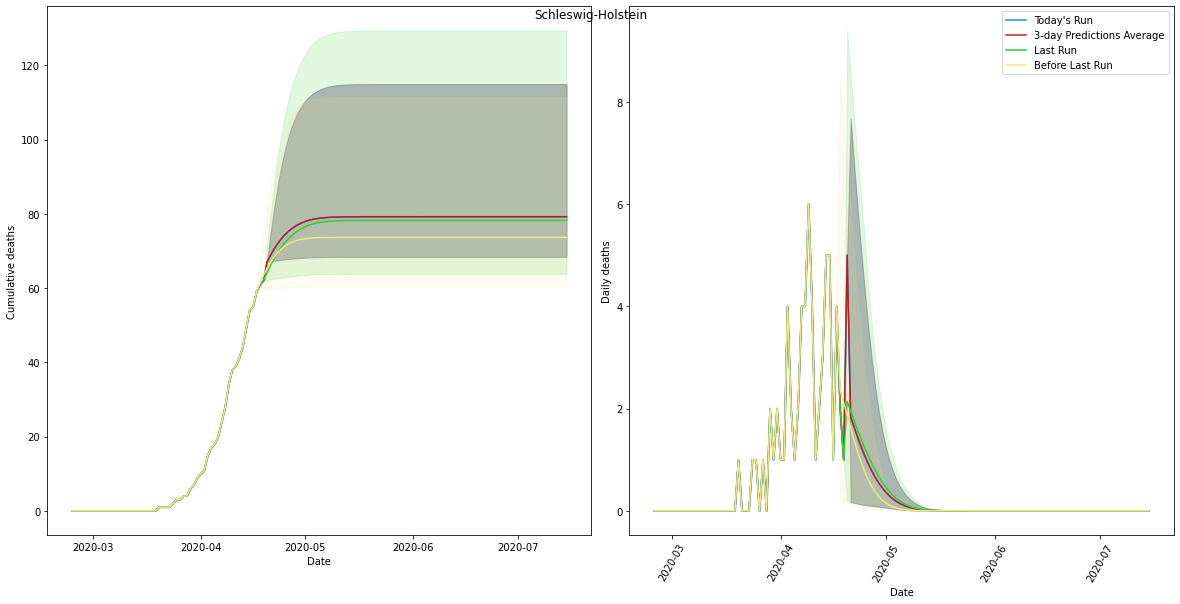

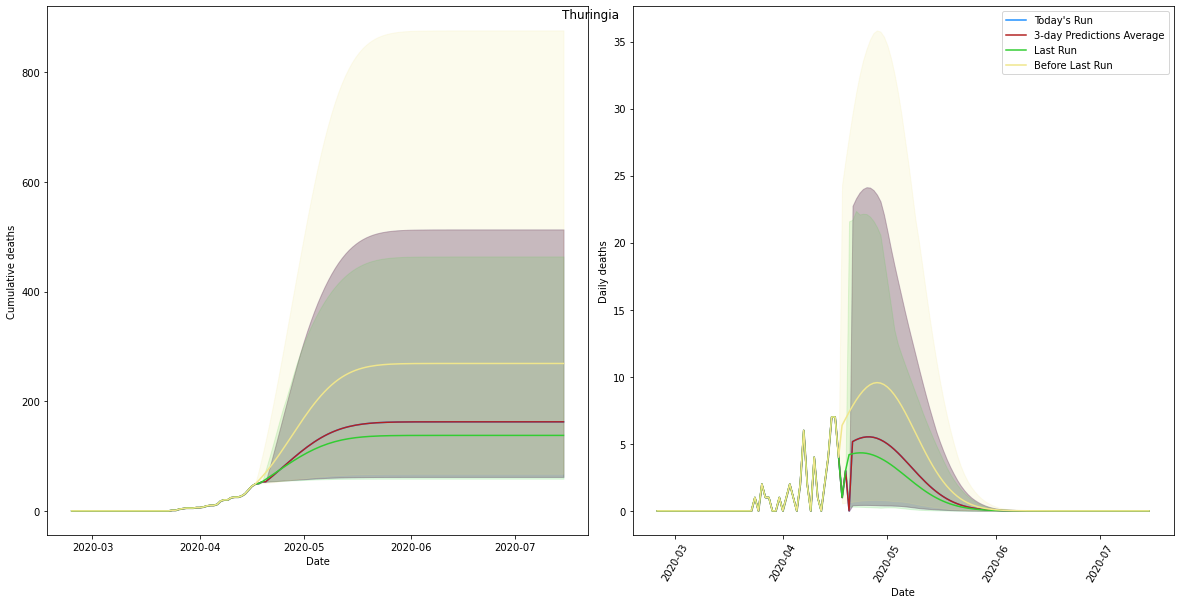

In [12]:
plotter = CompareAveragingModelDeaths(
            raw_draw_path=model_1_path,
            average_draw_path='today_average.csv',
            yesterday_draw_path=model_2_path,
            before_yesterday_draw_path=model_3_path
        )
plotter.make_some_pictures(f'/ihme/covid-19/deaths/prod/2020_04_20_Europe/moving_average_compare.pdf',
                                   'EEA + others')